In [1]:
from load_dataset.artgraph import ArtGraph
from utils.MultiTaskLinkSplitter import MultiTaskLinkSplitter
from utils.dataset import TrainingDataSet, TestDataSet
from utils.EarlyStopping import EarlyStopping
from multi_task_model import MultiTaskClassificationModel, NewMultiTaskClassificationModel, MultiTaskHead
from torch import nn
from vit_model import ViT
#from utils.training_utils import fine_tune, test as test_func, compute_topk, plot_confusion_matrix
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision import transforms
from torch import optim
import torch
import copy
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from timm import create_model
%matplotlib inline

In [2]:
from torch_geometric.seed import seed_everything
seed_everything(1)

In [3]:
root = 'artgraph2bestemotions'
data_path = 'data_full_labels.csv'
root_dataset = 'common_dataset'
img = 'images-resized'
complete_dataset_path='complete_dataset.csv'

In [4]:
data = ArtGraph(root = root, preprocess='constant', features = 'vit', fine_tuning = True)[0]
data

Processing...
Done!


HeteroData(
  artwork={ x=[116475, 128] },
  artist={ x=[2501, 1] },
  gallery={ x=[1099, 1] },
  city={ x=[596, 1] },
  country={ x=[58, 1] },
  style={ x=[32, 1] },
  period={ x=[186, 1] },
  genre={ x=[18, 1] },
  serie={ x=[823, 1] },
  tag={ x=[5424, 1] },
  media={ x=[167, 1] },
  subject={ x=[6985, 1] },
  training_node={ x=[268, 1] },
  field={ x=[54, 1] },
  movement={ x=[243, 1] },
  people={ x=[109, 1] },
  emotion={ x=[9, 1] },
  (artist, belongstofield, field)={ edge_index=[2, 987] },
  (artist, belongstomovement, movement)={ edge_index=[2, 1056] },
  (artist, haspatron, people)={ edge_index=[2, 124] },
  (artist, hassubject, subject)={ edge_index=[2, 21054] },
  (artist, relatedtoschool, training_node)={ edge_index=[2, 498] },
  (artist, trainedby, artist)={ edge_index=[2, 47] },
  (artwork, about, tag)={ edge_index=[2, 342982] },
  (artwork, createdby, artist)={ edge_index=[2, 116475] },
  (artwork, elicit, emotion)={ edge_index=[2, 65236] },
  (artwork, hasgenre, genre)

In [5]:
train = torch.load(f'{root_dataset}/train_data.pt')
val = torch.load(f'{root_dataset}/val_set.pt')
test = torch.load(f'{root_dataset}/test_set.pt')

In [6]:
train

HeteroData(
  artwork={ x=[116475, 128] },
  artist={ x=[2501, 1] },
  gallery={ x=[1099, 1] },
  city={ x=[596, 1] },
  country={ x=[58, 1] },
  style={ x=[32, 1] },
  period={ x=[186, 1] },
  genre={ x=[18, 1] },
  serie={ x=[823, 1] },
  tag={ x=[5424, 1] },
  media={ x=[167, 1] },
  subject={ x=[6985, 1] },
  training_node={ x=[268, 1] },
  field={ x=[54, 1] },
  movement={ x=[243, 1] },
  people={ x=[109, 1] },
  emotion={ x=[9, 1] },
  (artist, belongstofield, field)={ edge_index=[2, 987] },
  (artist, belongstomovement, movement)={ edge_index=[2, 1056] },
  (artist, haspatron, people)={ edge_index=[2, 124] },
  (artist, hassubject, subject)={ edge_index=[2, 21054] },
  (artist, relatedtoschool, training_node)={ edge_index=[2, 498] },
  (artist, trainedby, artist)={ edge_index=[2, 47] },
  (artwork, about, tag)={ edge_index=[2, 181644] },
  (artwork, createdby, artist)={ edge_index=[2, 52188] },
  (artwork, elicit, emotion)={ edge_index=[2, 52188] },
  (artwork, hasgenre, genre)=

In [7]:
val

tensor([40118, 74027,  7776,  ..., 57596, 68515,  3083])

In [8]:
test

tensor([58798, 60364,  6774,  ..., 15295, 41140, 20064])

In [9]:
complete_dataset= pd.read_csv(complete_dataset_path)
complete_dataset.iloc[5]

artwork                                            124
name       giorgione_globe-moon-sun-astronomy-1510.jpg
emotion                                              1
style                                               13
genre                                               15
Name: 5, dtype: object

In [10]:
complete_dataset

artwork                                               name  emotion  \
0           95  giorgione_the-adoration-of-the-shepherds-1510.jpg        2   
1           96     giorgione_young-man-the-impassioned-singer.jpg        5   
2           99  giorgione_madonna-and-child-in-a-landscape-150...        2   
3          102  giorgione_portrait-of-a-young-woman-laura-1506...        1   
4          119           giorgione_the-adoration-of-the-kings.jpg        4   
...        ...                                                ...      ...   
65231    84724  john-russell_the-right-honourable-selina-count...        4   
65232    84725      john-russell_two-small-girls-with-bonnets.jpg        2   
65233    84726                 john-russell_william-dodd-1769.jpg        2   
65234    84727          john-russell_william-wilberforce-1770.jpg        1   
65235    84728     john-russell_william-wilberforce-1759-1833.jpg        8   

       style  genre  
0         13     12  
1         13      9  
2         13     12  
3         13      9  
4         13     12  
...      ...    ...  
65231     14      9  
65232     14      9  
65233     14      9  
65234     14      9  
65235     14      9  

[65236 rows x 5 columns]

In [11]:
#custom class to manage artworks
class ViTDataSet(torch.utils.data.Dataset):
    def __init__(self,  complete_dataset, transform):
        #getting training artworks
        self.data = complete_dataset
        self.transform = transform
        
    def __len__(self):
        return self.data.index.shape[0]

    def __getitem__(self, idx):
        idx, name, emotion, style, genre, = self.data.iloc[idx]
        #print(idx,name, style, genre, emotion)
        img_path = fr'{img}/{name}'
        image = Image.open(img_path)
        if(image.mode != 'RGB'):
            image = image.convert('RGB')
        tensor_image = self.transform(image)
        return tensor_image, (style, genre, emotion)

In [12]:
# new version custom dataset
class TestDataSet(ViTDataSet):
    def __init__(self, x_test, complete_dataset, transform):
        print(x_test)
        self.data = complete_dataset[complete_dataset['artwork'].isin(x_test.tolist())]
        self.transform = transform
        
    def __getitem__(self, idx):
        idx, name, emotion, style, genre  = self.data.iloc[idx]
        img_path = fr'{img}/{name}'
        image = Image.open(img_path)
        if(image.mode != 'RGB'):
            image = image.convert('RGB')
        tensor_image = self.transform(image)
        return tensor_image,(style, genre, emotion)#image,name, self.features[idx], (style, genre, emotion)

In [14]:
data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [15]:
train_dataset = ViTDataSet(complete_dataset = complete_dataset,transform=data_transforms)

In [16]:
val_dataset = TestDataSet( x_test = val, complete_dataset = complete_dataset,transform=data_transforms)

tensor([40118, 74027,  7776,  ..., 57596, 68515,  3083])


In [17]:
test_dataset = TestDataSet( x_test = test, complete_dataset = complete_dataset,transform=data_transforms)

tensor([58798, 60364,  6774,  ..., 15295, 41140, 20064])


In [18]:
val_dataset.data

artwork                                               name  emotion  \
0           95  giorgione_the-adoration-of-the-shepherds-1510.jpg        2   
10         141                 jacopo-bellini_the-crucifixion.jpg        4   
18         151  jacopo-bellini_john-the-evangelist-the-apostle...        8   
26         163               jacopo-bellini_annunciation-1444.jpg        2   
30         167    jacopo-bellini_triptych-of-st-lawrence-1470.jpg        1   
...        ...                                                ...      ...   
65211    84704                 john-russell_john-russell-1780.jpg        2   
65215    84708  john-russell_mary-phoebe-spencer-nelson-taylor...        2   
65218    84711    john-russell_portrait-of-a-girl-in-a-bonnet.jpg        2   
65221    84714                 john-russell_portrait-of-a-man.jpg        2   
65224    84717     john-russell_portrait-of-george-whitefield.jpg        2   

       style  genre  
0         13     12  
10         9     12  
18         9     12  
26         9     12  
30         9     12  
...      ...    ...  
65211     14      3  
65215     14      9  
65218     14      9  
65221     14      9  
65224     14      9  

[6523 rows x 5 columns]

In [19]:
train_dataset.data

artwork                                               name  emotion  \
0           95  giorgione_the-adoration-of-the-shepherds-1510.jpg        2   
1           96     giorgione_young-man-the-impassioned-singer.jpg        5   
2           99  giorgione_madonna-and-child-in-a-landscape-150...        2   
3          102  giorgione_portrait-of-a-young-woman-laura-1506...        1   
4          119           giorgione_the-adoration-of-the-kings.jpg        4   
...        ...                                                ...      ...   
65231    84724  john-russell_the-right-honourable-selina-count...        4   
65232    84725      john-russell_two-small-girls-with-bonnets.jpg        2   
65233    84726                 john-russell_william-dodd-1769.jpg        2   
65234    84727          john-russell_william-wilberforce-1770.jpg        1   
65235    84728     john-russell_william-wilberforce-1759-1833.jpg        8   

       style  genre  
0         13     12  
1         13      9  
2         13     12  
3         13      9  
4         13     12  
...      ...    ...  
65231     14      9  
65232     14      9  
65233     14      9  
65234     14      9  
65235     14      9  

[65236 rows x 5 columns]

In [20]:
test_dataset.data

artwork                                               name  emotion  \
7          137                jacopo-bellini_virgin-and-child.jpg        8   
17         150             jacopo-bellini_christ-in-the-grave.jpg        4   
34         171  jacopo-bellini_the-twelve-apostles-in-a-barrel...        1   
44         182                     pietro-longhi_women-sewing.jpg        2   
50         188               pietro-longhi_the-perfume-seller.jpg        7   
...        ...                                                ...      ...   
65152    84644       conrad-marca-relli_22-february-1960-1960.jpg        8   
65162    84654                conrad-marca-relli_ibiza-v-1968.jpg        8   
65163    84655             conrad-marca-relli_image-no-9-1969.jpg        8   
65197    84690                  conrad-marca-relli_untitled-4.jpg        8   
65220    84713           john-russell_portrait-of-a-lady-1768.jpg        4   

       style  genre  
7          9     12  
17         9     12  
34         9     14  
44        14      4  
50        14      4  
...      ...    ...  
65152     17      6  
65162     17      6  
65163     17      6  
65197     17      6  
65220     14      9  

[6525 rows x 5 columns]

In [21]:
print(train_dataset.__getitem__(5))
print(val_dataset.__getitem__(5))
print(test_dataset.__getitem__(5))

(tensor([[[ 0.4118,  0.3804,  0.4196,  ...,  0.1608,  0.0667,  0.0118],
         [ 0.2235,  0.2471,  0.2471,  ...,  0.4039,  0.4510,  0.4980],
         [ 0.1451,  0.1922,  0.0902,  ...,  0.4745,  0.7020,  0.9059],
         ...,
         [ 0.5059,  0.3569,  0.3255,  ..., -0.2000, -0.2000, -0.1765],
         [ 0.4824,  0.4745,  0.4353,  ..., -0.0902, -0.0510, -0.0588],
         [ 0.8039,  0.7961,  0.7569,  ...,  0.0118,  0.1137,  0.1686]],

        [[ 0.0902,  0.0588,  0.0980,  ..., -0.0118, -0.1059, -0.1686],
         [-0.0980, -0.0745, -0.0824,  ...,  0.2078,  0.2549,  0.3020],
         [-0.1843, -0.1373, -0.2392,  ...,  0.2784,  0.5059,  0.7255],
         ...,
         [ 0.3333,  0.2000,  0.1765,  ..., -0.3961, -0.3961, -0.3647],
         [ 0.3725,  0.3647,  0.3176,  ..., -0.3020, -0.2627, -0.2627],
         [ 0.6941,  0.6863,  0.6392,  ..., -0.2000, -0.0980, -0.0353]],

        [[-0.1294, -0.1608, -0.1216,  ..., -0.1922, -0.2863, -0.3490],
         [-0.3098, -0.2863, -0.2941,  ...,  

#early stopping class to manage the train stage
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0.001):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, current_loss):
        if self.best_loss == None:
            self.best_loss = current_loss
        elif (current_loss - self.best_loss) < -self.min_delta:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait = self.wait + 1
            print(f"INFO: Early stopping counter {self.wait} of {self.patience}")
            if self.wait >= self.patience:
                self.early_stop = True

In [22]:
# multitask version

def fine_tune(model, graph, train_loader, validation_loader,
              criterions, optimizer, early_stop, scheduler,
              num_epochs=100, device=torch.device('cuda:0')): #cuda:0

    best_epoch = 0
    best_loss = None
    style_criterion, genre_criterion, emotion_criterion = criterions
    for epoch in range(1, num_epochs + 1):
        if early_stop.stop:
            break
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 120)

        data_loader = None
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = validation_loader
            running_loss = 0.0
            running_corrects_style = running_corrects_genre = running_corrects_emotion = 0

            
            for image, (style_labels, genre_labels, emotion_labels) in tqdm(data_loader):
                print('image features:',image.shape)#image_features[1,:].shape
                print('style labels:',style_labels.shape)
                print('genre labels:',genre_labels.shape)
                print('emotion labels:',emotion_labels.shape)
                image = image.to(device, non_blocking=True)
                style_labels = style_labels.to(device, non_blocking=True)
                genre_labels = genre_labels.to(device, non_blocking=True)
                emotion_labels = emotion_labels.to(device, non_blocking=True)

                optimizer.zero_grad()
                
                out_style, out_genre, out_emotion = model(image)#, graph.x_dict, graph.edge_index_dict)
                

                _, preds_style = torch.max(nn.Softmax(dim=1)(out_style), dim=1)
                _, preds_genre = torch.max(nn.Softmax(dim=1)(out_genre), dim=1)
                _, preds_emotion = torch.max(nn.Softmax(dim=1)(out_emotion), dim=1)

                loss_style = style_criterion(out_style, style_labels)
                loss_genre = genre_criterion(out_genre, genre_labels)
                loss_emotion = emotion_criterion(out_emotion, emotion_labels)

                loss = (loss_style + loss_genre + loss_emotion)/3

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * data_loader.batch_size
                running_corrects_style += torch.sum(preds_style == style_labels)
                running_corrects_genre += torch.sum(preds_genre == genre_labels)
                running_corrects_emotion += torch.sum(preds_emotion == emotion_labels)

            epoch_loss = running_loss / (len(data_loader) * data_loader.batch_size)
            epoch_acc_style = running_corrects_style.double() / (len(data_loader) * data_loader.batch_size)
            epoch_acc_genre = running_corrects_genre.double() / (len(data_loader) * data_loader.batch_size)
            epoch_acc_emotion = running_corrects_emotion.double() / (len(data_loader) * data_loader.batch_size)

            print(f'''{phase} Loss: {epoch_loss:.4f} Style Acc: {epoch_acc_style:.4f}
            Genre Acc: {epoch_acc_genre:.4f}
            Emotion Acc: {epoch_acc_emotion:.4f}''')

            if phase == 'val':
                scheduler.step(epoch_loss)
                early_stop(epoch_loss, model)
                if epoch == 1 or best_loss > epoch_loss:
                    best_loss = epoch_loss
                    best_epoch = epoch

    print(f'Best epoch: {best_epoch:04d}')
    print(f'Best loss: {best_loss:.4f}')


def fine_tune(model, train_loader, validation_loader, criterion, optimizer, scheduler, early_stop, num_epochs):
    best_model = copy.deepcopy(model)
    best_acc = 0.0
    best_epoch=0
    
    stop = False
    for epoch in range(1, num_epochs + 1):
        if stop:
            break
        print(f'Epoch {epoch}/{num_epochs}')
        print('-'*120)

        data_loader = None
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = validation_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(nn.Softmax(dim = 1)(outputs), 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / (len(data_loader) * data_loader.batch_size)
            epoch_acc = running_corrects.double() / (len(data_loader) * data_loader.batch_size)

            if phase == 'val':
                scheduler.step(epoch_loss)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_model = copy.deepcopy(model)
                
                
            if phase == 'val':
                early_stop(epoch_loss)
                print('-'*120, end = '\n\n')
                stop=early_stop.early_stop
                
                
    print(f'Best val Acc: {best_acc:4f}')
    print(f'Best epoch: {best_epoch:03d}')

    # load best model 
    return best_model

In [23]:
# Load device
device = torch.device('cuda:0')

In [24]:
#checkpoint = torch.load('checkpoint.pt')
EPOCH = 13
PATH = "vit_13epoch.pt"
LOSS = 1.0233

#torch.save({
#            'epoch': EPOCH,
#            'model_state_dict': checkpoint.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': LOSS,
#            }, PATH)

modules=[]

hidden_channels = sum((data[o]['x'].shape[0] * 128 for o in ['style','genre','emotion'])) + 128

out_channels_style = data['style'].x.shape[0]
style_head = torch.nn.Linear(hidden_channels, out_channels_style)

out_channels_genre = data['genre'].x.shape[0]
genre_head = torch.nn.Linear(hidden_channels, out_channels_genre)

out_channels_emotion = data['emotion'].x.shape[0]
emotion_head = torch.nn.Linear(hidden_channels, out_channels_emotion)

modules.append(style_head)
modules.append(genre_head)
modules.append(emotion_head)

sequential = nn.Sequential(*modules)
vit.head = sequential

In [25]:
# Load saved model
model_saved=ViT(data=data).to(device)
optimizer = optim.Adam(model_saved.parameters(), lr=1e-3)
checkpoint_saved=torch.load("vit_13epoch.pt")
model_saved.load_state_dict(checkpoint_saved['model_state_dict'])
optimizer.load_state_dict(checkpoint_saved['optimizer_state_dict'])
epoch = checkpoint_saved['epoch']
loss = checkpoint_saved['loss']

FileNotFoundError: [Errno 2] No such file or directory: 'vit_13epoch.pt'

In [ ]:
## REQUIRES GRAD FOR HEAD PARAMETERS
for p in model_saved.parameters():
    p.requires_grad=False

In [ ]:
for p in model_saved.style_head.parameters():
    p.requires_grad = True

In [ ]:
for p in model_saved.genre_head.parameters():
    p.requires_grad = True

In [ ]:
for p in model_saved.emotion_head.parameters():
    p.requires_grad = True

In [27]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, 
                                   drop_last=False)

val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, 
                                   drop_last=False)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, 
                                   drop_last=False)

In [28]:
torch.cuda.empty_cache()

In [29]:
model_saved

ViT(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)

In [38]:
#optimizer = optim.Adam(vit.parameters(), lr=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr = 1e-6, verbose = True, factor = .1, patience = 1,
                                           threshold = 1e-3)
criterions = list(nn.CrossEntropyLoss() for _ in range(3))
early_stop = EarlyStopping(patience = 5, min_delta = 0.001)
fine_tune(model_saved, train, train_loader, val_loader, criterions, optimizer,  early_stop,scheduler,  num_epochs = 17, device = torch.device('cuda:0'))#
#best_model=fine_tune(vit, train_loader, val_loader, criterions, optimizer,scheduler,  early_stop,  num_epochs = 30)
torch.save('vit_fine_tune_finetuned.pt')

Epoch 1/17
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/510 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 1/510 [00:03<29:13,  3.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 2/510 [00:05<23:47,  2.81s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 3/510 [00:08<21:53,  2.59s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 4/510 [00:10<20:58,  2.49s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 5/510 [00:12<20:24,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 6/510 [00:15<20:09,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|▏         | 7/510 [00:17<19:59,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 8/510 [00:19<20:06,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 9/510 [00:22<20:10,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 10/510 [00:24<20:11,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 11/510 [00:27<20:13,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 12/510 [00:29<20:13,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 13/510 [00:32<20:19,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 14/510 [00:34<20:20,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 15/510 [00:37<20:16,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 16/510 [00:39<20:12,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 17/510 [00:42<20:09,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 18/510 [00:44<20:06,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 19/510 [00:46<20:06,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 20/510 [00:49<20:02,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 21/510 [00:51<19:59,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 22/510 [00:54<19:54,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 23/510 [00:56<19:52,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 24/510 [00:59<19:48,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 25/510 [01:01<19:47,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 26/510 [01:04<19:48,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 27/510 [01:06<19:44,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 28/510 [01:08<19:40,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 29/510 [01:11<19:39,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 30/510 [01:13<19:36,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 31/510 [01:16<19:31,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 32/510 [01:18<19:29,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 33/510 [01:21<19:28,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 34/510 [01:23<19:24,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 35/510 [01:26<19:20,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 36/510 [01:28<19:16,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 37/510 [01:30<19:14,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 38/510 [01:33<19:13,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 39/510 [01:35<19:16,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 40/510 [01:38<19:11,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 41/510 [01:40<19:07,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 42/510 [01:43<19:06,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 43/510 [01:45<19:01,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▊         | 44/510 [01:48<18:59,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 45/510 [01:50<18:55,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 46/510 [01:53<18:55,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 47/510 [01:55<18:52,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 48/510 [01:57<18:49,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 49/510 [02:00<18:47,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 50/510 [02:02<18:43,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 51/510 [02:05<18:41,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 52/510 [02:07<18:46,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 53/510 [02:10<18:41,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 54/510 [02:12<18:38,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 55/510 [02:15<18:34,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 56/510 [02:17<18:31,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 57/510 [02:19<18:29,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█▏        | 58/510 [02:22<18:25,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 59/510 [02:24<18:28,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 60/510 [02:27<18:24,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 61/510 [02:29<18:19,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 62/510 [02:32<18:16,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 63/510 [02:34<18:13,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 64/510 [02:37<18:08,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 65/510 [02:39<18:12,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 66/510 [02:41<18:06,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 67/510 [02:44<18:02,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 68/510 [02:46<17:58,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 69/510 [02:49<17:54,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 70/510 [02:51<17:50,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 71/510 [02:54<17:48,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 72/510 [02:56<17:52,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 73/510 [02:59<17:49,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 74/510 [03:01<17:45,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 75/510 [03:03<17:41,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 76/510 [03:06<17:39,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 77/510 [03:08<17:47,  2.47s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 78/510 [03:11<17:58,  2.50s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 79/510 [03:13<17:50,  2.48s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 80/510 [03:16<17:41,  2.47s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 81/510 [03:18<17:36,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 82/510 [03:21<17:30,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 83/510 [03:23<17:23,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 84/510 [03:26<17:21,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 85/510 [03:28<17:22,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 86/510 [03:31<17:19,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 87/510 [03:33<17:14,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 88/510 [03:35<17:09,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 89/510 [03:38<17:06,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 90/510 [03:40<17:03,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 91/510 [03:43<16:59,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 92/510 [03:45<16:56,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 93/510 [03:48<16:53,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 94/510 [03:50<16:50,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▊        | 95/510 [03:52<16:47,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 96/510 [03:55<16:45,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 97/510 [03:57<16:42,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 98/510 [04:00<16:45,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 99/510 [04:02<16:41,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 100/510 [04:05<16:37,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 101/510 [04:07<16:34,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 102/510 [04:09<16:31,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 103/510 [04:12<16:29,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 104/510 [04:14<16:27,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 105/510 [04:17<16:27,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 106/510 [04:19<16:23,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 107/510 [04:22<16:20,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 108/510 [04:24<16:16,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██▏       | 109/510 [04:26<16:14,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 110/510 [04:29<16:10,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 111/510 [04:31<16:14,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 112/510 [04:34<16:11,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 113/510 [04:36<16:07,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 114/510 [04:39<16:05,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 115/510 [04:41<16:01,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 116/510 [04:44<15:58,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 117/510 [04:46<15:56,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 118/510 [04:48<16:00,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 119/510 [04:51<15:56,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 120/510 [04:53<15:52,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 121/510 [04:56<15:49,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 122/510 [04:58<15:46,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 123/510 [05:01<15:43,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 124/510 [05:03<15:46,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 125/510 [05:06<15:42,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 126/510 [05:08<15:37,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 127/510 [05:10<15:32,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 128/510 [05:13<15:33,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 129/510 [05:16<16:33,  2.61s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 130/510 [05:18<16:10,  2.55s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 131/510 [05:21<15:56,  2.52s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 132/510 [05:23<15:43,  2.50s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 133/510 [05:26<15:33,  2.48s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 134/510 [05:28<15:25,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 135/510 [05:30<15:20,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 136/510 [05:33<15:14,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 137/510 [05:35<15:16,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 138/510 [05:38<15:10,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 139/510 [05:40<15:04,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 140/510 [05:43<15:01,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 141/510 [05:45<14:58,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 142/510 [05:48<14:57,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 143/510 [05:50<14:54,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 144/510 [05:52<14:59,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 145/510 [05:55<14:54,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▊       | 146/510 [05:57<14:49,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 147/510 [06:00<14:45,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 148/510 [06:02<14:41,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 149/510 [06:05<14:37,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 150/510 [06:07<14:39,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 151/510 [06:09<14:34,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 152/510 [06:12<14:30,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 153/510 [06:14<14:29,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 154/510 [06:17<14:26,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 155/510 [06:19<14:23,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 156/510 [06:22<14:24,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 157/510 [06:24<14:24,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 158/510 [06:27<14:19,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 159/510 [06:29<14:15,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 160/510 [06:31<14:11,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 161/510 [06:34<14:08,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 162/510 [06:36<14:04,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 163/510 [06:39<14:01,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 164/510 [06:41<14:00,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 165/510 [06:44<13:57,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 166/510 [06:46<13:54,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 167/510 [06:48<13:50,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 168/510 [06:51<13:48,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 169/510 [06:53<13:46,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 170/510 [06:56<13:47,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 171/510 [06:58<13:43,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 172/510 [07:01<13:40,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 173/510 [07:03<13:37,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 174/510 [07:05<13:34,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 175/510 [07:08<13:32,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 176/510 [07:10<13:30,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 177/510 [07:13<13:33,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 178/510 [07:15<13:30,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 179/510 [07:18<13:26,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 180/510 [07:20<13:23,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 181/510 [07:22<13:19,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 182/510 [07:25<13:16,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 183/510 [07:27<13:21,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 184/510 [07:30<13:16,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 185/510 [07:32<13:12,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 186/510 [07:35<13:07,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 187/510 [07:37<13:04,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 188/510 [07:39<13:01,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 189/510 [07:42<12:58,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 190/510 [07:44<13:01,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 191/510 [07:47<12:58,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 192/510 [07:49<12:54,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 193/510 [07:52<12:49,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 194/510 [07:54<12:46,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 195/510 [07:56<12:43,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 196/510 [07:59<12:43,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▊      | 197/510 [08:01<12:40,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 198/510 [08:04<12:37,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 199/510 [08:06<12:33,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 200/510 [08:09<12:30,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 201/510 [08:11<12:29,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 202/510 [08:13<12:26,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 203/510 [08:16<12:28,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 204/510 [08:18<12:23,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 205/510 [08:21<12:21,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 206/510 [08:23<12:17,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 207/510 [08:26<12:14,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 208/510 [08:28<12:12,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 209/510 [08:30<12:10,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 210/510 [08:33<12:09,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████▏     | 211/510 [08:35<12:13,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 212/510 [08:38<12:07,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 213/510 [08:40<12:03,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 214/510 [08:43<12:00,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 215/510 [08:45<11:56,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 216/510 [08:48<11:56,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 217/510 [08:50<11:52,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 218/510 [08:52<11:48,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 219/510 [08:55<11:45,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 220/510 [08:57<11:42,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 221/510 [09:00<11:39,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 222/510 [09:02<11:36,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 223/510 [09:05<11:39,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 224/510 [09:07<11:35,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 225/510 [09:09<11:32,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 226/510 [09:12<11:31,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 227/510 [09:14<11:28,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 228/510 [09:17<11:26,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 229/510 [09:19<11:26,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 230/510 [09:22<11:21,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 231/510 [09:24<11:16,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 232/510 [09:26<11:13,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 233/510 [09:29<11:11,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 234/510 [09:31<11:09,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 235/510 [09:34<11:07,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 236/510 [09:36<11:08,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 237/510 [09:39<11:04,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 238/510 [09:41<11:01,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 239/510 [09:43<10:58,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 240/510 [09:46<10:54,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 241/510 [09:48<10:51,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 242/510 [09:51<10:48,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 243/510 [09:53<10:45,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 244/510 [09:55<10:44,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 245/510 [09:58<10:41,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 246/510 [10:00<10:39,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 247/510 [10:03<10:37,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▊     | 248/510 [10:05<10:35,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 249/510 [10:08<10:35,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 250/510 [10:10<10:31,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 251/510 [10:12<10:28,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 252/510 [10:15<10:26,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 253/510 [10:17<10:22,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 254/510 [10:20<10:20,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 255/510 [10:22<10:17,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 256/510 [10:25<10:18,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 257/510 [10:27<10:15,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 258/510 [10:29<10:11,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 259/510 [10:32<10:09,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 260/510 [10:34<10:07,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 261/510 [10:37<10:04,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████▏    | 262/510 [10:39<10:03,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 263/510 [10:42<10:00,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 264/510 [10:44<09:56,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 265/510 [10:46<09:53,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 266/510 [10:49<09:51,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 267/510 [10:51<09:48,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 268/510 [10:54<09:45,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 269/510 [10:56<09:48,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 270/510 [10:59<09:43,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 271/510 [11:01<09:40,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 272/510 [11:03<09:36,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 273/510 [11:06<09:34,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 274/510 [11:08<09:31,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 275/510 [11:11<09:29,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 276/510 [11:13<09:27,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 277/510 [11:16<09:24,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 278/510 [11:18<09:22,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 279/510 [11:20<09:19,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 280/510 [11:23<09:16,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 281/510 [11:25<09:14,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 282/510 [11:28<09:14,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 283/510 [11:30<09:10,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 284/510 [11:33<09:07,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 285/510 [11:35<09:04,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 286/510 [11:37<09:01,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 287/510 [11:40<08:58,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 288/510 [11:42<08:57,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 289/510 [11:45<08:57,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 290/510 [11:47<08:54,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 291/510 [11:50<08:50,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 292/510 [11:52<08:47,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 293/510 [11:54<08:45,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 294/510 [11:57<08:42,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 295/510 [11:59<08:42,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 296/510 [12:02<08:38,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 297/510 [12:04<08:36,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 298/510 [12:06<08:33,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▊    | 299/510 [12:09<08:31,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 300/510 [12:11<08:28,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 301/510 [12:14<08:26,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 302/510 [12:16<08:26,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 303/510 [12:19<08:22,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 304/510 [12:21<08:19,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 305/510 [12:23<08:17,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 306/510 [12:26<08:14,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 307/510 [12:28<08:11,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 308/510 [12:31<08:09,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 309/510 [12:33<08:07,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 310/510 [12:36<08:04,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 311/510 [12:38<08:02,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 312/510 [12:40<08:00,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████▏   | 313/510 [12:43<07:58,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 314/510 [12:45<07:55,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 315/510 [12:48<07:54,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 316/510 [12:50<07:51,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 317/510 [12:53<07:48,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 318/510 [12:55<07:45,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 319/510 [12:57<07:43,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 320/510 [13:00<07:41,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 321/510 [13:02<07:38,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 322/510 [13:05<07:37,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 323/510 [13:07<07:34,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 324/510 [13:10<07:31,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 325/510 [13:12<07:31,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 326/510 [13:14<07:27,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 327/510 [13:17<07:24,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 328/510 [13:19<07:24,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 329/510 [13:22<07:21,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 330/510 [13:24<07:21,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 331/510 [13:27<07:16,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 332/510 [13:29<07:12,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 333/510 [13:31<07:09,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 334/510 [13:34<07:05,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 335/510 [13:36<07:05,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 336/510 [13:39<07:01,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 337/510 [13:41<06:59,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 338/510 [13:44<06:56,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 339/510 [13:46<06:53,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 340/510 [13:48<06:51,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 341/510 [13:51<06:52,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 342/510 [13:53<06:48,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 343/510 [13:56<06:45,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 344/510 [13:58<06:42,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 345/510 [14:01<06:39,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 346/510 [14:03<06:36,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 347/510 [14:05<06:34,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 348/510 [14:08<06:33,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 349/510 [14:10<06:29,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 350/510 [14:13<06:26,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 351/510 [14:15<06:24,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 352/510 [14:17<06:21,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 353/510 [14:20<06:19,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 354/510 [14:22<06:16,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 355/510 [14:25<06:15,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 356/510 [14:27<06:12,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 357/510 [14:30<06:10,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 358/510 [14:32<06:07,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 359/510 [14:34<06:04,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 360/510 [14:37<06:02,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 361/510 [14:39<06:01,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 362/510 [14:42<05:58,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 363/510 [14:44<05:55,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████▏  | 364/510 [14:47<05:52,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 365/510 [14:49<05:50,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 366/510 [14:51<05:49,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 367/510 [14:54<05:46,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 368/510 [14:56<05:45,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 369/510 [14:59<05:42,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 370/510 [15:01<05:39,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 371/510 [15:03<05:35,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 372/510 [15:06<05:32,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 373/510 [15:08<05:30,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 374/510 [15:11<05:28,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 375/510 [15:13<05:25,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 376/510 [15:16<05:23,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 377/510 [15:18<05:20,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 378/510 [15:20<05:18,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 379/510 [15:23<05:15,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 380/510 [15:25<05:13,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 381/510 [15:28<05:13,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 382/510 [15:30<05:09,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 383/510 [15:32<05:06,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 384/510 [15:35<05:04,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 385/510 [15:37<05:01,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 386/510 [15:40<04:59,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 387/510 [15:42<04:56,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 388/510 [15:45<04:56,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 389/510 [15:47<04:53,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 390/510 [15:49<04:50,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 391/510 [15:52<04:47,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 392/510 [15:54<04:44,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 393/510 [15:57<04:42,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 394/510 [15:59<04:40,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 395/510 [16:01<04:37,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 396/510 [16:04<04:35,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 397/510 [16:06<04:33,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 398/510 [16:09<04:31,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 399/510 [16:11<04:29,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 400/510 [16:14<04:27,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▊  | 401/510 [16:16<04:26,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 402/510 [16:19<04:23,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 403/510 [16:21<04:19,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 404/510 [16:23<04:17,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 405/510 [16:26<04:14,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 406/510 [16:28<04:11,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 407/510 [16:31<04:08,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 408/510 [16:33<04:06,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 409/510 [16:35<04:04,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 410/510 [16:38<04:01,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 411/510 [16:40<03:59,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 412/510 [16:43<03:57,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 413/510 [16:45<03:55,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 414/510 [16:48<03:56,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████▏ | 415/510 [16:50<03:54,  2.47s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 416/510 [16:53<03:51,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 417/510 [16:55<03:48,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 418/510 [16:57<03:46,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 419/510 [17:00<03:43,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 420/510 [17:02<03:40,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 421/510 [17:05<03:39,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 422/510 [17:07<03:39,  2.49s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 423/510 [17:10<03:35,  2.48s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 424/510 [17:12<03:32,  2.47s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 425/510 [17:15<03:29,  2.47s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 426/510 [17:17<03:26,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 427/510 [17:20<03:24,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 428/510 [17:22<03:20,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 429/510 [17:25<03:17,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 430/510 [17:27<03:16,  2.46s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 431/510 [17:29<03:13,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 432/510 [17:32<03:10,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 433/510 [17:34<03:07,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 434/510 [17:37<03:05,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 435/510 [17:39<03:02,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 436/510 [17:42<02:59,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 437/510 [17:44<02:56,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 438/510 [17:46<02:54,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 439/510 [17:49<02:51,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 440/510 [17:51<02:50,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 441/510 [17:54<02:47,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 442/510 [17:56<02:44,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 443/510 [17:59<02:42,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 444/510 [18:01<02:39,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 445/510 [18:03<02:36,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 446/510 [18:06<02:34,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 447/510 [18:08<02:33,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 448/510 [18:11<02:30,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 449/510 [18:13<02:27,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 450/510 [18:15<02:25,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 451/510 [18:18<02:22,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▊ | 452/510 [18:20<02:20,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 453/510 [18:23<02:17,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 454/510 [18:25<02:15,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 455/510 [18:28<02:13,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 456/510 [18:30<02:10,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 457/510 [18:32<02:07,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 458/510 [18:35<02:05,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 459/510 [18:37<02:02,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 460/510 [18:40<02:01,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 461/510 [18:42<01:58,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 462/510 [18:44<01:56,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 463/510 [18:47<01:54,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 464/510 [18:49<01:51,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 465/510 [18:52<01:49,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████▏| 466/510 [18:54<01:46,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 467/510 [18:57<01:44,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 468/510 [18:59<01:41,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 469/510 [19:01<01:38,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 470/510 [19:04<01:36,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 471/510 [19:06<01:34,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 472/510 [19:09<01:31,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 473/510 [19:11<01:29,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 474/510 [19:14<01:27,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 475/510 [19:16<01:25,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 476/510 [19:18<01:22,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 477/510 [19:21<01:19,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 478/510 [19:23<01:17,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 479/510 [19:26<01:14,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 480/510 [19:28<01:12,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 481/510 [19:30<01:10,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 482/510 [19:33<01:07,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 483/510 [19:35<01:05,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 484/510 [19:38<01:02,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 485/510 [19:40<01:00,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 486/510 [19:42<00:57,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 487/510 [19:45<00:55,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 488/510 [19:47<00:52,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 489/510 [19:50<00:50,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 490/510 [19:52<00:48,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 491/510 [19:55<00:45,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 492/510 [19:57<00:43,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 493/510 [19:59<00:41,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 494/510 [20:02<00:38,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 495/510 [20:04<00:36,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 496/510 [20:07<00:33,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 497/510 [20:09<00:31,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 498/510 [20:11<00:28,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 499/510 [20:14<00:26,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 500/510 [20:16<00:24,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 501/510 [20:19<00:21,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 502/510 [20:21<00:19,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▊| 503/510 [20:24<00:16,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 504/510 [20:26<00:14,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 505/510 [20:28<00:12,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 506/510 [20:31<00:09,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 507/510 [20:33<00:07,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 508/510 [20:36<00:04,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 509/510 [20:38<00:02,  2.41s/it]

image features: torch.Size([84, 3, 224, 224])
style labels: torch.Size([84])
genre labels: torch.Size([84])
emotion labels: torch.Size([84])
torch.Size([84, 3, 224, 224])


100%|██████████| 510/510 [20:40<00:00,  2.43s/it]


train Loss: 1.1505 Style Acc: 0.6333
            Genre Acc: 0.7455
            Emotion Acc: 0.4272


  0%|          | 0/51 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:02<01:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:04<01:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:07<01:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:09<01:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:11<01:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:14<01:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:16<01:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:18<01:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:20<01:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:23<01:35,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:25<01:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:27<01:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:30<01:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:32<01:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:35<01:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [00:37<01:22,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [00:39<01:20,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [00:42<01:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [00:44<01:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [00:46<01:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [00:49<01:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [00:51<01:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [00:53<01:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [00:56<01:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [00:58<01:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:00<00:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:03<00:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:05<00:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:07<00:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:10<00:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [01:12<00:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [01:14<00:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [01:17<00:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [01:19<00:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [01:21<00:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [01:24<00:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [01:26<00:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [01:28<00:30,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [01:31<00:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [01:33<00:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [01:35<00:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [01:38<00:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [01:40<00:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [01:42<00:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [01:45<00:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [01:47<00:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [01:49<00:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [01:52<00:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [01:54<00:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [01:56<00:02,  2.33s/it]

image features: torch.Size([123, 3, 224, 224])
style labels: torch.Size([123])
genre labels: torch.Size([123])
emotion labels: torch.Size([123])
torch.Size([123, 3, 224, 224])


100%|██████████| 51/51 [01:59<00:00,  2.34s/it]


val Loss: 1.0806 Style Acc: 0.6587
            Genre Acc: 0.7601
            Emotion Acc: 0.4491
Validation loss decreased. Saving model...
Epoch 2/17
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/510 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 1/510 [00:02<19:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 2/510 [00:04<19:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 3/510 [00:07<19:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 4/510 [00:09<19:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 5/510 [00:11<19:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 6/510 [00:14<19:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|▏         | 7/510 [00:16<19:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 8/510 [00:18<19:43,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 9/510 [00:21<19:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 10/510 [00:23<19:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 11/510 [00:25<19:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 12/510 [00:28<19:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 13/510 [00:30<19:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 14/510 [00:32<19:29,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 15/510 [00:35<19:26,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 16/510 [00:37<19:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 17/510 [00:39<19:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 18/510 [00:42<19:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 19/510 [00:44<19:17,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 20/510 [00:46<19:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 21/510 [00:49<19:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 22/510 [00:51<19:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 23/510 [00:53<18:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 24/510 [00:56<18:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 25/510 [00:58<18:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 26/510 [01:00<18:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 27/510 [01:03<18:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 28/510 [01:05<18:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 29/510 [01:07<18:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 30/510 [01:10<18:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 31/510 [01:12<18:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 32/510 [01:14<18:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 33/510 [01:17<18:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 34/510 [01:19<18:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 35/510 [01:22<18:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 36/510 [01:24<18:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 37/510 [01:26<18:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 38/510 [01:29<18:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 39/510 [01:31<18:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 40/510 [01:33<18:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 41/510 [01:36<18:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 42/510 [01:38<18:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 43/510 [01:40<18:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▊         | 44/510 [01:43<18:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 45/510 [01:45<18:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 46/510 [01:47<18:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 47/510 [01:50<18:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 48/510 [01:52<18:08,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 49/510 [01:54<18:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 50/510 [01:57<17:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 51/510 [01:59<17:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 52/510 [02:01<17:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 53/510 [02:04<17:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 54/510 [02:06<17:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 55/510 [02:08<17:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 56/510 [02:11<17:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 57/510 [02:13<17:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█▏        | 58/510 [02:15<17:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 59/510 [02:18<17:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 60/510 [02:20<17:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 61/510 [02:22<17:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 62/510 [02:25<17:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 63/510 [02:27<17:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 64/510 [02:29<17:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 65/510 [02:32<17:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 66/510 [02:34<17:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 67/510 [02:36<17:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 68/510 [02:39<17:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 69/510 [02:41<17:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 70/510 [02:43<17:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 71/510 [02:46<17:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 72/510 [02:48<17:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 73/510 [02:50<17:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 74/510 [02:53<16:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 75/510 [02:55<17:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 76/510 [02:58<16:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 77/510 [03:00<16:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 78/510 [03:02<16:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 79/510 [03:05<16:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 80/510 [03:07<16:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 81/510 [03:09<16:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 82/510 [03:12<16:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 83/510 [03:14<16:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 84/510 [03:16<16:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 85/510 [03:19<16:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 86/510 [03:21<16:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 87/510 [03:23<16:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 88/510 [03:26<16:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 89/510 [03:28<16:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 90/510 [03:30<16:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 91/510 [03:33<16:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 92/510 [03:35<16:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 93/510 [03:37<16:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 94/510 [03:40<16:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▊        | 95/510 [03:42<16:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 96/510 [03:44<16:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 97/510 [03:47<16:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 98/510 [03:49<16:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 99/510 [03:51<16:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 100/510 [03:54<16:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 101/510 [03:56<15:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 102/510 [03:58<15:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 103/510 [04:01<15:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 104/510 [04:03<15:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 105/510 [04:05<15:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 106/510 [04:08<15:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 107/510 [04:10<15:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 108/510 [04:12<15:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██▏       | 109/510 [04:15<15:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 110/510 [04:17<15:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 111/510 [04:19<15:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 112/510 [04:22<15:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 113/510 [04:24<15:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 114/510 [04:26<15:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 115/510 [04:29<15:17,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 116/510 [04:31<15:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 117/510 [04:33<15:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 118/510 [04:36<15:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 119/510 [04:38<15:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 120/510 [04:40<15:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 121/510 [04:43<15:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 122/510 [04:45<15:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 123/510 [04:47<15:12,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 124/510 [04:50<15:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 125/510 [04:52<15:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 126/510 [04:54<14:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 127/510 [04:57<14:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 128/510 [04:59<14:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 129/510 [05:01<14:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 130/510 [05:04<14:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 131/510 [05:06<14:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 132/510 [05:08<14:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 133/510 [05:11<14:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 134/510 [05:13<14:34,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 135/510 [05:15<14:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 136/510 [05:18<14:28,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 137/510 [05:20<14:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 138/510 [05:22<14:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 139/510 [05:25<14:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 140/510 [05:27<14:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 141/510 [05:29<14:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 142/510 [05:32<14:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 143/510 [05:34<14:12,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 144/510 [05:36<14:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 145/510 [05:39<14:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▊       | 146/510 [05:41<14:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 147/510 [05:43<14:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 148/510 [05:46<14:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 149/510 [05:48<13:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 150/510 [05:50<13:56,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 151/510 [05:53<13:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 152/510 [05:55<13:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 153/510 [05:57<13:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 154/510 [06:00<13:47,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 155/510 [06:02<13:43,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 156/510 [06:04<13:42,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 157/510 [06:07<13:39,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 158/510 [06:09<13:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 159/510 [06:11<13:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 160/510 [06:14<13:33,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 161/510 [06:16<13:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 162/510 [06:18<13:28,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 163/510 [06:20<13:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 164/510 [06:23<13:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 165/510 [06:25<13:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 166/510 [06:27<13:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 167/510 [06:30<13:17,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 168/510 [06:32<13:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 169/510 [06:34<13:11,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 170/510 [06:37<13:08,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 171/510 [06:39<13:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 172/510 [06:41<13:04,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 173/510 [06:44<13:00,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 174/510 [06:46<12:58,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 175/510 [06:48<12:55,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 176/510 [06:51<12:53,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 177/510 [06:53<12:50,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 178/510 [06:55<12:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 179/510 [06:58<12:49,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 180/510 [07:00<12:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 181/510 [07:02<12:43,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 182/510 [07:05<12:40,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 183/510 [07:07<12:38,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 184/510 [07:09<12:35,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 185/510 [07:12<12:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 186/510 [07:14<12:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 187/510 [07:16<12:29,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 188/510 [07:19<12:26,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 189/510 [07:21<12:24,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 190/510 [07:23<12:21,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 191/510 [07:25<12:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 192/510 [07:28<12:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 193/510 [07:30<12:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 194/510 [07:32<12:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 195/510 [07:35<12:10,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 196/510 [07:37<12:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▊      | 197/510 [07:39<12:06,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 198/510 [07:42<12:05,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 199/510 [07:44<12:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 200/510 [07:46<12:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 201/510 [07:49<11:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 202/510 [07:51<11:55,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 203/510 [07:53<11:53,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 204/510 [07:56<11:49,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 205/510 [07:58<11:47,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 206/510 [08:00<11:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 207/510 [08:03<11:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 208/510 [08:05<11:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 209/510 [08:07<11:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 210/510 [08:10<11:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████▏     | 211/510 [08:12<11:34,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 212/510 [08:14<11:31,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 213/510 [08:17<11:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 214/510 [08:19<11:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 215/510 [08:21<11:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 216/510 [08:24<11:21,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 217/510 [08:26<11:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 218/510 [08:28<11:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 219/510 [08:31<11:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 220/510 [08:33<11:13,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 221/510 [08:35<11:11,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 222/510 [08:38<11:08,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 223/510 [08:40<11:06,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 224/510 [08:42<11:03,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 225/510 [08:45<11:01,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 226/510 [08:47<11:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 227/510 [08:49<11:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 228/510 [08:52<10:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 229/510 [08:54<10:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 230/510 [08:56<10:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 231/510 [08:59<10:48,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 232/510 [09:01<10:45,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 233/510 [09:03<10:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 234/510 [09:06<10:41,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 235/510 [09:08<10:38,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 236/510 [09:10<10:35,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 237/510 [09:12<10:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 238/510 [09:15<10:29,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 239/510 [09:17<10:26,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 240/510 [09:19<10:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 241/510 [09:22<10:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 242/510 [09:24<10:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 243/510 [09:26<10:20,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 244/510 [09:29<10:17,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 245/510 [09:31<10:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 246/510 [09:33<10:11,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 247/510 [09:36<10:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▊     | 248/510 [09:38<10:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 249/510 [09:40<10:06,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 250/510 [09:43<10:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 251/510 [09:45<10:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 252/510 [09:47<10:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 253/510 [09:50<09:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 254/510 [09:52<09:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 255/510 [09:54<09:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 256/510 [09:57<09:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 257/510 [09:59<09:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 258/510 [10:01<09:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 259/510 [10:04<09:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 260/510 [10:06<09:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 261/510 [10:08<09:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████▏    | 262/510 [10:11<09:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 263/510 [10:13<09:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 264/510 [10:15<09:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 265/510 [10:18<09:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 266/510 [10:20<09:26,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 267/510 [10:22<09:24,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 268/510 [10:25<09:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 269/510 [10:27<09:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 270/510 [10:29<09:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 271/510 [10:32<09:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 272/510 [10:34<09:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 273/510 [10:36<09:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 274/510 [10:39<09:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 275/510 [10:41<09:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 276/510 [10:43<09:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 277/510 [10:46<09:01,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 278/510 [10:48<08:59,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 279/510 [10:50<08:56,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 280/510 [10:53<08:53,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 281/510 [10:55<08:51,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 282/510 [10:57<08:48,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 283/510 [11:00<08:45,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 284/510 [11:02<08:43,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 285/510 [11:04<08:41,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 286/510 [11:06<08:39,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 287/510 [11:09<08:37,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 288/510 [11:11<08:35,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 289/510 [11:13<08:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 290/510 [11:16<08:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 291/510 [11:18<08:28,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 292/510 [11:20<08:26,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 293/510 [11:23<08:24,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 294/510 [11:25<08:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 295/510 [11:27<08:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 296/510 [11:30<08:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 297/510 [11:32<08:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 298/510 [11:34<08:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▊    | 299/510 [11:37<08:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 300/510 [11:39<08:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 301/510 [11:41<08:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 302/510 [11:44<08:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 303/510 [11:46<08:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 304/510 [11:48<08:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 305/510 [11:51<07:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 306/510 [11:53<07:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 307/510 [11:55<07:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 308/510 [11:58<07:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 309/510 [12:00<07:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 310/510 [12:02<07:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 311/510 [12:05<07:42,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 312/510 [12:07<07:40,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████▏   | 313/510 [12:09<07:37,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 314/510 [12:12<07:35,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 315/510 [12:14<07:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 316/510 [12:16<07:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 317/510 [12:19<07:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 318/510 [12:21<07:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 319/510 [12:23<07:23,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 320/510 [12:26<07:21,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 321/510 [12:28<07:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 322/510 [12:30<07:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 323/510 [12:33<07:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 324/510 [12:35<07:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 325/510 [12:37<07:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 326/510 [12:40<07:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 327/510 [12:42<07:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 328/510 [12:44<07:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 329/510 [12:47<07:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 330/510 [12:49<07:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 331/510 [12:51<06:57,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 332/510 [12:54<06:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 333/510 [12:56<06:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 334/510 [12:58<06:49,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 335/510 [13:01<06:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 336/510 [13:03<06:44,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 337/510 [13:05<06:41,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 338/510 [13:08<06:38,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 339/510 [13:10<06:37,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 340/510 [13:12<06:34,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 341/510 [13:15<06:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 342/510 [13:17<06:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 343/510 [13:19<06:28,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 344/510 [13:21<06:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 345/510 [13:24<06:23,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 346/510 [13:26<06:20,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 347/510 [13:28<06:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 348/510 [13:31<06:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 349/510 [13:33<06:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 350/510 [13:35<06:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 351/510 [13:38<06:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 352/510 [13:40<06:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 353/510 [13:42<06:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 354/510 [13:45<06:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 355/510 [13:47<05:59,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 356/510 [13:49<05:57,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 357/510 [13:52<05:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 358/510 [13:54<05:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 359/510 [13:56<05:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 360/510 [13:59<05:48,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 361/510 [14:01<05:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 362/510 [14:03<05:43,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 363/510 [14:06<05:40,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████▏  | 364/510 [14:08<05:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 365/510 [14:10<05:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 366/510 [14:13<05:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 367/510 [14:15<05:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 368/510 [14:17<05:29,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 369/510 [14:20<05:26,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 370/510 [14:22<05:24,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 371/510 [14:24<05:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 372/510 [14:27<05:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 373/510 [14:29<05:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 374/510 [14:31<05:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 375/510 [14:34<05:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 376/510 [14:36<05:11,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 377/510 [14:38<05:08,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 378/510 [14:41<05:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 379/510 [14:43<05:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 380/510 [14:45<05:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 381/510 [14:48<04:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 382/510 [14:50<04:57,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 383/510 [14:52<04:55,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 384/510 [14:55<04:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 385/510 [14:57<04:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 386/510 [14:59<04:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 387/510 [15:02<04:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 388/510 [15:04<04:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 389/510 [15:06<04:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 390/510 [15:09<04:38,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 391/510 [15:11<04:36,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 392/510 [15:13<04:34,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 393/510 [15:15<04:31,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 394/510 [15:18<04:29,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 395/510 [15:20<04:26,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 396/510 [15:22<04:24,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 397/510 [15:25<04:21,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 398/510 [15:27<04:20,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 399/510 [15:29<04:17,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 400/510 [15:32<04:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▊  | 401/510 [15:34<04:12,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 402/510 [15:36<04:10,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 403/510 [15:39<04:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 404/510 [15:41<04:05,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 405/510 [15:43<04:03,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 406/510 [15:46<04:01,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 407/510 [15:48<03:59,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 408/510 [15:50<03:56,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 409/510 [15:53<03:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 410/510 [15:55<03:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 411/510 [15:57<03:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 412/510 [16:00<03:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 413/510 [16:02<03:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 414/510 [16:04<03:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████▏ | 415/510 [16:07<03:40,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 416/510 [16:09<03:38,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 417/510 [16:11<03:35,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 418/510 [16:14<03:33,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 419/510 [16:16<03:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 420/510 [16:18<03:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 421/510 [16:21<03:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 422/510 [16:23<03:24,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 423/510 [16:25<03:22,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 424/510 [16:28<03:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 425/510 [16:30<03:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 426/510 [16:32<03:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 427/510 [16:35<03:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 428/510 [16:37<03:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 429/510 [16:39<03:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 430/510 [16:42<03:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 431/510 [16:44<03:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 432/510 [16:46<03:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 433/510 [16:49<03:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 434/510 [16:51<02:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 435/510 [16:53<02:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 436/510 [16:56<02:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 437/510 [16:58<02:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 438/510 [17:00<02:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 439/510 [17:03<02:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 440/510 [17:05<02:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 441/510 [17:07<02:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 442/510 [17:10<02:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 443/510 [17:12<02:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 444/510 [17:14<02:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 445/510 [17:16<02:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 446/510 [17:19<02:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 447/510 [17:21<02:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 448/510 [17:23<02:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 449/510 [17:26<02:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 450/510 [17:28<02:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 451/510 [17:30<02:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▊ | 452/510 [17:33<02:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 453/510 [17:35<02:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 454/510 [17:37<02:10,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 455/510 [17:40<02:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 456/510 [17:42<02:05,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 457/510 [17:44<02:03,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 458/510 [17:47<02:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 459/510 [17:49<01:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 460/510 [17:51<01:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 461/510 [17:54<01:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 462/510 [17:56<01:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 463/510 [17:58<01:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 464/510 [18:01<01:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 465/510 [18:03<01:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████▏| 466/510 [18:05<01:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 467/510 [18:08<01:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 468/510 [18:10<01:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 469/510 [18:12<01:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 470/510 [18:15<01:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 471/510 [18:17<01:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 472/510 [18:19<01:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 473/510 [18:22<01:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 474/510 [18:24<01:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 475/510 [18:26<01:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 476/510 [18:29<01:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 477/510 [18:31<01:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 478/510 [18:33<01:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 479/510 [18:36<01:12,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 480/510 [18:38<01:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 481/510 [18:40<01:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 482/510 [18:43<01:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 483/510 [18:45<01:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 484/510 [18:47<01:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 485/510 [18:50<00:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 486/510 [18:52<00:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 487/510 [18:54<00:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 488/510 [18:57<00:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 489/510 [18:59<00:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 490/510 [19:01<00:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 491/510 [19:04<00:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 492/510 [19:06<00:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 493/510 [19:08<00:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 494/510 [19:11<00:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 495/510 [19:13<00:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 496/510 [19:15<00:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 497/510 [19:18<00:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 498/510 [19:20<00:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 499/510 [19:22<00:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 500/510 [19:25<00:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 501/510 [19:27<00:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 502/510 [19:29<00:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▊| 503/510 [19:32<00:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 504/510 [19:34<00:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 505/510 [19:36<00:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 506/510 [19:39<00:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 507/510 [19:41<00:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 508/510 [19:43<00:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 509/510 [19:46<00:02,  2.33s/it]

image features: torch.Size([84, 3, 224, 224])
style labels: torch.Size([84])
genre labels: torch.Size([84])
emotion labels: torch.Size([84])
torch.Size([84, 3, 224, 224])


100%|██████████| 510/510 [19:47<00:00,  2.33s/it]


train Loss: 1.1440 Style Acc: 0.6365
            Genre Acc: 0.7462
            Emotion Acc: 0.4286


  0%|          | 0/51 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:02<01:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:04<01:53,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:06<01:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:09<01:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:11<01:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:13<01:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:16<01:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:18<01:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:20<01:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:23<01:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:25<01:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:27<01:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:30<01:28,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:32<01:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:34<01:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [00:37<01:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [00:39<01:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [00:41<01:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [00:44<01:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [00:46<01:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [00:48<01:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [00:51<01:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [00:53<01:05,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [00:55<01:02,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [00:58<01:00,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:00<00:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:02<00:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:05<00:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:07<00:51,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:09<00:48,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [01:12<00:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [01:14<00:44,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [01:16<00:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [01:19<00:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [01:21<00:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [01:23<00:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [01:26<00:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [01:28<00:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [01:30<00:27,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [01:33<00:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [01:35<00:23,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [01:37<00:20,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [01:40<00:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [01:42<00:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [01:44<00:13,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [01:46<00:11,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [01:49<00:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [01:51<00:06,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [01:53<00:04,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [01:56<00:02,  2.32s/it]

image features: torch.Size([123, 3, 224, 224])
style labels: torch.Size([123])
genre labels: torch.Size([123])
emotion labels: torch.Size([123])
torch.Size([123, 3, 224, 224])


100%|██████████| 51/51 [01:58<00:00,  2.32s/it]


val Loss: 1.0848 Style Acc: 0.6581
            Genre Acc: 0.7638
            Emotion Acc: 0.4335
EarlyStopping counter: 1 out of 5
Epoch 3/17
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/510 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 1/510 [00:02<19:37,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 2/510 [00:04<19:35,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 3/510 [00:06<19:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 4/510 [00:09<19:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 5/510 [00:11<19:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 6/510 [00:13<19:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|▏         | 7/510 [00:16<19:27,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 8/510 [00:18<19:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 9/510 [00:20<19:22,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 10/510 [00:23<19:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 11/510 [00:25<19:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 12/510 [00:27<19:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 13/510 [00:30<19:13,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 14/510 [00:32<19:09,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 15/510 [00:34<19:06,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 16/510 [00:37<19:03,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 17/510 [00:39<19:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 18/510 [00:41<19:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 19/510 [00:44<18:59,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 20/510 [00:46<19:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 21/510 [00:48<19:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 22/510 [00:51<18:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 23/510 [00:53<18:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 24/510 [00:55<18:49,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 25/510 [00:58<18:45,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 26/510 [01:00<18:44,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 27/510 [01:02<18:41,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 28/510 [01:05<18:39,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 29/510 [01:07<18:36,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 30/510 [01:09<18:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 31/510 [01:12<18:31,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 32/510 [01:14<18:29,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 33/510 [01:16<18:27,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 34/510 [01:19<18:24,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 35/510 [01:21<18:21,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 36/510 [01:23<18:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 37/510 [01:26<18:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 38/510 [01:28<18:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 39/510 [01:30<18:11,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 40/510 [01:32<18:09,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 41/510 [01:35<18:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 42/510 [01:37<18:04,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 43/510 [01:39<18:03,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▊         | 44/510 [01:42<18:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 45/510 [01:44<18:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 46/510 [01:46<17:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 47/510 [01:49<17:55,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 48/510 [01:51<17:51,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 49/510 [01:53<17:48,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 50/510 [01:56<17:47,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 51/510 [01:58<17:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 52/510 [02:00<17:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 53/510 [02:03<17:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 54/510 [02:05<17:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 55/510 [02:07<17:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 56/510 [02:10<17:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 57/510 [02:12<17:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█▏        | 58/510 [02:14<17:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 59/510 [02:17<17:28,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 60/510 [02:19<17:23,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 61/510 [02:21<17:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 62/510 [02:24<17:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 63/510 [02:26<17:15,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 64/510 [02:28<17:13,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 65/510 [02:31<17:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 66/510 [02:33<17:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 67/510 [02:35<17:08,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 68/510 [02:38<17:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 69/510 [02:40<17:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 70/510 [02:42<17:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 71/510 [02:45<17:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 72/510 [02:47<17:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 73/510 [02:49<17:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 74/510 [02:52<16:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 75/510 [02:54<16:51,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 76/510 [02:56<16:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 77/510 [02:58<16:42,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 78/510 [03:01<16:38,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 79/510 [03:03<16:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 80/510 [03:05<16:39,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 81/510 [03:08<16:36,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 82/510 [03:10<16:31,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 83/510 [03:12<16:28,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 84/510 [03:15<16:25,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 85/510 [03:17<16:23,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 86/510 [03:19<16:23,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 87/510 [03:22<16:20,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 88/510 [03:24<16:16,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 89/510 [03:26<16:13,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 90/510 [03:29<16:11,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 91/510 [03:31<16:09,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 92/510 [03:33<16:06,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 93/510 [03:36<16:04,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 94/510 [03:38<16:02,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▊        | 95/510 [03:40<16:00,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 96/510 [03:42<15:57,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 97/510 [03:45<15:54,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 98/510 [03:47<15:52,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 99/510 [03:49<15:50,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 100/510 [03:52<15:48,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 101/510 [03:54<15:45,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 102/510 [03:56<15:43,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 103/510 [03:59<15:40,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 104/510 [04:01<15:38,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 105/510 [04:03<15:36,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 106/510 [04:06<15:36,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 107/510 [04:08<15:33,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 108/510 [04:10<15:30,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██▏       | 109/510 [04:13<15:27,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 110/510 [04:15<15:24,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 111/510 [04:17<15:21,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 112/510 [04:19<15:20,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 113/510 [04:22<15:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 114/510 [04:24<15:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 115/510 [04:26<15:17,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 116/510 [04:29<15:15,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 117/510 [04:31<15:12,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 118/510 [04:33<15:08,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 119/510 [04:36<15:05,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 120/510 [04:38<15:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 121/510 [04:40<15:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 122/510 [04:43<15:00,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 123/510 [04:45<14:57,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 124/510 [04:47<14:54,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 125/510 [04:50<14:51,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 126/510 [04:52<14:48,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 127/510 [04:54<14:50,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 128/510 [04:57<14:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 129/510 [04:59<14:44,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 130/510 [05:01<14:40,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 131/510 [05:04<14:38,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 132/510 [05:06<14:34,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 133/510 [05:08<14:33,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 134/510 [05:11<14:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 135/510 [05:13<14:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 136/510 [05:15<14:28,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 137/510 [05:18<14:24,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 138/510 [05:20<14:21,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 139/510 [05:22<14:17,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 140/510 [05:24<14:15,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 141/510 [05:27<14:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 142/510 [05:29<14:15,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 143/510 [05:31<14:11,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 144/510 [05:34<14:08,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 145/510 [05:36<14:05,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▊       | 146/510 [05:38<14:02,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 147/510 [05:41<13:58,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 148/510 [05:43<14:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 149/510 [05:45<14:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 150/510 [05:48<13:57,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 151/510 [05:50<13:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 152/510 [05:52<13:50,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 153/510 [05:55<13:48,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 154/510 [05:57<13:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 155/510 [05:59<13:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 156/510 [06:02<13:42,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 157/510 [06:04<13:40,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 158/510 [06:06<13:37,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 159/510 [06:09<13:34,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 160/510 [06:11<13:31,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 161/510 [06:13<13:29,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 162/510 [06:16<13:26,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 163/510 [06:18<13:22,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 164/510 [06:20<13:21,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 165/510 [06:22<13:17,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 166/510 [06:25<13:14,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 167/510 [06:27<13:12,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 168/510 [06:29<13:10,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 169/510 [06:32<13:08,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 170/510 [06:34<13:06,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 171/510 [06:36<13:03,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 172/510 [06:39<13:01,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 173/510 [06:41<12:58,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 174/510 [06:43<12:56,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 175/510 [06:46<12:58,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 176/510 [06:48<12:54,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 177/510 [06:50<12:52,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 178/510 [06:53<12:49,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 179/510 [06:55<12:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 180/510 [06:57<12:43,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 181/510 [07:00<12:41,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 182/510 [07:02<12:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 183/510 [07:04<12:39,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 184/510 [07:06<12:35,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 185/510 [07:09<12:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 186/510 [07:11<12:30,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 187/510 [07:13<12:27,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 188/510 [07:16<12:26,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 189/510 [07:18<12:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 190/510 [07:20<12:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 191/510 [07:23<12:20,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 192/510 [07:25<12:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 193/510 [07:27<12:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 194/510 [07:30<12:10,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 195/510 [07:32<12:08,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 196/510 [07:34<12:09,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▊      | 197/510 [07:37<12:05,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 198/510 [07:39<12:02,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 199/510 [07:41<12:00,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 200/510 [07:44<11:58,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 201/510 [07:46<11:56,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 202/510 [07:48<11:54,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 203/510 [07:51<11:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 204/510 [07:53<11:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 205/510 [07:55<11:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 206/510 [07:58<11:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 207/510 [08:00<11:42,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 208/510 [08:02<11:39,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 209/510 [08:04<11:36,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 210/510 [08:07<11:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████▏     | 211/510 [08:09<11:35,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 212/510 [08:11<11:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 213/510 [08:14<11:28,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 214/510 [08:16<11:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 215/510 [08:18<11:22,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 216/510 [08:21<11:20,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 217/510 [08:23<11:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 218/510 [08:25<11:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 219/510 [08:28<11:15,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 220/510 [08:30<11:12,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 221/510 [08:32<11:09,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 222/510 [08:35<11:06,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 223/510 [08:37<11:03,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 224/510 [08:39<11:04,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 225/510 [08:42<11:01,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 226/510 [08:44<10:57,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 227/510 [08:46<10:57,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 228/510 [08:49<10:55,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 229/510 [08:51<10:52,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 230/510 [08:53<10:49,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 231/510 [08:56<10:47,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 232/510 [08:58<10:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 233/510 [09:00<10:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 234/510 [09:03<10:41,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 235/510 [09:05<10:38,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 236/510 [09:07<10:34,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 237/510 [09:09<10:31,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 238/510 [09:12<10:29,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 239/510 [09:14<10:26,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 240/510 [09:16<10:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 241/510 [09:19<10:22,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 242/510 [09:21<10:20,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 243/510 [09:23<10:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 244/510 [09:26<10:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 245/510 [09:28<10:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 246/510 [09:30<10:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 247/510 [09:33<10:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▊     | 248/510 [09:35<10:08,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 249/510 [09:37<10:06,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 250/510 [09:40<10:03,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 251/510 [09:42<10:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 252/510 [09:44<10:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 253/510 [09:47<09:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 254/510 [09:49<09:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 255/510 [09:51<09:52,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 256/510 [09:54<09:49,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 257/510 [09:56<09:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 258/510 [09:58<09:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 259/510 [10:01<09:43,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 260/510 [10:03<09:39,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 261/510 [10:05<09:37,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████▏    | 262/510 [10:08<09:34,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 263/510 [10:10<09:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 264/510 [10:12<09:29,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 265/510 [10:15<09:29,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 266/510 [10:17<09:27,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 267/510 [10:19<09:23,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 268/510 [10:21<09:20,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 269/510 [10:24<09:17,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 270/510 [10:26<09:15,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 271/510 [10:28<09:13,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 272/510 [10:31<09:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 273/510 [10:33<09:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 274/510 [10:35<09:08,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 275/510 [10:38<09:05,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 276/510 [10:40<09:02,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 277/510 [10:42<09:00,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 278/510 [10:45<08:58,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 279/510 [10:47<09:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 280/510 [10:49<08:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 281/510 [10:52<08:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 282/510 [10:54<08:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 283/510 [10:56<08:47,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 284/510 [10:59<08:44,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 285/510 [11:01<08:41,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 286/510 [11:03<08:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 287/510 [11:06<08:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 288/510 [11:08<08:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 289/510 [11:10<08:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 290/510 [11:13<08:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 291/510 [11:15<08:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 292/510 [11:17<08:26,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 293/510 [11:20<08:24,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 294/510 [11:22<08:21,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 295/510 [11:24<08:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 296/510 [11:27<08:17,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 297/510 [11:29<08:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 298/510 [11:31<08:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▊    | 299/510 [11:34<08:10,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 300/510 [11:36<08:08,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 301/510 [11:38<08:05,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 302/510 [11:40<08:02,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 303/510 [11:43<08:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 304/510 [11:45<07:58,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 305/510 [11:47<07:56,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 306/510 [11:50<07:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 307/510 [11:52<07:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 308/510 [11:54<07:49,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 309/510 [11:57<07:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 310/510 [11:59<07:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 311/510 [12:01<07:41,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 312/510 [12:04<07:39,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████▏   | 313/510 [12:06<07:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 314/510 [12:08<07:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 315/510 [12:11<07:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 316/510 [12:13<07:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 317/510 [12:15<07:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 318/510 [12:18<07:26,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 319/510 [12:20<07:23,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 320/510 [12:22<07:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 321/510 [12:25<07:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 322/510 [12:27<07:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 323/510 [12:29<07:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 324/510 [12:32<07:12,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 325/510 [12:34<07:09,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 326/510 [12:36<07:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 327/510 [12:39<07:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 328/510 [12:41<07:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 329/510 [12:43<07:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 330/510 [12:46<06:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 331/510 [12:48<06:57,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 332/510 [12:50<06:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 333/510 [12:53<06:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 334/510 [12:55<06:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 335/510 [12:57<06:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 336/510 [13:00<06:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 337/510 [13:02<06:41,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 338/510 [13:04<06:38,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 339/510 [13:07<06:36,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 340/510 [13:09<06:34,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 341/510 [13:11<06:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 342/510 [13:14<06:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 343/510 [13:16<06:28,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 344/510 [13:18<06:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 345/510 [13:20<06:22,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 346/510 [13:23<06:19,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 347/510 [13:25<06:16,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 348/510 [13:27<06:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 349/510 [13:30<06:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 350/510 [13:32<06:11,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 351/510 [13:34<06:09,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 352/510 [13:37<06:06,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 353/510 [13:39<06:03,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 354/510 [13:41<06:01,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 355/510 [13:44<05:59,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 356/510 [13:46<05:57,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 357/510 [13:48<05:54,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 358/510 [13:51<05:52,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 359/510 [13:53<05:49,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 360/510 [13:55<05:47,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 361/510 [13:58<05:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 362/510 [14:00<05:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 363/510 [14:02<05:41,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████▏  | 364/510 [14:05<05:38,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 365/510 [14:07<05:36,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 366/510 [14:09<05:33,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 367/510 [14:12<05:31,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 368/510 [14:14<05:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 369/510 [14:16<05:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 370/510 [14:19<05:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 371/510 [14:21<05:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 372/510 [14:23<05:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 373/510 [14:26<05:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 374/510 [14:28<05:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 375/510 [14:30<05:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 376/510 [14:33<05:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 377/510 [14:35<05:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 378/510 [14:37<05:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 379/510 [14:40<05:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 380/510 [14:42<05:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 381/510 [14:44<04:59,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 382/510 [14:47<04:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 383/510 [14:49<04:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 384/510 [14:51<04:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 385/510 [14:54<04:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 386/510 [14:56<04:48,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 387/510 [14:58<04:45,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 388/510 [15:00<04:42,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 389/510 [15:03<04:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 390/510 [15:05<04:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 391/510 [15:07<04:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 392/510 [15:10<04:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 393/510 [15:12<04:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 394/510 [15:14<04:29,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 395/510 [15:17<04:27,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 396/510 [15:19<04:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 397/510 [15:21<04:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 398/510 [15:24<04:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 399/510 [15:26<04:17,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 400/510 [15:28<04:15,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▊  | 401/510 [15:31<04:12,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 402/510 [15:33<04:10,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 403/510 [15:35<04:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 404/510 [15:38<04:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 405/510 [15:40<04:04,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 406/510 [15:42<04:01,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 407/510 [15:45<03:59,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 408/510 [15:47<03:56,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 409/510 [15:49<03:54,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 410/510 [15:52<03:52,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 411/510 [15:54<03:49,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 412/510 [15:56<03:47,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 413/510 [15:59<03:44,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 414/510 [16:01<03:42,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████▏ | 415/510 [16:03<03:39,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 416/510 [16:06<03:38,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 417/510 [16:08<03:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 418/510 [16:10<03:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 419/510 [16:13<03:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 420/510 [16:15<03:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 421/510 [16:17<03:26,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 422/510 [16:20<03:24,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 423/510 [16:22<03:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 424/510 [16:24<03:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 425/510 [16:27<03:17,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 426/510 [16:29<03:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 427/510 [16:31<03:12,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 428/510 [16:33<03:09,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 429/510 [16:36<03:07,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 430/510 [16:38<03:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 431/510 [16:40<03:03,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 432/510 [16:43<03:00,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 433/510 [16:45<02:58,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 434/510 [16:47<02:56,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 435/510 [16:50<02:54,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 436/510 [16:52<02:51,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 437/510 [16:54<02:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 438/510 [16:57<02:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 439/510 [16:59<02:44,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 440/510 [17:01<02:42,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 441/510 [17:04<02:39,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 442/510 [17:06<02:37,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 443/510 [17:08<02:35,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 444/510 [17:11<02:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 445/510 [17:13<02:31,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 446/510 [17:15<02:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 447/510 [17:18<02:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 448/510 [17:20<02:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 449/510 [17:22<02:21,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 450/510 [17:25<02:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 451/510 [17:27<02:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▊ | 452/510 [17:29<02:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 453/510 [17:32<02:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 454/510 [17:34<02:10,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 455/510 [17:36<02:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 456/510 [17:39<02:05,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 457/510 [17:41<02:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 458/510 [17:43<02:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 459/510 [17:46<01:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 460/510 [17:48<01:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 461/510 [17:50<01:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 462/510 [17:53<01:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 463/510 [17:55<01:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 464/510 [17:57<01:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 465/510 [18:00<01:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████▏| 466/510 [18:02<01:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 467/510 [18:04<01:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 468/510 [18:07<01:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 469/510 [18:09<01:35,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 470/510 [18:11<01:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 471/510 [18:14<01:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 472/510 [18:16<01:28,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 473/510 [18:18<01:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 474/510 [18:20<01:23,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 475/510 [18:23<01:21,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 476/510 [18:25<01:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 477/510 [18:27<01:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 478/510 [18:30<01:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 479/510 [18:32<01:11,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 480/510 [18:34<01:09,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 481/510 [18:37<01:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 482/510 [18:39<01:04,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 483/510 [18:41<01:02,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 484/510 [18:44<01:00,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 485/510 [18:46<00:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 486/510 [18:48<00:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 487/510 [18:51<00:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 488/510 [18:53<00:51,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 489/510 [18:55<00:48,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 490/510 [18:58<00:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 491/510 [19:00<00:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 492/510 [19:02<00:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 493/510 [19:05<00:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 494/510 [19:07<00:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 495/510 [19:09<00:34,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 496/510 [19:12<00:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 497/510 [19:14<00:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 498/510 [19:16<00:27,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 499/510 [19:19<00:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 500/510 [19:21<00:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 501/510 [19:23<00:20,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 502/510 [19:26<00:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▊| 503/510 [19:28<00:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 504/510 [19:30<00:13,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 505/510 [19:33<00:11,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 506/510 [19:35<00:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 507/510 [19:37<00:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 508/510 [19:40<00:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 509/510 [19:42<00:02,  2.33s/it]

image features: torch.Size([84, 3, 224, 224])
style labels: torch.Size([84])
genre labels: torch.Size([84])
emotion labels: torch.Size([84])
torch.Size([84, 3, 224, 224])


100%|██████████| 510/510 [19:43<00:00,  2.32s/it]


train Loss: 1.1440 Style Acc: 0.6368
            Genre Acc: 0.7499
            Emotion Acc: 0.4280


  0%|          | 0/51 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:02<01:55,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:04<01:53,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:06<01:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:09<01:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:11<01:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:13<01:44,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:16<01:42,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:18<01:39,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:20<01:37,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:23<01:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:25<01:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:27<01:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:30<01:28,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:32<01:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:34<01:23,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [00:37<01:21,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [00:39<01:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [00:41<01:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [00:44<01:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [00:46<01:11,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [00:48<01:09,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [00:51<01:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [00:53<01:04,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [00:55<01:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [00:58<01:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:00<00:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:02<00:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:05<00:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:07<00:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:09<00:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [01:12<00:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [01:14<00:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [01:16<00:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [01:19<00:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [01:21<00:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [01:23<00:34,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [01:26<00:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [01:28<00:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [01:30<00:27,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [01:33<00:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [01:35<00:23,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [01:37<00:20,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [01:39<00:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [01:42<00:16,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [01:44<00:13,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [01:46<00:11,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [01:49<00:09,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [01:51<00:06,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [01:53<00:04,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [01:56<00:02,  2.31s/it]

image features: torch.Size([123, 3, 224, 224])
style labels: torch.Size([123])
genre labels: torch.Size([123])
emotion labels: torch.Size([123])
torch.Size([123, 3, 224, 224])


100%|██████████| 51/51 [01:58<00:00,  2.32s/it]


val Loss: 1.1008 Style Acc: 0.6533
            Genre Acc: 0.7589
            Emotion Acc: 0.4295
Epoch 00003: reducing learning rate of group 0 to 1.0000e-04.
EarlyStopping counter: 2 out of 5
Epoch 4/17
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/510 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 1/510 [00:02<19:38,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 2/510 [00:04<19:38,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 3/510 [00:06<19:35,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 4/510 [00:09<19:31,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 5/510 [00:11<19:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 6/510 [00:13<19:27,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|▏         | 7/510 [00:16<19:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 8/510 [00:18<19:24,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 9/510 [00:20<19:24,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 10/510 [00:23<19:21,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 11/510 [00:25<19:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 12/510 [00:27<19:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 13/510 [00:30<19:13,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 14/510 [00:32<19:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 15/510 [00:34<19:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 16/510 [00:37<19:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 17/510 [00:39<19:05,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 18/510 [00:41<19:01,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 19/510 [00:44<18:59,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 20/510 [00:46<18:59,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 21/510 [00:48<19:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 22/510 [00:51<18:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 23/510 [00:53<18:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 24/510 [00:55<18:49,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 25/510 [00:58<18:45,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 26/510 [01:00<18:43,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 27/510 [01:02<18:39,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 28/510 [01:05<18:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 29/510 [01:07<18:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 30/510 [01:09<18:35,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 31/510 [01:12<18:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 32/510 [01:14<18:27,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 33/510 [01:16<18:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 34/510 [01:18<18:23,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 35/510 [01:21<18:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 36/510 [01:23<18:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 37/510 [01:25<18:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 38/510 [01:28<18:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 39/510 [01:30<18:12,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 40/510 [01:32<18:10,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 41/510 [01:35<18:09,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 42/510 [01:37<18:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 43/510 [01:39<18:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▊         | 44/510 [01:42<18:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 45/510 [01:44<17:59,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 46/510 [01:46<17:56,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 47/510 [01:49<17:52,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 48/510 [01:51<17:51,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 49/510 [01:53<17:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 50/510 [01:56<17:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 51/510 [01:58<17:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 52/510 [02:00<17:42,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 53/510 [02:03<17:39,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 54/510 [02:05<17:36,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 55/510 [02:07<17:33,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 56/510 [02:10<17:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 57/510 [02:12<17:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█▏        | 58/510 [02:14<17:27,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 59/510 [02:17<17:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 60/510 [02:19<17:22,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 61/510 [02:21<17:20,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 62/510 [02:24<17:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 63/510 [02:26<17:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 64/510 [02:28<17:15,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 65/510 [02:31<17:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 66/510 [02:33<17:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 67/510 [02:35<17:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 68/510 [02:37<17:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 69/510 [02:40<17:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 70/510 [02:42<17:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 71/510 [02:44<17:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 72/510 [02:47<16:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 73/510 [02:49<16:55,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 74/510 [02:51<16:52,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 75/510 [02:54<16:49,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 76/510 [02:56<16:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 77/510 [02:58<16:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 78/510 [03:01<16:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 79/510 [03:03<16:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 80/510 [03:05<16:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 81/510 [03:08<16:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 82/510 [03:10<16:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 83/510 [03:12<16:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 84/510 [03:15<16:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 85/510 [03:17<16:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 86/510 [03:19<16:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 87/510 [03:22<16:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 88/510 [03:24<16:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 89/510 [03:26<16:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 90/510 [03:29<16:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 91/510 [03:31<16:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 92/510 [03:33<16:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 93/510 [03:36<16:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 94/510 [03:38<16:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▊        | 95/510 [03:40<16:04,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 96/510 [03:43<16:02,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 97/510 [03:45<16:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 98/510 [03:47<16:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 99/510 [03:50<15:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 100/510 [03:52<15:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 101/510 [03:54<15:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 102/510 [03:57<15:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 103/510 [03:59<15:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 104/510 [04:01<15:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 105/510 [04:04<15:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 106/510 [04:06<15:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 107/510 [04:08<15:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 108/510 [04:11<15:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██▏       | 109/510 [04:13<15:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 110/510 [04:15<15:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 111/510 [04:18<15:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 112/510 [04:20<15:24,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 113/510 [04:22<15:22,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 114/510 [04:25<15:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 115/510 [04:27<15:15,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 116/510 [04:29<15:12,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 117/510 [04:32<15:10,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 118/510 [04:34<15:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 119/510 [04:36<15:05,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 120/510 [04:39<15:03,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 121/510 [04:41<15:01,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 122/510 [04:43<14:58,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 123/510 [04:46<14:57,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 124/510 [04:48<14:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 125/510 [04:50<14:54,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 126/510 [04:52<14:51,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 127/510 [04:55<14:48,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 128/510 [04:57<14:45,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 129/510 [04:59<14:43,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 130/510 [05:02<14:41,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 131/510 [05:04<14:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 132/510 [05:06<14:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 133/510 [05:09<14:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 134/510 [05:11<14:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 135/510 [05:13<14:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 136/510 [05:16<14:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 137/510 [05:18<14:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 138/510 [05:20<14:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 139/510 [05:23<14:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 140/510 [05:25<14:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 141/510 [05:27<14:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 142/510 [05:30<14:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 143/510 [05:32<14:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 144/510 [05:34<14:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 145/510 [05:37<14:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▊       | 146/510 [05:39<14:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 147/510 [05:41<14:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 148/510 [05:44<14:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 149/510 [05:46<14:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 150/510 [05:48<13:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 151/510 [05:51<13:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 152/510 [05:53<13:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 153/510 [05:55<13:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 154/510 [05:58<13:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 155/510 [06:00<13:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 156/510 [06:02<13:42,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 157/510 [06:05<13:39,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 158/510 [06:07<13:35,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 159/510 [06:09<13:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 160/510 [06:12<13:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 161/510 [06:14<13:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 162/510 [06:16<13:27,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 163/510 [06:19<13:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 164/510 [06:21<13:22,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 165/510 [06:23<13:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 166/510 [06:26<13:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 167/510 [06:28<13:17,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 168/510 [06:30<13:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 169/510 [06:33<13:10,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 170/510 [06:35<13:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 171/510 [06:37<13:04,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 172/510 [06:40<13:02,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 173/510 [06:42<12:59,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 174/510 [06:44<12:57,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 175/510 [06:46<12:55,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 176/510 [06:49<12:52,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 177/510 [06:51<12:50,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 178/510 [06:53<12:48,  2.31s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 179/510 [06:56<12:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 180/510 [06:58<12:44,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 181/510 [07:00<12:42,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 182/510 [07:03<12:40,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 183/510 [07:05<12:38,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 184/510 [07:07<12:36,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 185/510 [07:10<12:33,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 186/510 [07:12<12:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 187/510 [07:14<12:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 188/510 [07:17<12:28,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 189/510 [07:19<12:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 190/510 [07:21<12:22,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 191/510 [07:24<12:20,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 192/510 [07:26<12:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 193/510 [07:28<12:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 194/510 [07:31<12:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 195/510 [07:33<12:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 196/510 [07:35<12:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▊      | 197/510 [07:38<12:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 198/510 [07:40<12:05,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 199/510 [07:42<12:02,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 200/510 [07:45<12:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 201/510 [07:47<11:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 202/510 [07:49<11:55,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 203/510 [07:52<11:52,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 204/510 [07:54<11:50,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 205/510 [07:56<11:47,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 206/510 [07:58<11:44,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 207/510 [08:01<11:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 208/510 [08:03<11:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 209/510 [08:05<11:39,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 210/510 [08:08<11:36,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████▏     | 211/510 [08:10<11:34,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 212/510 [08:12<11:31,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 213/510 [08:15<11:28,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 214/510 [08:17<11:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 215/510 [08:19<11:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 216/510 [08:22<11:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 217/510 [08:24<11:20,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 218/510 [08:26<11:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 219/510 [08:29<11:15,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 220/510 [08:31<11:12,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 221/510 [08:33<11:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 222/510 [08:36<11:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 223/510 [08:38<11:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 224/510 [08:40<11:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 225/510 [08:43<11:02,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 226/510 [08:45<10:59,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 227/510 [08:47<10:56,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 228/510 [08:50<10:55,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 229/510 [08:52<10:52,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 230/510 [08:54<10:49,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 231/510 [08:57<10:47,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 232/510 [08:59<10:44,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 233/510 [09:01<10:43,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 234/510 [09:04<10:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 235/510 [09:06<10:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 236/510 [09:08<10:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 237/510 [09:11<10:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 238/510 [09:13<10:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 239/510 [09:15<10:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 240/510 [09:18<10:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 241/510 [09:20<10:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 242/510 [09:22<10:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 243/510 [09:25<10:20,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 244/510 [09:27<10:17,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 245/510 [09:29<10:15,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 246/510 [09:31<10:12,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 247/510 [09:34<10:09,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▊     | 248/510 [09:36<10:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 249/510 [09:38<10:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 250/510 [09:41<10:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 251/510 [09:43<10:01,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 252/510 [09:45<09:58,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 253/510 [09:48<09:56,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 254/510 [09:50<09:53,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 255/510 [09:52<09:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 256/510 [09:55<09:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 257/510 [09:57<09:48,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 258/510 [09:59<09:45,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 259/510 [10:02<09:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 260/510 [10:04<09:41,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 261/510 [10:06<09:38,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████▏    | 262/510 [10:09<09:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 263/510 [10:11<09:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 264/510 [10:13<09:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 265/510 [10:16<09:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 266/510 [10:18<09:27,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 267/510 [10:20<09:24,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 268/510 [10:23<09:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 269/510 [10:25<09:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 270/510 [10:27<09:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 271/510 [10:30<09:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 272/510 [10:32<09:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 273/510 [10:34<09:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 274/510 [10:37<09:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 275/510 [10:39<09:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 276/510 [10:41<09:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 277/510 [10:44<09:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 278/510 [10:46<09:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 279/510 [10:48<08:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 280/510 [10:51<08:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 281/510 [10:53<08:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 282/510 [10:55<08:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 283/510 [10:58<08:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 284/510 [11:00<08:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 285/510 [11:02<08:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 286/510 [11:05<08:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 287/510 [11:07<08:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 288/510 [11:09<08:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 289/510 [11:12<08:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 290/510 [11:14<08:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 291/510 [11:16<08:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 292/510 [11:19<08:26,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 293/510 [11:21<08:22,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 294/510 [11:23<08:21,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 295/510 [11:26<08:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 296/510 [11:28<08:17,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 297/510 [11:30<08:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 298/510 [11:33<08:12,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▊    | 299/510 [11:35<08:10,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 300/510 [11:37<08:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 301/510 [11:40<08:04,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 302/510 [11:42<08:02,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 303/510 [11:44<08:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 304/510 [11:47<08:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 305/510 [11:49<07:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 306/510 [11:51<07:53,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 307/510 [11:53<07:51,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 308/510 [11:56<07:48,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 309/510 [11:58<07:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 310/510 [12:01<07:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 311/510 [12:03<07:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 312/510 [12:05<07:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████▏   | 313/510 [12:07<07:37,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 314/510 [12:10<07:35,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 315/510 [12:12<07:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 316/510 [12:14<07:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 317/510 [12:17<07:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 318/510 [12:19<07:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 319/510 [12:21<07:23,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 320/510 [12:24<07:21,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 321/510 [12:26<07:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 322/510 [12:28<07:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 323/510 [12:31<07:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 324/510 [12:33<07:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 325/510 [12:35<07:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 326/510 [12:38<07:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 327/510 [12:40<07:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 328/510 [12:42<07:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 329/510 [12:45<07:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 330/510 [12:47<06:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 331/510 [12:49<06:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 332/510 [12:52<06:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 333/510 [12:54<06:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 334/510 [12:56<06:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 335/510 [12:59<06:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 336/510 [13:01<06:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 337/510 [13:03<06:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 338/510 [13:06<06:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 339/510 [13:08<06:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 340/510 [13:10<06:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 341/510 [13:13<06:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 342/510 [13:15<06:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 343/510 [13:17<06:28,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 344/510 [13:20<06:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 345/510 [13:22<06:23,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 346/510 [13:24<06:20,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 347/510 [13:27<06:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 348/510 [13:29<06:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 349/510 [13:31<06:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 350/510 [13:34<06:11,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 351/510 [13:36<06:09,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 352/510 [13:38<06:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 353/510 [13:41<06:04,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 354/510 [13:43<06:01,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 355/510 [13:45<05:59,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 356/510 [13:48<05:57,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 357/510 [13:50<05:54,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 358/510 [13:52<05:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 359/510 [13:55<05:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 360/510 [13:57<05:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 361/510 [13:59<05:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 362/510 [14:01<05:43,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 363/510 [14:04<05:41,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████▏  | 364/510 [14:06<05:39,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 365/510 [14:09<05:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 366/510 [14:11<05:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 367/510 [14:13<05:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 368/510 [14:15<05:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 369/510 [14:18<05:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 370/510 [14:20<05:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 371/510 [14:22<05:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 372/510 [14:25<05:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 373/510 [14:27<05:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 374/510 [14:29<05:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 375/510 [14:32<05:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 376/510 [14:34<05:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 377/510 [14:36<05:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 378/510 [14:39<05:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 379/510 [14:41<05:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 380/510 [14:44<05:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 381/510 [14:46<05:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 382/510 [14:48<04:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 383/510 [14:51<04:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 384/510 [14:53<04:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 385/510 [14:55<04:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 386/510 [14:58<04:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 387/510 [15:00<04:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 388/510 [15:02<04:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 389/510 [15:05<04:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 390/510 [15:07<04:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 391/510 [15:09<04:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 392/510 [15:12<04:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 393/510 [15:14<04:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 394/510 [15:16<04:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 395/510 [15:19<04:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 396/510 [15:21<04:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 397/510 [15:23<04:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 398/510 [15:26<04:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 399/510 [15:28<04:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 400/510 [15:30<04:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▊  | 401/510 [15:33<04:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 402/510 [15:35<04:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 403/510 [15:37<04:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 404/510 [15:40<04:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 405/510 [15:42<04:03,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 406/510 [15:44<04:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 407/510 [15:46<03:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 408/510 [15:49<03:57,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 409/510 [15:51<03:54,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 410/510 [15:53<03:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 411/510 [15:56<03:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 412/510 [15:58<03:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 413/510 [16:01<03:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 414/510 [16:03<03:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████▏ | 415/510 [16:05<03:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 416/510 [16:07<03:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 417/510 [16:10<03:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 418/510 [16:12<03:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 419/510 [16:14<03:31,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 420/510 [16:17<03:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 421/510 [16:19<03:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 422/510 [16:21<03:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 423/510 [16:24<03:22,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 424/510 [16:26<03:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 425/510 [16:28<03:17,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 426/510 [16:31<03:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 427/510 [16:33<03:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 428/510 [16:35<03:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 429/510 [16:38<03:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 430/510 [16:40<03:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 431/510 [16:42<03:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 432/510 [16:45<03:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 433/510 [16:47<02:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 434/510 [16:49<02:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 435/510 [16:52<02:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 436/510 [16:54<02:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 437/510 [16:56<02:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 438/510 [16:59<02:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 439/510 [17:01<02:44,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 440/510 [17:03<02:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 441/510 [17:06<02:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 442/510 [17:08<02:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 443/510 [17:10<02:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 444/510 [17:13<02:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 445/510 [17:15<02:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 446/510 [17:17<02:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 447/510 [17:20<02:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 448/510 [17:22<02:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 449/510 [17:24<02:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 450/510 [17:27<02:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 451/510 [17:29<02:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▊ | 452/510 [17:31<02:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 453/510 [17:34<02:12,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 454/510 [17:36<02:10,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 455/510 [17:38<02:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 456/510 [17:41<02:05,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 457/510 [17:43<02:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 458/510 [17:45<02:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 459/510 [17:48<01:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 460/510 [17:50<01:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 461/510 [17:52<01:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 462/510 [17:55<01:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 463/510 [17:57<01:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 464/510 [17:59<01:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 465/510 [18:02<01:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████▏| 466/510 [18:04<01:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 467/510 [18:06<01:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 468/510 [18:09<01:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 469/510 [18:11<01:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 470/510 [18:13<01:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 471/510 [18:16<01:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 472/510 [18:18<01:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 473/510 [18:20<01:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 474/510 [18:23<01:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 475/510 [18:25<01:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 476/510 [18:27<01:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 477/510 [18:30<01:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 478/510 [18:32<01:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 479/510 [18:34<01:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 480/510 [18:37<01:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 481/510 [18:39<01:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 482/510 [18:41<01:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 483/510 [18:44<01:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 484/510 [18:46<01:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 485/510 [18:48<00:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 486/510 [18:51<00:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 487/510 [18:53<00:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 488/510 [18:55<00:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 489/510 [18:58<00:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 490/510 [19:00<00:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 491/510 [19:02<00:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 492/510 [19:05<00:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 493/510 [19:07<00:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 494/510 [19:09<00:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 495/510 [19:12<00:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 496/510 [19:14<00:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 497/510 [19:16<00:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 498/510 [19:19<00:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 499/510 [19:21<00:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 500/510 [19:23<00:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 501/510 [19:26<00:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 502/510 [19:28<00:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▊| 503/510 [19:30<00:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 504/510 [19:33<00:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 505/510 [19:35<00:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 506/510 [19:37<00:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 507/510 [19:40<00:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 508/510 [19:42<00:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 509/510 [19:44<00:02,  2.34s/it]

image features: torch.Size([84, 3, 224, 224])
style labels: torch.Size([84])
genre labels: torch.Size([84])
emotion labels: torch.Size([84])
torch.Size([84, 3, 224, 224])


100%|██████████| 510/510 [19:46<00:00,  2.33s/it]


train Loss: 1.0385 Style Acc: 0.6760
            Genre Acc: 0.7759
            Emotion Acc: 0.4573


  0%|          | 0/51 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:02<01:56,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:04<01:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:06<01:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:09<01:49,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:11<01:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:13<01:44,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:16<01:42,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:18<01:39,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:20<01:37,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:23<01:35,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:25<01:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:27<01:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:30<01:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:32<01:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:34<01:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [00:37<01:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [00:39<01:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [00:41<01:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [00:44<01:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [00:46<01:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [00:48<01:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [00:51<01:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [00:53<01:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [00:55<01:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [00:58<01:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:00<00:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:02<00:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:05<00:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:07<00:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:09<00:48,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [01:12<00:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [01:14<00:44,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [01:16<00:41,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [01:19<00:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [01:21<00:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [01:23<00:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [01:26<00:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [01:28<00:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [01:30<00:27,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [01:33<00:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [01:35<00:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [01:37<00:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [01:40<00:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [01:42<00:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [01:44<00:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [01:47<00:11,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [01:49<00:09,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [01:51<00:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [01:54<00:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [01:56<00:02,  2.33s/it]

image features: torch.Size([123, 3, 224, 224])
style labels: torch.Size([123])
genre labels: torch.Size([123])
emotion labels: torch.Size([123])
torch.Size([123, 3, 224, 224])


100%|██████████| 51/51 [01:58<00:00,  2.33s/it]


val Loss: 1.0249 Style Acc: 0.6775
            Genre Acc: 0.7809
            Emotion Acc: 0.4614
Validation loss decreased. Saving model...
Epoch 5/17
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/510 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 1/510 [00:02<19:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 2/510 [00:04<19:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 3/510 [00:07<19:54,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 4/510 [00:09<19:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 5/510 [00:11<19:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 6/510 [00:14<19:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|▏         | 7/510 [00:16<19:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 8/510 [00:18<19:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 9/510 [00:21<19:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 10/510 [00:23<19:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 11/510 [00:25<19:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 12/510 [00:28<19:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 13/510 [00:30<19:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 14/510 [00:32<19:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 15/510 [00:35<19:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 16/510 [00:37<19:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 17/510 [00:39<19:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 18/510 [00:42<19:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 19/510 [00:44<19:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 20/510 [00:46<19:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 21/510 [00:49<18:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 22/510 [00:51<18:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 23/510 [00:53<18:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 24/510 [00:56<18:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 25/510 [00:58<18:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 26/510 [01:00<18:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 27/510 [01:03<18:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 28/510 [01:05<18:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 29/510 [01:07<18:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 30/510 [01:10<18:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 31/510 [01:12<18:33,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 32/510 [01:14<18:29,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 33/510 [01:16<18:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 34/510 [01:19<18:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 35/510 [01:21<18:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 36/510 [01:23<18:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 37/510 [01:26<18:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 38/510 [01:28<18:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 39/510 [01:30<18:13,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 40/510 [01:33<18:11,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 41/510 [01:35<18:09,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 42/510 [01:37<18:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 43/510 [01:40<18:04,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▊         | 44/510 [01:42<18:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 45/510 [01:44<18:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 46/510 [01:47<17:57,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 47/510 [01:49<17:55,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 48/510 [01:51<17:53,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 49/510 [01:54<17:51,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 50/510 [01:56<17:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 51/510 [01:58<17:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 52/510 [02:01<17:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 53/510 [02:03<17:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 54/510 [02:05<17:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 55/510 [02:08<17:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 56/510 [02:10<17:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 57/510 [02:12<17:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█▏        | 58/510 [02:15<17:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 59/510 [02:17<17:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 60/510 [02:19<17:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 61/510 [02:22<17:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 62/510 [02:24<17:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 63/510 [02:26<17:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 64/510 [02:29<17:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 65/510 [02:31<17:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 66/510 [02:33<17:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 67/510 [02:36<17:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 68/510 [02:38<17:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 69/510 [02:40<17:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 70/510 [02:43<17:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 71/510 [02:45<17:00,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 72/510 [02:47<17:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 73/510 [02:50<17:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 74/510 [02:52<16:57,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 75/510 [02:54<16:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 76/510 [02:57<16:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 77/510 [02:59<16:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 78/510 [03:01<16:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 79/510 [03:04<16:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 80/510 [03:06<16:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 81/510 [03:08<16:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 82/510 [03:11<16:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 83/510 [03:13<16:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 84/510 [03:15<16:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 85/510 [03:18<16:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 86/510 [03:20<16:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 87/510 [03:22<16:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 88/510 [03:25<16:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 89/510 [03:27<16:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 90/510 [03:29<16:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 91/510 [03:32<16:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 92/510 [03:34<16:11,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 93/510 [03:36<16:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 94/510 [03:39<16:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▊        | 95/510 [03:41<16:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 96/510 [03:43<16:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 97/510 [03:46<16:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 98/510 [03:48<16:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 99/510 [03:50<16:08,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 100/510 [03:53<16:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 101/510 [03:55<16:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 102/510 [03:57<15:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 103/510 [04:00<15:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 104/510 [04:02<15:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 105/510 [04:04<15:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 106/510 [04:07<15:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 107/510 [04:09<15:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 108/510 [04:11<15:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██▏       | 109/510 [04:14<15:31,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 110/510 [04:16<15:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 111/510 [04:18<15:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 112/510 [04:21<15:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 113/510 [04:23<15:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 114/510 [04:25<15:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 115/510 [04:28<15:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 116/510 [04:30<15:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 117/510 [04:32<15:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 118/510 [04:35<15:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 119/510 [04:37<15:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 120/510 [04:39<15:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 121/510 [04:42<15:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 122/510 [04:44<15:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 123/510 [04:46<15:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 124/510 [04:49<14:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 125/510 [04:51<14:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 126/510 [04:53<14:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 127/510 [04:56<15:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 128/510 [04:58<14:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 129/510 [05:00<14:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 130/510 [05:03<14:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 131/510 [05:05<14:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 132/510 [05:07<14:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 133/510 [05:10<14:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 134/510 [05:12<14:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 135/510 [05:14<14:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 136/510 [05:17<14:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 137/510 [05:19<14:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 138/510 [05:21<14:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 139/510 [05:24<14:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 140/510 [05:26<14:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 141/510 [05:28<14:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 142/510 [05:31<14:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 143/510 [05:33<14:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 144/510 [05:35<14:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 145/510 [05:38<14:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▊       | 146/510 [05:40<14:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 147/510 [05:43<14:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 148/510 [05:45<14:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 149/510 [05:47<14:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 150/510 [05:50<14:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 151/510 [05:52<13:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 152/510 [05:54<13:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 153/510 [05:56<13:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 154/510 [05:59<13:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 155/510 [06:01<13:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 156/510 [06:04<13:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 157/510 [06:06<13:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 158/510 [06:08<13:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 159/510 [06:10<13:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 160/510 [06:13<13:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 161/510 [06:15<13:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 162/510 [06:18<13:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 163/510 [06:20<13:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 164/510 [06:22<13:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 165/510 [06:24<13:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 166/510 [06:27<13:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 167/510 [06:29<13:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 168/510 [06:32<13:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 169/510 [06:34<13:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 170/510 [06:36<13:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 171/510 [06:39<13:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 172/510 [06:41<13:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 173/510 [06:43<13:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 174/510 [06:45<13:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 175/510 [06:48<13:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 176/510 [06:50<13:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 177/510 [06:53<12:57,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 178/510 [06:55<12:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 179/510 [06:57<12:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 180/510 [07:00<12:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 181/510 [07:02<12:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 182/510 [07:04<12:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 183/510 [07:07<12:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 184/510 [07:09<12:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 185/510 [07:11<12:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 186/510 [07:14<12:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 187/510 [07:16<12:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 188/510 [07:18<12:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 189/510 [07:21<12:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 190/510 [07:23<12:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 191/510 [07:25<12:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 192/510 [07:28<12:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 193/510 [07:30<12:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 194/510 [07:32<12:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 195/510 [07:35<12:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 196/510 [07:37<12:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▊      | 197/510 [07:39<12:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 198/510 [07:42<12:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 199/510 [07:44<12:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 200/510 [07:46<12:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 201/510 [07:49<12:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 202/510 [07:51<12:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 203/510 [07:53<11:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 204/510 [07:56<11:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 205/510 [07:58<11:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 206/510 [08:00<11:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 207/510 [08:03<11:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 208/510 [08:05<11:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 209/510 [08:07<11:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 210/510 [08:10<11:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████▏     | 211/510 [08:12<11:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 212/510 [08:14<11:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 213/510 [08:17<11:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 214/510 [08:19<11:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 215/510 [08:21<11:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 216/510 [08:24<11:33,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 217/510 [08:26<11:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 218/510 [08:28<11:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 219/510 [08:31<11:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 220/510 [08:33<11:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 221/510 [08:35<11:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 222/510 [08:38<11:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 223/510 [08:40<11:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 224/510 [08:42<11:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 225/510 [08:45<11:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 226/510 [08:47<11:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 227/510 [08:49<11:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 228/510 [08:52<10:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 229/510 [08:54<10:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 230/510 [08:56<10:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 231/510 [08:59<10:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 232/510 [09:01<10:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 233/510 [09:03<10:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 234/510 [09:06<10:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 235/510 [09:08<10:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 236/510 [09:10<10:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 237/510 [09:13<10:49,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 238/510 [09:15<10:44,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 239/510 [09:18<10:47,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 240/510 [09:20<10:40,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 241/510 [09:22<10:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 242/510 [09:25<10:34,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 243/510 [09:27<10:33,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 244/510 [09:30<10:29,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 245/510 [09:32<10:24,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 246/510 [09:34<10:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 247/510 [09:37<10:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▊     | 248/510 [09:39<10:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 249/510 [09:41<10:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 250/510 [09:44<10:14,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 251/510 [09:46<10:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 252/510 [09:48<10:06,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 253/510 [09:51<10:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 254/510 [09:53<10:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 255/510 [09:55<10:04,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 256/510 [09:58<09:59,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 257/510 [10:00<09:57,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 258/510 [10:02<09:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 259/510 [10:05<09:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 260/510 [10:07<09:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 261/510 [10:09<09:44,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████▏    | 262/510 [10:12<09:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 263/510 [10:14<09:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 264/510 [10:17<09:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 265/510 [10:19<09:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 266/510 [10:21<09:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 267/510 [10:24<09:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 268/510 [10:26<09:29,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 269/510 [10:28<09:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 270/510 [10:31<09:27,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 271/510 [10:33<09:23,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 272/510 [10:35<09:20,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 273/510 [10:38<09:18,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 274/510 [10:40<09:16,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 275/510 [10:42<09:14,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 276/510 [10:45<09:11,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 277/510 [10:47<09:11,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 278/510 [10:50<09:07,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 279/510 [10:52<09:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 280/510 [10:54<09:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 281/510 [10:57<08:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 282/510 [10:59<08:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 283/510 [11:01<08:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 284/510 [11:04<08:53,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 285/510 [11:06<08:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 286/510 [11:08<08:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 287/510 [11:11<08:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 288/510 [11:13<08:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 289/510 [11:15<08:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 290/510 [11:18<08:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 291/510 [11:20<08:36,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 292/510 [11:22<08:33,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 293/510 [11:25<08:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 294/510 [11:27<08:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 295/510 [11:29<08:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 296/510 [11:32<08:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 297/510 [11:34<08:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 298/510 [11:37<08:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▊    | 299/510 [11:39<08:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 300/510 [11:41<08:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 301/510 [11:44<08:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 302/510 [11:46<08:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 303/510 [11:48<08:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 304/510 [11:51<08:05,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 305/510 [11:53<08:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 306/510 [11:55<07:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 307/510 [11:58<07:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 308/510 [12:00<07:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 309/510 [12:02<07:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 310/510 [12:05<07:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 311/510 [12:07<07:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 312/510 [12:09<07:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████▏   | 313/510 [12:12<07:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 314/510 [12:14<07:40,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 315/510 [12:16<07:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 316/510 [12:19<07:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 317/510 [12:21<07:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 318/510 [12:24<07:35,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 319/510 [12:26<07:32,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 320/510 [12:28<07:28,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 321/510 [12:31<07:26,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 322/510 [12:33<07:23,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 323/510 [12:35<07:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 324/510 [12:38<07:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 325/510 [12:40<07:16,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 326/510 [12:42<07:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 327/510 [12:45<07:11,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 328/510 [12:47<07:09,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 329/510 [12:49<07:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 330/510 [12:52<07:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 331/510 [12:54<07:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 332/510 [12:56<06:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 333/510 [12:59<06:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 334/510 [13:01<06:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 335/510 [13:04<06:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 336/510 [13:06<06:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 337/510 [13:08<06:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 338/510 [13:11<06:46,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 339/510 [13:13<06:43,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 340/510 [13:15<06:45,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 341/510 [13:18<06:42,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 342/510 [13:20<06:38,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 343/510 [13:22<06:34,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 344/510 [13:25<06:31,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 345/510 [13:27<06:30,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 346/510 [13:30<06:26,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 347/510 [13:32<06:24,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 348/510 [13:34<06:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 349/510 [13:37<06:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 350/510 [13:39<06:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 351/510 [13:41<06:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 352/510 [13:44<06:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 353/510 [13:46<06:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 354/510 [13:48<06:08,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 355/510 [13:51<06:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 356/510 [13:53<06:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 357/510 [13:55<05:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 358/510 [13:58<05:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 359/510 [14:00<05:56,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 360/510 [14:03<05:54,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 361/510 [14:05<05:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 362/510 [14:07<05:50,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 363/510 [14:10<05:46,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████▏  | 364/510 [14:12<05:44,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 365/510 [14:14<05:41,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 366/510 [14:17<05:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 367/510 [14:19<05:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 368/510 [14:21<05:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 369/510 [14:24<05:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 370/510 [14:26<05:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 371/510 [14:28<05:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 372/510 [14:31<05:25,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 373/510 [14:33<05:23,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 374/510 [14:35<05:20,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 375/510 [14:38<05:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 376/510 [14:40<05:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 377/510 [14:42<05:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 378/510 [14:45<05:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 379/510 [14:47<05:08,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 380/510 [14:50<05:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 381/510 [14:52<05:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 382/510 [14:54<05:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 383/510 [14:57<04:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 384/510 [14:59<04:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 385/510 [15:01<04:54,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 386/510 [15:04<04:54,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 387/510 [15:06<04:50,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 388/510 [15:08<04:47,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 389/510 [15:11<04:45,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 390/510 [15:13<04:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 391/510 [15:15<04:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 392/510 [15:18<04:39,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 393/510 [15:20<04:37,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 394/510 [15:23<04:34,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 395/510 [15:25<04:31,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 396/510 [15:27<04:30,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 397/510 [15:30<04:29,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 398/510 [15:32<04:25,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 399/510 [15:34<04:23,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 400/510 [15:37<04:20,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▊  | 401/510 [15:39<04:17,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 402/510 [15:42<04:15,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 403/510 [15:44<04:12,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 404/510 [15:46<04:09,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 405/510 [15:49<04:07,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 406/510 [15:51<04:07,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 407/510 [15:53<04:04,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 408/510 [15:56<04:01,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 409/510 [15:58<03:58,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 410/510 [16:00<03:56,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 411/510 [16:03<03:53,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 412/510 [16:05<03:51,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 413/510 [16:08<03:50,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 414/510 [16:10<03:47,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████▏ | 415/510 [16:12<03:45,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 416/510 [16:15<03:42,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 417/510 [16:17<03:40,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 418/510 [16:19<03:37,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 419/510 [16:22<03:34,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 420/510 [16:24<03:33,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 421/510 [16:27<03:31,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 422/510 [16:29<03:28,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 423/510 [16:31<03:26,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 424/510 [16:34<03:23,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 425/510 [16:36<03:20,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 426/510 [16:38<03:18,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 427/510 [16:41<03:16,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 428/510 [16:43<03:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 429/510 [16:45<03:11,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 430/510 [16:48<03:08,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 431/510 [16:50<03:06,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 432/510 [16:53<03:04,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 433/510 [16:55<03:02,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 434/510 [16:57<03:00,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 435/510 [17:00<02:57,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 436/510 [17:02<02:55,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 437/510 [17:04<02:52,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 438/510 [17:07<02:50,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 439/510 [17:09<02:48,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 440/510 [17:12<02:46,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 441/510 [17:14<02:43,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 442/510 [17:16<02:42,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 443/510 [17:19<02:40,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 444/510 [17:21<02:37,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 445/510 [17:23<02:34,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 446/510 [17:26<02:32,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 447/510 [17:28<02:30,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 448/510 [17:31<02:27,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 449/510 [17:33<02:25,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 450/510 [17:35<02:23,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 451/510 [17:38<02:20,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▊ | 452/510 [17:40<02:18,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 453/510 [17:43<02:15,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 454/510 [17:45<02:13,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 455/510 [17:47<02:10,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 456/510 [17:50<02:07,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 457/510 [17:52<02:05,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 458/510 [17:54<02:03,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 459/510 [17:57<02:00,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 460/510 [17:59<01:59,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 461/510 [18:01<01:56,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 462/510 [18:04<01:53,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 463/510 [18:06<01:51,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 464/510 [18:09<01:49,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 465/510 [18:11<01:46,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████▏| 466/510 [18:13<01:44,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 467/510 [18:16<01:42,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 468/510 [18:18<01:40,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 469/510 [18:21<01:37,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 470/510 [18:23<01:35,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 471/510 [18:25<01:33,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 472/510 [18:28<01:30,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 473/510 [18:30<01:28,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 474/510 [18:32<01:26,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 475/510 [18:35<01:23,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 476/510 [18:37<01:21,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 477/510 [18:40<01:18,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 478/510 [18:42<01:16,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 479/510 [18:44<01:13,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 480/510 [18:47<01:11,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 481/510 [18:49<01:09,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 482/510 [18:52<01:06,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 483/510 [18:54<01:04,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 484/510 [18:56<01:02,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 485/510 [18:59<00:59,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 486/510 [19:01<00:57,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 487/510 [19:04<00:55,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 488/510 [19:06<00:52,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 489/510 [19:08<00:50,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 490/510 [19:11<00:47,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 491/510 [19:13<00:45,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 492/510 [19:16<00:43,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 493/510 [19:18<00:40,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 494/510 [19:20<00:38,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 495/510 [19:23<00:36,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 496/510 [19:25<00:33,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 497/510 [19:28<00:31,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 498/510 [19:30<00:28,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 499/510 [19:32<00:26,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 500/510 [19:35<00:23,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 501/510 [19:37<00:21,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 502/510 [19:39<00:19,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▊| 503/510 [19:42<00:16,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 504/510 [19:44<00:14,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 505/510 [19:47<00:11,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 506/510 [19:49<00:09,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 507/510 [19:51<00:07,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 508/510 [19:54<00:04,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 509/510 [19:56<00:02,  2.39s/it]

image features: torch.Size([84, 3, 224, 224])
style labels: torch.Size([84])
genre labels: torch.Size([84])
emotion labels: torch.Size([84])
torch.Size([84, 3, 224, 224])


100%|██████████| 510/510 [19:58<00:00,  2.35s/it]


train Loss: 1.0255 Style Acc: 0.6831
            Genre Acc: 0.7805
            Emotion Acc: 0.4600


  0%|          | 0/51 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:02<01:55,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:04<01:53,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:06<01:51,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:09<01:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:11<01:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:13<01:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:16<01:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:18<01:39,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:20<01:37,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:23<01:35,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:25<01:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:27<01:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:30<01:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:32<01:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:34<01:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [00:37<01:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [00:39<01:19,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [00:41<01:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [00:44<01:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [00:46<01:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [00:48<01:09,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [00:51<01:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [00:53<01:04,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [00:55<01:02,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [00:58<01:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:00<00:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:02<00:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:05<00:53,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:07<00:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:09<00:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [01:12<00:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [01:14<00:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [01:16<00:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [01:19<00:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [01:21<00:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [01:23<00:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [01:26<00:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [01:28<00:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [01:30<00:27,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [01:33<00:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [01:35<00:23,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [01:37<00:20,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [01:40<00:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [01:42<00:16,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [01:44<00:13,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [01:46<00:11,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [01:49<00:09,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [01:51<00:06,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [01:53<00:04,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [01:56<00:02,  2.32s/it]

image features: torch.Size([123, 3, 224, 224])
style labels: torch.Size([123])
genre labels: torch.Size([123])
emotion labels: torch.Size([123])
torch.Size([123, 3, 224, 224])


100%|██████████| 51/51 [01:58<00:00,  2.32s/it]


val Loss: 1.0179 Style Acc: 0.6797
            Genre Acc: 0.7829
            Emotion Acc: 0.4655
Validation loss decreased. Saving model...
Epoch 6/17
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/510 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 1/510 [00:02<20:14,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 2/510 [00:04<19:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 3/510 [00:07<19:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 4/510 [00:09<19:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 5/510 [00:11<19:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 6/510 [00:14<19:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|▏         | 7/510 [00:16<19:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 8/510 [00:18<19:46,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 9/510 [00:21<19:41,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 10/510 [00:23<19:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 11/510 [00:25<19:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 12/510 [00:28<19:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 13/510 [00:30<19:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 14/510 [00:32<19:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 15/510 [00:35<19:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 16/510 [00:37<19:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 17/510 [00:39<19:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 18/510 [00:42<19:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 19/510 [00:44<19:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 20/510 [00:46<19:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 21/510 [00:49<18:57,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 22/510 [00:51<18:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 23/510 [00:53<18:52,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 24/510 [00:56<18:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 25/510 [00:58<18:47,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 26/510 [01:00<18:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 27/510 [01:03<18:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 28/510 [01:05<18:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 29/510 [01:07<18:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 30/510 [01:10<18:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 31/510 [01:12<18:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 32/510 [01:14<18:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 33/510 [01:17<18:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 34/510 [01:19<18:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 35/510 [01:21<18:40,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 36/510 [01:24<18:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 37/510 [01:26<18:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 38/510 [01:28<18:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 39/510 [01:31<18:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 40/510 [01:33<18:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 41/510 [01:35<18:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 42/510 [01:38<18:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 43/510 [01:40<18:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▊         | 44/510 [01:42<18:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 45/510 [01:45<18:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 46/510 [01:47<18:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 47/510 [01:49<17:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 48/510 [01:52<17:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 49/510 [01:54<18:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 50/510 [01:56<18:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 51/510 [01:59<17:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 52/510 [02:01<17:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 53/510 [02:03<17:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 54/510 [02:06<17:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 55/510 [02:08<17:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 56/510 [02:10<17:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 57/510 [02:13<17:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█▏        | 58/510 [02:15<17:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 59/510 [02:17<17:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 60/510 [02:20<17:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 61/510 [02:22<17:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 62/510 [02:24<17:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 63/510 [02:27<17:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 64/510 [02:29<17:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 65/510 [02:31<17:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 66/510 [02:34<17:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 67/510 [02:36<17:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 68/510 [02:38<17:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 69/510 [02:41<17:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 70/510 [02:43<17:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 71/510 [02:45<17:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 72/510 [02:48<17:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 73/510 [02:50<16:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 74/510 [02:52<16:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 75/510 [02:55<16:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 76/510 [02:57<16:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 77/510 [02:59<16:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 78/510 [03:02<16:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 79/510 [03:04<16:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 80/510 [03:06<16:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 81/510 [03:09<16:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 82/510 [03:11<16:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 83/510 [03:13<16:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 84/510 [03:16<16:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 85/510 [03:18<16:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 86/510 [03:20<16:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 87/510 [03:23<16:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 88/510 [03:25<16:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 89/510 [03:27<16:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 90/510 [03:30<16:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 91/510 [03:32<16:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 92/510 [03:34<16:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 93/510 [03:37<16:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 94/510 [03:39<16:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▊        | 95/510 [03:41<16:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 96/510 [03:44<16:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 97/510 [03:46<16:16,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 98/510 [03:49<16:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 99/510 [03:51<16:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 100/510 [03:53<15:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 101/510 [03:56<15:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 102/510 [03:58<15:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 103/510 [04:00<15:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 104/510 [04:03<15:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 105/510 [04:05<15:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 106/510 [04:07<15:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 107/510 [04:10<15:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 108/510 [04:12<15:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██▏       | 109/510 [04:14<15:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 110/510 [04:17<15:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 111/510 [04:19<15:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 112/510 [04:21<15:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 113/510 [04:24<15:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 114/510 [04:26<15:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 115/510 [04:28<15:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 116/510 [04:31<15:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 117/510 [04:33<15:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 118/510 [04:35<15:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 119/510 [04:38<15:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 120/510 [04:40<15:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 121/510 [04:42<15:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 122/510 [04:45<15:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 123/510 [04:47<15:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 124/510 [04:49<15:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 125/510 [04:52<15:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 126/510 [04:54<15:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 127/510 [04:56<14:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 128/510 [04:59<14:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 129/510 [05:01<14:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 130/510 [05:03<14:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 131/510 [05:06<14:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 132/510 [05:08<14:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 133/510 [05:10<14:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 134/510 [05:13<14:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 135/510 [05:15<14:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 136/510 [05:17<14:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 137/510 [05:20<14:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 138/510 [05:22<14:40,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 139/510 [05:25<14:37,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 140/510 [05:27<14:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 141/510 [05:29<14:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 142/510 [05:32<14:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 143/510 [05:34<14:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 144/510 [05:36<14:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 145/510 [05:39<14:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▊       | 146/510 [05:41<14:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 147/510 [05:43<14:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 148/510 [05:46<14:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 149/510 [05:48<14:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 150/510 [05:50<14:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 151/510 [05:53<13:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 152/510 [05:55<13:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 153/510 [05:57<13:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 154/510 [06:00<13:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 155/510 [06:02<13:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 156/510 [06:04<13:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 157/510 [06:07<13:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 158/510 [06:09<13:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 159/510 [06:11<13:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 160/510 [06:14<13:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 161/510 [06:16<13:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 162/510 [06:18<13:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 163/510 [06:21<13:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 164/510 [06:23<13:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 165/510 [06:25<13:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 166/510 [06:28<13:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 167/510 [06:30<13:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 168/510 [06:32<13:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 169/510 [06:35<13:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 170/510 [06:37<13:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 171/510 [06:39<13:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 172/510 [06:42<13:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 173/510 [06:44<13:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 174/510 [06:46<13:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 175/510 [06:49<13:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 176/510 [06:51<13:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 177/510 [06:53<12:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 178/510 [06:56<12:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 179/510 [06:58<13:01,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 180/510 [07:01<12:58,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 181/510 [07:03<12:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 182/510 [07:05<12:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 183/510 [07:08<12:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 184/510 [07:10<12:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 185/510 [07:12<12:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 186/510 [07:15<12:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 187/510 [07:17<12:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 188/510 [07:19<12:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 189/510 [07:22<12:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 190/510 [07:24<12:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 191/510 [07:26<12:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 192/510 [07:29<12:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 193/510 [07:31<12:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 194/510 [07:33<12:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 195/510 [07:36<12:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 196/510 [07:38<12:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▊      | 197/510 [07:40<12:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 198/510 [07:43<12:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 199/510 [07:45<12:12,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 200/510 [07:48<12:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 201/510 [07:50<12:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 202/510 [07:52<12:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 203/510 [07:55<12:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 204/510 [07:57<11:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 205/510 [07:59<11:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 206/510 [08:02<11:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 207/510 [08:04<11:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 208/510 [08:06<11:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 209/510 [08:09<11:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 210/510 [08:11<11:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████▏     | 211/510 [08:13<11:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 212/510 [08:16<11:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 213/510 [08:18<11:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 214/510 [08:20<11:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 215/510 [08:23<11:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 216/510 [08:25<11:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 217/510 [08:27<11:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 218/510 [08:30<11:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 219/510 [08:32<11:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 220/510 [08:34<11:25,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 221/510 [08:37<11:20,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 222/510 [08:39<11:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 223/510 [08:42<11:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 224/510 [08:44<11:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 225/510 [08:46<11:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 226/510 [08:49<11:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 227/510 [08:51<11:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 228/510 [08:53<11:04,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 229/510 [08:56<11:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 230/510 [08:58<10:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 231/510 [09:00<10:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 232/510 [09:03<10:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 233/510 [09:05<10:52,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 234/510 [09:07<10:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 235/510 [09:10<10:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 236/510 [09:12<10:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 237/510 [09:14<10:40,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 238/510 [09:17<10:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 239/510 [09:19<10:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 240/510 [09:22<10:38,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 241/510 [09:24<10:34,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 242/510 [09:26<10:31,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 243/510 [09:29<10:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 244/510 [09:31<10:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 245/510 [09:33<10:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 246/510 [09:36<10:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 247/510 [09:38<10:20,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▊     | 248/510 [09:40<10:18,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 249/510 [09:43<10:14,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 250/510 [09:45<10:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 251/510 [09:47<10:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 252/510 [09:50<10:06,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 253/510 [09:53<10:52,  2.54s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 254/510 [09:55<10:36,  2.48s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 255/510 [09:57<10:22,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 256/510 [10:00<10:14,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 257/510 [10:02<10:06,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 258/510 [10:04<10:00,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 259/510 [10:07<09:55,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 260/510 [10:09<09:55,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 261/510 [10:12<09:51,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████▏    | 262/510 [10:14<09:48,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 263/510 [10:16<09:43,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 264/510 [10:19<09:39,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 265/510 [10:21<09:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 266/510 [10:23<09:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 267/510 [10:26<09:34,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 268/510 [10:28<09:31,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 269/510 [10:30<09:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 270/510 [10:33<09:25,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 271/510 [10:35<09:23,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 272/510 [10:37<09:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 273/510 [10:40<09:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 274/510 [10:42<09:18,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 275/510 [10:45<09:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 276/510 [10:47<09:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 277/510 [10:49<09:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 278/510 [10:52<09:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 279/510 [10:54<09:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 280/510 [10:56<08:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 281/510 [10:59<09:00,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 282/510 [11:01<08:57,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 283/510 [11:03<08:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 284/510 [11:06<08:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 285/510 [11:08<08:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 286/510 [11:10<08:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 287/510 [11:13<08:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 288/510 [11:15<08:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 289/510 [11:17<08:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 290/510 [11:20<09:13,  2.52s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 291/510 [11:23<09:01,  2.47s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 292/510 [11:25<08:52,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 293/510 [11:27<08:44,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 294/510 [11:30<08:41,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 295/510 [11:32<08:36,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 296/510 [11:35<08:30,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 297/510 [11:37<08:27,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 298/510 [11:39<08:27,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▊    | 299/510 [11:42<08:23,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 300/510 [11:44<08:20,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 301/510 [11:47<08:23,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 302/510 [11:49<08:19,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 303/510 [11:51<08:15,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 304/510 [11:54<08:12,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 305/510 [11:56<08:08,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 306/510 [11:58<08:06,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 307/510 [12:01<08:03,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 308/510 [12:03<08:00,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 309/510 [12:06<07:58,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 310/510 [12:08<07:56,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 311/510 [12:10<07:54,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 312/510 [12:13<07:52,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████▏   | 313/510 [12:15<07:49,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 314/510 [12:18<07:49,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 315/510 [12:20<07:45,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 316/510 [12:22<07:42,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 317/510 [12:25<07:39,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 318/510 [12:27<07:37,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 319/510 [12:29<07:34,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 320/510 [12:32<07:32,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 321/510 [12:34<07:32,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 322/510 [12:37<07:29,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 323/510 [12:39<07:26,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 324/510 [12:41<07:23,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 325/510 [12:44<07:20,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 326/510 [12:46<07:17,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 327/510 [12:49<07:15,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 328/510 [12:51<07:14,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 329/510 [12:53<07:11,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 330/510 [12:56<07:08,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 331/510 [12:58<07:05,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 332/510 [13:00<07:03,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 333/510 [13:03<07:01,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 334/510 [13:05<07:00,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 335/510 [13:08<06:57,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 336/510 [13:10<06:54,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 337/510 [13:12<06:51,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 338/510 [13:15<06:49,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 339/510 [13:17<06:48,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 340/510 [13:20<06:47,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 341/510 [13:22<06:45,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 342/510 [13:24<06:41,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 343/510 [13:27<06:38,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 344/510 [13:29<06:35,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 345/510 [13:32<06:35,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 346/510 [13:34<06:31,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 347/510 [13:36<06:28,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 348/510 [13:39<06:29,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 349/510 [13:41<06:25,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 350/510 [13:43<06:22,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 351/510 [13:46<06:19,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 352/510 [13:48<06:16,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 353/510 [13:51<06:14,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 354/510 [13:53<06:11,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 355/510 [13:55<06:09,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 356/510 [13:58<06:07,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 357/510 [14:00<06:04,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 358/510 [14:03<06:02,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 359/510 [14:05<05:59,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 360/510 [14:07<05:56,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 361/510 [14:10<05:56,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 362/510 [14:12<05:52,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 363/510 [14:14<05:50,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████▏  | 364/510 [14:17<05:47,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 365/510 [14:19<05:44,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 366/510 [14:22<05:42,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 367/510 [14:24<05:39,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 368/510 [14:26<05:39,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 369/510 [14:29<05:36,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 370/510 [14:31<05:33,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 371/510 [14:33<05:30,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 372/510 [14:36<05:28,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 373/510 [14:38<05:25,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 374/510 [14:41<05:23,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 375/510 [14:43<05:21,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 376/510 [14:45<05:19,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 377/510 [14:48<05:16,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 378/510 [14:50<05:14,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 379/510 [14:53<05:11,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 380/510 [14:55<05:09,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 381/510 [14:57<05:07,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 382/510 [15:00<05:04,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 383/510 [15:02<05:02,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 384/510 [15:04<04:59,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 385/510 [15:07<04:57,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 386/510 [15:09<04:54,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 387/510 [15:12<04:52,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 388/510 [15:14<04:51,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 389/510 [15:16<04:49,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 390/510 [15:19<04:47,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 391/510 [15:21<04:46,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 392/510 [15:24<04:43,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 393/510 [15:26<04:40,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 394/510 [15:28<04:37,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 395/510 [15:31<04:36,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 396/510 [15:33<04:32,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 397/510 [15:36<04:29,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 398/510 [15:38<04:27,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 399/510 [15:40<04:25,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 400/510 [15:43<04:22,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▊  | 401/510 [15:45<04:20,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 402/510 [15:47<04:18,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 403/510 [15:50<04:15,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 404/510 [15:52<04:13,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 405/510 [15:55<04:10,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 406/510 [15:57<04:07,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 407/510 [15:59<04:05,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 408/510 [16:02<04:04,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 409/510 [16:04<04:01,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 410/510 [16:07<03:58,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 411/510 [16:09<03:56,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 412/510 [16:11<03:53,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 413/510 [16:14<03:51,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 414/510 [16:16<03:49,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████▏ | 415/510 [16:19<03:48,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 416/510 [16:21<03:45,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 417/510 [16:23<03:42,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 418/510 [16:26<03:39,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 419/510 [16:28<03:37,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 420/510 [16:30<03:34,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 421/510 [16:33<03:32,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 422/510 [16:35<03:29,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 423/510 [16:38<03:27,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 424/510 [16:40<03:24,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 425/510 [16:42<03:22,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 426/510 [16:45<03:19,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 427/510 [16:47<03:17,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 428/510 [16:50<03:16,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 429/510 [16:52<03:13,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 430/510 [16:54<03:11,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 431/510 [16:57<03:08,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 432/510 [16:59<03:06,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 433/510 [17:01<03:03,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 434/510 [17:04<03:01,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 435/510 [17:06<02:59,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 436/510 [17:09<02:57,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 437/510 [17:11<02:54,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 438/510 [17:13<02:52,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 439/510 [17:16<02:49,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 440/510 [17:18<02:47,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 441/510 [17:21<02:45,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 442/510 [17:23<02:43,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 443/510 [17:25<02:40,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 444/510 [17:28<02:38,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 445/510 [17:30<02:35,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 446/510 [17:33<02:33,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 447/510 [17:35<02:30,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 448/510 [17:37<02:28,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 449/510 [17:40<02:25,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 450/510 [17:42<02:23,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 451/510 [17:45<02:20,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▊ | 452/510 [17:47<02:18,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 453/510 [17:49<02:15,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 454/510 [17:52<02:13,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 455/510 [17:54<02:11,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 456/510 [17:56<02:08,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 457/510 [17:59<02:06,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 458/510 [18:01<02:03,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 459/510 [18:04<02:01,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 460/510 [18:06<01:58,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 461/510 [18:08<01:56,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 462/510 [18:11<01:54,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 463/510 [18:13<01:52,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 464/510 [18:16<01:49,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 465/510 [18:18<01:47,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████▏| 466/510 [18:20<01:44,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 467/510 [18:23<01:42,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 468/510 [18:25<01:39,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 469/510 [18:27<01:37,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 470/510 [18:30<01:35,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 471/510 [18:32<01:32,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 472/510 [18:35<01:30,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 473/510 [18:37<01:28,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 474/510 [18:39<01:25,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 475/510 [18:42<01:23,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 476/510 [18:44<01:21,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 477/510 [18:47<01:18,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 478/510 [18:49<01:16,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 479/510 [18:51<01:13,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 480/510 [18:54<01:11,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 481/510 [18:56<01:09,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 482/510 [18:58<01:07,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 483/510 [19:01<01:04,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 484/510 [19:03<01:02,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 485/510 [19:06<00:59,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 486/510 [19:08<00:57,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 487/510 [19:10<00:54,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 488/510 [19:13<00:52,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 489/510 [19:15<00:50,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 490/510 [19:18<00:47,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 491/510 [19:20<00:45,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 492/510 [19:22<00:43,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 493/510 [19:25<00:40,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 494/510 [19:27<00:38,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 495/510 [19:30<00:35,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 496/510 [19:32<00:33,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 497/510 [19:34<00:31,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 498/510 [19:37<00:28,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 499/510 [19:39<00:26,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 500/510 [19:42<00:23,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 501/510 [19:44<00:21,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 502/510 [19:46<00:19,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▊| 503/510 [19:49<00:16,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 504/510 [19:51<00:14,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 505/510 [19:54<00:11,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 506/510 [19:56<00:09,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 507/510 [19:58<00:07,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 508/510 [20:01<00:04,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 509/510 [20:03<00:02,  2.40s/it]

image features: torch.Size([84, 3, 224, 224])
style labels: torch.Size([84])
genre labels: torch.Size([84])
emotion labels: torch.Size([84])
torch.Size([84, 3, 224, 224])


100%|██████████| 510/510 [20:05<00:00,  2.36s/it]


train Loss: 1.0221 Style Acc: 0.6843
            Genre Acc: 0.7822
            Emotion Acc: 0.4604


  0%|          | 0/51 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:02<01:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:04<01:53,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:06<01:51,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:09<01:49,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:11<01:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:13<01:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:16<01:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:18<01:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:21<01:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:23<01:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:25<01:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:27<01:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:30<01:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:32<01:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:35<01:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [00:37<01:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [00:39<01:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [00:41<01:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [00:44<01:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [00:46<01:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [00:48<01:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [00:51<01:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [00:53<01:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [00:55<01:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [00:58<01:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:00<00:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:02<00:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:05<00:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:07<00:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:09<00:48,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [01:12<00:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [01:14<00:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [01:16<00:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [01:19<00:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [01:21<00:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [01:23<00:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [01:26<00:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [01:28<00:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [01:30<00:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [01:33<00:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [01:35<00:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [01:37<00:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [01:40<00:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [01:42<00:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [01:44<00:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [01:47<00:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [01:49<00:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [01:52<00:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [01:54<00:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [01:56<00:02,  2.34s/it]

image features: torch.Size([123, 3, 224, 224])
style labels: torch.Size([123])
genre labels: torch.Size([123])
emotion labels: torch.Size([123])
torch.Size([123, 3, 224, 224])


100%|██████████| 51/51 [01:58<00:00,  2.33s/it]


val Loss: 1.0195 Style Acc: 0.6778
            Genre Acc: 0.7797
            Emotion Acc: 0.4651
EarlyStopping counter: 1 out of 5
Epoch 7/17
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/510 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 1/510 [00:02<19:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 2/510 [00:04<19:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 3/510 [00:07<19:55,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 4/510 [00:09<19:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 5/510 [00:11<19:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 6/510 [00:14<19:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|▏         | 7/510 [00:16<19:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 8/510 [00:18<19:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 9/510 [00:20<19:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 10/510 [00:23<19:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 11/510 [00:25<19:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 12/510 [00:28<19:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 13/510 [00:30<19:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 14/510 [00:32<19:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 15/510 [00:34<19:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 16/510 [00:37<19:07,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 17/510 [00:39<19:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 18/510 [00:41<19:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 19/510 [00:44<19:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 20/510 [00:46<18:58,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 21/510 [00:48<18:55,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 22/510 [00:51<18:54,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 23/510 [00:53<18:50,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 24/510 [00:55<18:48,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 25/510 [00:58<18:45,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 26/510 [01:00<18:44,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 27/510 [01:02<18:41,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 28/510 [01:05<18:37,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 29/510 [01:07<18:34,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 30/510 [01:09<18:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 31/510 [01:12<18:33,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 32/510 [01:14<18:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 33/510 [01:16<18:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 34/510 [01:19<18:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 35/510 [01:21<18:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 36/510 [01:23<18:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 37/510 [01:26<18:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 38/510 [01:28<18:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 39/510 [01:30<18:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 40/510 [01:33<18:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 41/510 [01:35<18:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 42/510 [01:37<18:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 43/510 [01:40<18:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▊         | 44/510 [01:42<18:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 45/510 [01:44<18:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 46/510 [01:47<18:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 47/510 [01:49<18:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 48/510 [01:51<17:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 49/510 [01:54<17:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 50/510 [01:56<17:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 51/510 [01:58<17:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 52/510 [02:01<17:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 53/510 [02:03<17:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 54/510 [02:05<17:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 55/510 [02:08<17:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 56/510 [02:10<17:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 57/510 [02:12<17:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█▏        | 58/510 [02:15<17:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 59/510 [02:17<17:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 60/510 [02:19<17:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 61/510 [02:22<17:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 62/510 [02:24<17:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 63/510 [02:26<17:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 64/510 [02:29<17:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 65/510 [02:31<17:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 66/510 [02:33<17:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 67/510 [02:36<17:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 68/510 [02:38<17:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 69/510 [02:40<17:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 70/510 [02:43<17:02,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 71/510 [02:45<17:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 72/510 [02:47<16:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 73/510 [02:50<16:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 74/510 [02:52<16:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 75/510 [02:54<16:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 76/510 [02:57<16:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 77/510 [02:59<16:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 78/510 [03:01<16:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 79/510 [03:04<16:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 80/510 [03:06<16:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 81/510 [03:08<16:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 82/510 [03:11<16:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 83/510 [03:13<16:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 84/510 [03:15<16:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 85/510 [03:18<16:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 86/510 [03:20<16:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 87/510 [03:22<16:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 88/510 [03:25<16:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 89/510 [03:27<16:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 90/510 [03:29<16:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 91/510 [03:32<16:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 92/510 [03:34<16:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 93/510 [03:36<16:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 94/510 [03:39<16:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▊        | 95/510 [03:41<16:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 96/510 [03:43<16:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 97/510 [03:46<16:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 98/510 [03:48<15:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 99/510 [03:50<16:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 100/510 [03:53<15:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 101/510 [03:55<15:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 102/510 [03:57<15:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 103/510 [04:00<15:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 104/510 [04:02<15:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 105/510 [04:04<15:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 106/510 [04:07<15:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 107/510 [04:09<15:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 108/510 [04:11<15:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██▏       | 109/510 [04:14<15:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 110/510 [04:16<15:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 111/510 [04:18<15:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 112/510 [04:21<15:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 113/510 [04:23<15:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 114/510 [04:25<15:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 115/510 [04:28<15:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 116/510 [04:30<15:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 117/510 [04:32<15:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 118/510 [04:35<15:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 119/510 [04:37<15:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 120/510 [04:39<15:06,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 121/510 [04:42<15:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 122/510 [04:44<15:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 123/510 [04:47<15:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 124/510 [04:49<15:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 125/510 [04:51<15:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 126/510 [04:54<15:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 127/510 [04:56<14:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 128/510 [04:58<14:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 129/510 [05:01<14:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 130/510 [05:03<14:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 131/510 [05:05<14:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 132/510 [05:08<14:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 133/510 [05:10<14:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 134/510 [05:12<14:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 135/510 [05:15<14:40,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 136/510 [05:17<14:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 137/510 [05:19<14:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 138/510 [05:22<14:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 139/510 [05:24<14:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 140/510 [05:26<14:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 141/510 [05:29<14:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 142/510 [05:31<14:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 143/510 [05:33<14:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 144/510 [05:36<14:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 145/510 [05:38<14:08,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▊       | 146/510 [05:40<14:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 147/510 [05:43<14:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 148/510 [05:45<14:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 149/510 [05:47<14:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 150/510 [05:50<13:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 151/510 [05:52<13:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 152/510 [05:54<13:52,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 153/510 [05:57<13:49,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 154/510 [05:59<13:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 155/510 [06:01<13:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 156/510 [06:04<13:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 157/510 [06:06<13:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 158/510 [06:08<13:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 159/510 [06:11<13:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 160/510 [06:13<13:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 161/510 [06:15<13:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 162/510 [06:18<13:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 163/510 [06:20<13:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 164/510 [06:22<13:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 165/510 [06:25<13:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 166/510 [06:27<13:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 167/510 [06:29<13:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 168/510 [06:32<13:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 169/510 [06:34<13:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 170/510 [06:36<13:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 171/510 [06:39<13:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 172/510 [06:41<13:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 173/510 [06:43<13:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 174/510 [06:46<13:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 175/510 [06:48<13:06,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 176/510 [06:50<13:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 177/510 [06:53<13:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 178/510 [06:55<12:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 179/510 [06:57<12:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 180/510 [07:00<12:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 181/510 [07:02<12:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 182/510 [07:04<12:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 183/510 [07:07<12:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 184/510 [07:09<12:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 185/510 [07:11<12:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 186/510 [07:14<12:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 187/510 [07:16<12:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 188/510 [07:18<12:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 189/510 [07:21<12:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 190/510 [07:23<12:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 191/510 [07:25<12:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 192/510 [07:28<12:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 193/510 [07:30<12:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 194/510 [07:32<12:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 195/510 [07:35<12:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 196/510 [07:37<12:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▊      | 197/510 [07:39<12:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 198/510 [07:42<12:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 199/510 [07:44<12:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 200/510 [07:46<12:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 201/510 [07:49<12:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 202/510 [07:51<12:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 203/510 [07:53<11:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 204/510 [07:56<11:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 205/510 [07:58<11:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 206/510 [08:00<11:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 207/510 [08:03<11:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 208/510 [08:05<11:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 209/510 [08:07<11:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 210/510 [08:10<11:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████▏     | 211/510 [08:12<11:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 212/510 [08:14<11:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 213/510 [08:17<11:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 214/510 [08:19<11:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 215/510 [08:21<11:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 216/510 [08:24<11:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 217/510 [08:26<11:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 218/510 [08:28<11:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 219/510 [08:31<11:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 220/510 [08:33<11:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 221/510 [08:35<11:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 222/510 [08:38<11:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 223/510 [08:40<11:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 224/510 [08:42<11:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 225/510 [08:45<11:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 226/510 [08:47<11:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 227/510 [08:49<11:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 228/510 [08:52<10:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 229/510 [08:54<10:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 230/510 [08:56<10:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 231/510 [08:59<10:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 232/510 [09:01<10:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 233/510 [09:03<10:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 234/510 [09:06<10:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 235/510 [09:08<10:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 236/510 [09:10<10:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 237/510 [09:13<10:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 238/510 [09:15<10:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 239/510 [09:17<10:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 240/510 [09:20<10:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 241/510 [09:22<10:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 242/510 [09:24<10:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 243/510 [09:27<10:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 244/510 [09:29<10:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 245/510 [09:32<10:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 246/510 [09:34<10:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 247/510 [09:36<10:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▊     | 248/510 [09:39<10:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 249/510 [09:41<10:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 250/510 [09:43<10:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 251/510 [09:46<10:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 252/510 [09:48<10:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 253/510 [09:50<10:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 254/510 [09:53<09:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 255/510 [09:55<09:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 256/510 [09:57<09:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 257/510 [10:00<09:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 258/510 [10:02<09:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 259/510 [10:04<09:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 260/510 [10:07<09:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 261/510 [10:09<09:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████▏    | 262/510 [10:11<09:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 263/510 [10:14<09:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 264/510 [10:16<09:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 265/510 [10:18<09:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 266/510 [10:21<09:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 267/510 [10:23<09:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 268/510 [10:25<09:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 269/510 [10:28<09:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 270/510 [10:30<09:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 271/510 [10:32<09:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 272/510 [10:35<09:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 273/510 [10:37<09:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 274/510 [10:39<09:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 275/510 [10:42<09:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 276/510 [10:44<09:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 277/510 [10:46<09:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 278/510 [10:49<09:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 279/510 [10:51<08:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 280/510 [10:53<08:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 281/510 [10:56<08:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 282/510 [10:58<08:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 283/510 [11:00<08:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 284/510 [11:03<08:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 285/510 [11:05<08:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 286/510 [11:07<08:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 287/510 [11:10<08:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 288/510 [11:12<08:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 289/510 [11:14<08:33,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 290/510 [11:17<08:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 291/510 [11:19<08:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 292/510 [11:21<08:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 293/510 [11:24<08:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 294/510 [11:26<08:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 295/510 [11:28<08:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 296/510 [11:31<08:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 297/510 [11:33<08:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 298/510 [11:35<08:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▊    | 299/510 [11:38<08:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 300/510 [11:40<08:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 301/510 [11:42<08:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 302/510 [11:45<08:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 303/510 [11:47<08:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 304/510 [11:49<08:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 305/510 [11:52<07:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 306/510 [11:54<07:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 307/510 [11:56<07:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 308/510 [11:59<07:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 309/510 [12:01<07:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 310/510 [12:03<07:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 311/510 [12:06<07:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 312/510 [12:08<07:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████▏   | 313/510 [12:10<07:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 314/510 [12:13<07:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 315/510 [12:15<07:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 316/510 [12:17<07:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 317/510 [12:20<07:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 318/510 [12:22<07:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 319/510 [12:24<07:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 320/510 [12:27<07:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 321/510 [12:29<07:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 322/510 [12:31<07:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 323/510 [12:34<07:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 324/510 [12:36<07:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 325/510 [12:38<07:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 326/510 [12:41<07:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 327/510 [12:43<07:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 328/510 [12:45<07:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 329/510 [12:48<07:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 330/510 [12:50<07:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 331/510 [12:52<06:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 332/510 [12:55<06:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 333/510 [12:57<06:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 334/510 [12:59<06:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 335/510 [13:02<06:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 336/510 [13:04<06:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 337/510 [13:07<06:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 338/510 [13:09<06:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 339/510 [13:11<06:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 340/510 [13:14<06:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 341/510 [13:16<06:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 342/510 [13:18<06:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 343/510 [13:21<06:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 344/510 [13:23<06:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 345/510 [13:25<06:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 346/510 [13:28<06:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 347/510 [13:30<06:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 348/510 [13:32<06:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 349/510 [13:35<06:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 350/510 [13:37<06:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 351/510 [13:39<06:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 352/510 [13:42<06:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 353/510 [13:44<06:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 354/510 [13:46<06:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 355/510 [13:49<06:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 356/510 [13:51<05:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 357/510 [13:53<05:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 358/510 [13:56<05:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 359/510 [13:58<05:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 360/510 [14:00<05:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 361/510 [14:03<05:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 362/510 [14:05<05:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 363/510 [14:07<05:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████▏  | 364/510 [14:10<05:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 365/510 [14:12<05:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 366/510 [14:14<05:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 367/510 [14:17<05:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 368/510 [14:19<05:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 369/510 [14:21<05:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 370/510 [14:24<05:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 371/510 [14:26<05:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 372/510 [14:28<05:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 373/510 [14:31<05:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 374/510 [14:33<05:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 375/510 [14:35<05:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 376/510 [14:38<05:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 377/510 [14:40<05:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 378/510 [14:42<05:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 379/510 [14:45<05:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 380/510 [14:47<05:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 381/510 [14:49<05:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 382/510 [14:52<04:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 383/510 [14:54<04:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 384/510 [14:56<04:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 385/510 [14:59<04:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 386/510 [15:01<04:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 387/510 [15:03<04:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 388/510 [15:06<04:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 389/510 [15:08<04:44,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 390/510 [15:10<04:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 391/510 [15:13<04:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 392/510 [15:15<04:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 393/510 [15:17<04:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 394/510 [15:20<04:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 395/510 [15:22<04:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 396/510 [15:24<04:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 397/510 [15:27<04:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 398/510 [15:29<04:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 399/510 [15:31<04:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 400/510 [15:34<04:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▊  | 401/510 [15:36<04:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 402/510 [15:38<04:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 403/510 [15:41<04:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 404/510 [15:43<04:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 405/510 [15:45<04:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 406/510 [15:48<04:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 407/510 [15:50<04:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 408/510 [15:52<03:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 409/510 [15:55<03:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 410/510 [15:57<03:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 411/510 [15:59<03:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 412/510 [16:02<03:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 413/510 [16:04<03:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 414/510 [16:07<03:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████▏ | 415/510 [16:09<03:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 416/510 [16:11<03:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 417/510 [16:14<03:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 418/510 [16:16<03:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 419/510 [16:18<03:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 420/510 [16:21<03:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 421/510 [16:23<03:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 422/510 [16:25<03:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 423/510 [16:28<03:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 424/510 [16:30<03:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 425/510 [16:32<03:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 426/510 [16:35<03:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 427/510 [16:37<03:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 428/510 [16:39<03:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 429/510 [16:42<03:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 430/510 [16:44<03:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 431/510 [16:46<03:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 432/510 [16:49<03:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 433/510 [16:51<03:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 434/510 [16:53<02:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 435/510 [16:56<02:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 436/510 [16:58<02:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 437/510 [17:00<02:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 438/510 [17:03<02:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 439/510 [17:05<02:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 440/510 [17:07<02:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 441/510 [17:10<02:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 442/510 [17:12<02:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 443/510 [17:15<02:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 444/510 [17:17<02:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 445/510 [17:19<02:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 446/510 [17:22<02:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 447/510 [17:24<02:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 448/510 [17:26<02:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 449/510 [17:29<02:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 450/510 [17:31<02:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 451/510 [17:33<02:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▊ | 452/510 [17:36<02:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 453/510 [17:38<02:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 454/510 [17:40<02:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 455/510 [17:43<02:09,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 456/510 [17:45<02:06,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 457/510 [17:47<02:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 458/510 [17:50<02:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 459/510 [17:52<01:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 460/510 [17:54<01:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 461/510 [17:57<01:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 462/510 [17:59<01:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 463/510 [18:01<01:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 464/510 [18:04<01:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 465/510 [18:06<01:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████▏| 466/510 [18:08<01:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 467/510 [18:11<01:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 468/510 [18:13<01:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 469/510 [18:15<01:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 470/510 [18:18<01:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 471/510 [18:20<01:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 472/510 [18:22<01:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 473/510 [18:25<01:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 474/510 [18:27<01:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 475/510 [18:29<01:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 476/510 [18:32<01:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 477/510 [18:34<01:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 478/510 [18:37<01:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 479/510 [18:39<01:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 480/510 [18:41<01:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 481/510 [18:44<01:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 482/510 [18:46<01:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 483/510 [18:48<01:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 484/510 [18:51<01:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 485/510 [18:53<00:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 486/510 [18:55<00:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 487/510 [18:58<00:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 488/510 [19:00<00:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 489/510 [19:02<00:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 490/510 [19:05<00:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 491/510 [19:07<00:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 492/510 [19:09<00:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 493/510 [19:12<00:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 494/510 [19:14<00:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 495/510 [19:16<00:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 496/510 [19:19<00:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 497/510 [19:21<00:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 498/510 [19:23<00:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 499/510 [19:26<00:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 500/510 [19:28<00:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 501/510 [19:30<00:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 502/510 [19:33<00:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▊| 503/510 [19:35<00:16,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 504/510 [19:37<00:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 505/510 [19:40<00:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 506/510 [19:42<00:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 507/510 [19:44<00:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 508/510 [19:47<00:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 509/510 [19:49<00:02,  2.34s/it]

image features: torch.Size([84, 3, 224, 224])
style labels: torch.Size([84])
genre labels: torch.Size([84])
emotion labels: torch.Size([84])
torch.Size([84, 3, 224, 224])


100%|██████████| 510/510 [19:51<00:00,  2.34s/it]


train Loss: 1.0213 Style Acc: 0.6826
            Genre Acc: 0.7824
            Emotion Acc: 0.4622


  0%|          | 0/51 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:02<01:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:04<01:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:06<01:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:09<01:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:11<01:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:13<01:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:16<01:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:18<01:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:21<01:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:23<01:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:25<01:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:28<01:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:30<01:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:32<01:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:35<01:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [00:37<01:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [00:39<01:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [00:42<01:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [00:44<01:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [00:46<01:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [00:49<01:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [00:51<01:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [00:53<01:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [00:56<01:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [00:58<01:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:00<00:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:03<00:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:05<00:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:07<00:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:10<00:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [01:12<00:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [01:14<00:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [01:17<00:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [01:19<00:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [01:21<00:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [01:24<00:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [01:26<00:32,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [01:28<00:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [01:31<00:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [01:33<00:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [01:35<00:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [01:38<00:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [01:40<00:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [01:42<00:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [01:45<00:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [01:47<00:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [01:49<00:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [01:52<00:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [01:54<00:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [01:56<00:02,  2.34s/it]

image features: torch.Size([123, 3, 224, 224])
style labels: torch.Size([123])
genre labels: torch.Size([123])
emotion labels: torch.Size([123])
torch.Size([123, 3, 224, 224])


100%|██████████| 51/51 [01:59<00:00,  2.34s/it]


val Loss: 1.0165 Style Acc: 0.6809
            Genre Acc: 0.7805
            Emotion Acc: 0.4683
Validation loss decreased. Saving model...
Epoch 8/17
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/510 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 1/510 [00:02<19:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 2/510 [00:04<19:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 3/510 [00:07<19:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 4/510 [00:09<19:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 5/510 [00:11<19:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 6/510 [00:14<19:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|▏         | 7/510 [00:16<19:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 8/510 [00:18<19:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 9/510 [00:21<19:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 10/510 [00:23<19:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 11/510 [00:25<19:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 12/510 [00:28<19:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 13/510 [00:30<19:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 14/510 [00:32<19:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 15/510 [00:35<19:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 16/510 [00:37<19:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 17/510 [00:39<19:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 18/510 [00:42<19:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 19/510 [00:44<19:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 20/510 [00:46<19:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 21/510 [00:49<19:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 22/510 [00:51<18:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 23/510 [00:53<18:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 24/510 [00:56<19:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 25/510 [00:58<18:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 26/510 [01:00<18:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 27/510 [01:03<18:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 28/510 [01:05<18:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 29/510 [01:07<18:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 30/510 [01:10<18:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 31/510 [01:12<18:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 32/510 [01:14<18:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 33/510 [01:17<18:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 34/510 [01:19<18:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 35/510 [01:21<18:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 36/510 [01:24<18:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 37/510 [01:26<18:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 38/510 [01:28<18:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 39/510 [01:31<18:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 40/510 [01:33<18:22,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 41/510 [01:35<18:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 42/510 [01:38<18:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 43/510 [01:40<18:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▊         | 44/510 [01:42<18:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 45/510 [01:45<18:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 46/510 [01:47<18:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 47/510 [01:49<18:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 48/510 [01:52<18:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 49/510 [01:54<17:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 50/510 [01:57<17:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 51/510 [01:59<18:01,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 52/510 [02:01<17:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 53/510 [02:04<17:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 54/510 [02:06<17:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 55/510 [02:08<17:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 56/510 [02:11<17:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 57/510 [02:13<17:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█▏        | 58/510 [02:15<17:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 59/510 [02:18<17:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 60/510 [02:20<17:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 61/510 [02:22<17:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 62/510 [02:25<17:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 63/510 [02:27<17:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 64/510 [02:29<17:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 65/510 [02:32<17:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 66/510 [02:34<17:22,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 67/510 [02:36<17:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 68/510 [02:39<17:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 69/510 [02:41<17:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 70/510 [02:43<17:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 71/510 [02:46<17:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 72/510 [02:48<17:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 73/510 [02:50<17:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 74/510 [02:53<17:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 75/510 [02:55<16:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 76/510 [02:58<16:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 77/510 [03:00<16:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 78/510 [03:02<16:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 79/510 [03:05<16:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 80/510 [03:07<16:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 81/510 [03:09<16:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 82/510 [03:12<16:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 83/510 [03:14<16:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 84/510 [03:16<16:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 85/510 [03:19<16:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 86/510 [03:21<16:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 87/510 [03:23<16:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 88/510 [03:26<16:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 89/510 [03:28<16:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 90/510 [03:30<16:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 91/510 [03:33<16:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 92/510 [03:35<16:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 93/510 [03:37<16:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 94/510 [03:40<16:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▊        | 95/510 [03:42<16:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 96/510 [03:44<16:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 97/510 [03:47<16:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 98/510 [03:49<16:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 99/510 [03:51<16:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 100/510 [03:54<15:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 101/510 [03:56<15:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 102/510 [03:58<15:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 103/510 [04:01<15:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 104/510 [04:03<15:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 105/510 [04:05<15:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 106/510 [04:08<15:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 107/510 [04:10<15:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 108/510 [04:12<15:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██▏       | 109/510 [04:15<15:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 110/510 [04:17<15:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 111/510 [04:19<15:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 112/510 [04:22<15:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 113/510 [04:24<15:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 114/510 [04:26<15:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 115/510 [04:29<15:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 116/510 [04:31<15:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 117/510 [04:33<15:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 118/510 [04:36<15:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 119/510 [04:38<15:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 120/510 [04:41<15:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 121/510 [04:43<15:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 122/510 [04:45<15:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 123/510 [04:48<15:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 124/510 [04:50<15:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 125/510 [04:52<15:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 126/510 [04:55<15:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 127/510 [04:57<14:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 128/510 [04:59<14:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 129/510 [05:02<14:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 130/510 [05:04<14:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 131/510 [05:06<14:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 132/510 [05:09<14:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 133/510 [05:11<14:50,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 134/510 [05:13<14:46,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 135/510 [05:16<14:45,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 136/510 [05:18<14:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 137/510 [05:20<14:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 138/510 [05:23<14:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 139/510 [05:25<14:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 140/510 [05:28<14:35,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 141/510 [05:30<14:30,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 142/510 [05:32<14:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 143/510 [05:35<14:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 144/510 [05:37<14:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 145/510 [05:39<14:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▊       | 146/510 [05:42<14:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 147/510 [05:44<14:17,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 148/510 [05:46<14:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 149/510 [05:49<14:12,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 150/510 [05:51<14:09,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 151/510 [05:53<14:05,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 152/510 [05:56<14:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 153/510 [05:58<13:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 154/510 [06:01<13:59,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 155/510 [06:03<13:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 156/510 [06:05<13:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 157/510 [06:08<13:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 158/510 [06:10<13:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 159/510 [06:12<13:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 160/510 [06:15<13:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 161/510 [06:17<13:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 162/510 [06:19<13:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 163/510 [06:22<13:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 164/510 [06:24<13:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 165/510 [06:26<13:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 166/510 [06:29<13:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 167/510 [06:31<13:29,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 168/510 [06:33<13:26,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 169/510 [06:36<13:23,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 170/510 [06:38<13:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 171/510 [06:40<13:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 172/510 [06:43<13:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 173/510 [06:45<13:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 174/510 [06:47<13:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 175/510 [06:50<13:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 176/510 [06:52<13:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 177/510 [06:54<12:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 178/510 [06:57<12:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 179/510 [06:59<12:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 180/510 [07:01<12:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 181/510 [07:04<12:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 182/510 [07:06<12:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 183/510 [07:09<12:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 184/510 [07:11<12:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 185/510 [07:13<12:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 186/510 [07:16<12:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 187/510 [07:18<12:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 188/510 [07:20<12:42,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 189/510 [07:23<12:37,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 190/510 [07:25<12:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 191/510 [07:27<12:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 192/510 [07:30<12:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 193/510 [07:32<12:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 194/510 [07:34<12:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 195/510 [07:37<12:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 196/510 [07:39<12:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▊      | 197/510 [07:41<12:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 198/510 [07:44<12:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 199/510 [07:46<12:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 200/510 [07:48<12:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 201/510 [07:51<12:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 202/510 [07:53<12:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 203/510 [07:56<12:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 204/510 [07:58<11:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 205/510 [08:00<11:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 206/510 [08:03<11:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 207/510 [08:05<11:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 208/510 [08:07<11:52,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 209/510 [08:10<11:50,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 210/510 [08:12<11:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████▏     | 211/510 [08:14<11:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 212/510 [08:17<11:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 213/510 [08:19<11:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 214/510 [08:21<11:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 215/510 [08:24<11:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 216/510 [08:26<11:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 217/510 [08:28<11:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 218/510 [08:31<11:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 219/510 [08:33<11:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 220/510 [08:35<11:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 221/510 [08:38<11:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 222/510 [08:40<11:21,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 223/510 [08:43<11:17,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 224/510 [08:45<11:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 225/510 [08:47<11:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 226/510 [08:50<11:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 227/510 [08:52<11:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 228/510 [08:54<11:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 229/510 [08:57<11:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 230/510 [08:59<10:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 231/510 [09:01<10:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 232/510 [09:04<10:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 233/510 [09:06<10:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 234/510 [09:08<10:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 235/510 [09:11<10:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 236/510 [09:13<10:44,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 237/510 [09:15<10:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 238/510 [09:18<10:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 239/510 [09:20<10:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 240/510 [09:22<10:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 241/510 [09:25<10:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 242/510 [09:27<10:33,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 243/510 [09:30<10:29,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 244/510 [09:32<10:26,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 245/510 [09:34<10:24,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 246/510 [09:37<10:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 247/510 [09:39<10:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▊     | 248/510 [09:41<10:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 249/510 [09:44<10:18,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 250/510 [09:46<10:14,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 251/510 [09:48<10:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 252/510 [09:51<10:07,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 253/510 [09:53<10:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 254/510 [09:56<10:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 255/510 [09:58<09:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 256/510 [10:00<10:03,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 257/510 [10:03<09:59,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 258/510 [10:05<09:56,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 259/510 [10:07<09:52,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 260/510 [10:10<09:50,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 261/510 [10:12<09:52,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████▏    | 262/510 [10:14<09:48,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 263/510 [10:17<09:45,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 264/510 [10:19<09:40,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 265/510 [10:22<09:38,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 266/510 [10:24<09:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 267/510 [10:26<09:33,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 268/510 [10:29<09:30,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 269/510 [10:31<09:31,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 270/510 [10:33<09:28,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 271/510 [10:36<09:25,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 272/510 [10:38<09:22,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 273/510 [10:40<09:18,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 274/510 [10:43<09:17,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 275/510 [10:45<09:14,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 276/510 [10:48<09:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 277/510 [10:50<09:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 278/510 [10:52<09:07,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 279/510 [10:55<09:04,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 280/510 [10:57<09:01,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 281/510 [10:59<08:59,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 282/510 [11:02<08:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 283/510 [11:04<08:58,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 284/510 [11:06<08:55,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 285/510 [11:09<08:51,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 286/510 [11:11<08:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 287/510 [11:14<08:46,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 288/510 [11:16<08:43,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 289/510 [11:18<08:41,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 290/510 [11:21<08:39,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 291/510 [11:23<08:36,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 292/510 [11:25<08:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 293/510 [11:28<08:32,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 294/510 [11:30<08:29,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 295/510 [11:32<08:27,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 296/510 [11:35<08:26,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 297/510 [11:37<08:24,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 298/510 [11:40<08:21,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▊    | 299/510 [11:42<08:18,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 300/510 [11:44<08:14,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 301/510 [11:47<08:12,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 302/510 [11:49<08:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 303/510 [11:51<08:09,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 304/510 [11:54<08:05,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 305/510 [11:56<08:02,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 306/510 [11:58<08:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 307/510 [12:01<07:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 308/510 [12:03<07:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 309/510 [12:05<07:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 310/510 [12:08<07:52,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 311/510 [12:10<07:48,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 312/510 [12:12<07:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████▏   | 313/510 [12:15<07:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 314/510 [12:17<07:42,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 315/510 [12:20<07:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 316/510 [12:23<08:56,  2.76s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 317/510 [12:26<08:29,  2.64s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 318/510 [12:28<08:10,  2.55s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 319/510 [12:30<07:55,  2.49s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 320/510 [12:33<07:44,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 321/510 [12:35<07:36,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 322/510 [12:37<07:30,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 323/510 [12:40<07:26,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 324/510 [12:42<07:22,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 325/510 [12:44<07:17,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 326/510 [12:47<07:14,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 327/510 [12:49<07:11,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 328/510 [12:51<07:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 329/510 [12:54<07:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 330/510 [12:56<07:08,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 331/510 [12:59<07:04,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 332/510 [13:01<07:02,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 333/510 [13:03<06:59,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 334/510 [13:06<06:58,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 335/510 [13:08<06:55,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 336/510 [13:10<06:52,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 337/510 [13:13<06:49,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 338/510 [13:15<06:47,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 339/510 [13:18<06:44,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 340/510 [13:20<06:42,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 341/510 [13:22<06:40,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 342/510 [13:25<06:40,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 343/510 [13:27<06:39,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 344/510 [13:30<06:36,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 345/510 [13:32<06:32,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 346/510 [13:34<06:29,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 347/510 [13:37<06:25,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 348/510 [13:39<06:22,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 349/510 [13:41<06:21,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 350/510 [13:44<06:20,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 351/510 [13:46<06:16,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 352/510 [13:48<06:13,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 353/510 [13:51<06:11,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 354/510 [13:53<06:08,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 355/510 [13:56<06:06,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 356/510 [13:58<06:03,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 357/510 [14:00<06:03,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 358/510 [14:03<06:00,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 359/510 [14:05<05:57,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 360/510 [14:07<05:54,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 361/510 [14:10<05:52,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 362/510 [14:12<05:50,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 363/510 [14:14<05:47,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████▏  | 364/510 [14:17<05:45,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 365/510 [14:19<05:42,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 366/510 [14:22<05:40,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 367/510 [14:24<05:37,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 368/510 [14:26<05:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 369/510 [14:29<05:32,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 370/510 [14:31<05:30,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 371/510 [14:33<05:28,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 372/510 [14:36<05:27,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 373/510 [14:38<05:24,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 374/510 [14:40<05:21,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 375/510 [14:43<05:18,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 376/510 [14:45<05:16,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 377/510 [14:48<05:16,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 378/510 [14:50<05:12,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 379/510 [14:52<05:10,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 380/510 [14:55<05:07,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 381/510 [14:57<05:05,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 382/510 [14:59<05:03,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 383/510 [15:02<05:01,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 384/510 [15:04<05:01,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 385/510 [15:07<04:58,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 386/510 [15:09<04:55,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 387/510 [15:11<04:53,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 388/510 [15:14<04:50,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 389/510 [15:16<04:48,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 390/510 [15:19<04:45,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 391/510 [15:21<04:42,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 392/510 [15:23<04:41,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 393/510 [15:26<04:39,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 394/510 [15:28<04:36,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 395/510 [15:30<04:33,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 396/510 [15:33<04:30,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 397/510 [15:35<04:29,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 398/510 [15:38<04:26,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 399/510 [15:40<04:25,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 400/510 [15:42<04:22,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▊  | 401/510 [15:45<04:19,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 402/510 [15:47<04:17,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 403/510 [15:49<04:14,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 404/510 [15:52<04:13,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 405/510 [15:54<04:10,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 406/510 [15:57<04:07,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 407/510 [15:59<04:04,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 408/510 [16:01<04:02,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 409/510 [16:04<03:59,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 410/510 [16:06<03:57,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 411/510 [16:09<03:56,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 412/510 [16:11<03:53,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 413/510 [16:13<03:51,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 414/510 [16:16<03:48,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████▏ | 415/510 [16:18<03:45,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 416/510 [16:20<03:43,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 417/510 [16:23<03:41,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 418/510 [16:25<03:38,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 419/510 [16:28<03:36,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 420/510 [16:30<03:33,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 421/510 [16:32<03:31,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 422/510 [16:35<03:28,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 423/510 [16:37<03:26,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 424/510 [16:39<03:25,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 425/510 [16:42<03:22,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 426/510 [16:44<03:20,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 427/510 [16:47<03:17,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 428/510 [16:49<03:15,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 429/510 [16:51<03:13,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 430/510 [16:54<03:11,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 431/510 [16:56<03:10,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 432/510 [16:59<03:07,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 433/510 [17:01<03:04,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 434/510 [17:03<03:01,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 435/510 [17:06<02:59,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 436/510 [17:08<02:57,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 437/510 [17:11<02:54,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 438/510 [17:13<02:52,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 439/510 [17:15<02:49,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 440/510 [17:18<02:47,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 441/510 [17:20<02:44,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 442/510 [17:23<02:42,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 443/510 [17:25<02:40,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 444/510 [17:27<02:39,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 445/510 [17:30<02:36,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 446/510 [17:32<02:33,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 447/510 [17:35<02:30,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 448/510 [17:37<02:28,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 449/510 [17:39<02:26,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 450/510 [17:42<02:23,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 451/510 [17:44<02:21,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▊ | 452/510 [17:47<02:19,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 453/510 [17:49<02:16,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 454/510 [17:51<02:14,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 455/510 [17:54<02:11,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 456/510 [17:56<02:09,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 457/510 [17:58<02:06,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 458/510 [18:01<02:04,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 459/510 [18:03<02:02,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 460/510 [18:06<01:59,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 461/510 [18:08<01:57,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 462/510 [18:10<01:54,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 463/510 [18:13<01:52,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 464/510 [18:15<01:50,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 465/510 [18:18<01:48,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████▏| 466/510 [18:20<01:45,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 467/510 [18:22<01:43,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 468/510 [18:25<01:40,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 469/510 [18:27<01:38,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 470/510 [18:30<01:35,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 471/510 [18:32<01:34,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 472/510 [18:35<01:31,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 473/510 [18:37<01:28,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 474/510 [18:39<01:26,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 475/510 [18:42<01:24,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 476/510 [18:44<01:21,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 477/510 [18:46<01:18,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 478/510 [18:49<01:16,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 479/510 [18:51<01:14,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 480/510 [18:54<01:11,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 481/510 [18:56<01:09,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 482/510 [18:58<01:06,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 483/510 [19:01<01:04,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 484/510 [19:03<01:02,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 485/510 [19:06<00:59,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 486/510 [19:08<00:57,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 487/510 [19:10<00:55,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 488/510 [19:13<00:52,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 489/510 [19:15<00:50,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 490/510 [19:18<00:47,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 491/510 [19:20<00:45,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 492/510 [19:22<00:43,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 493/510 [19:25<00:40,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 494/510 [19:27<00:38,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 495/510 [19:30<00:35,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 496/510 [19:32<00:33,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 497/510 [19:34<00:31,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 498/510 [19:37<00:28,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 499/510 [19:39<00:26,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 500/510 [19:42<00:23,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 501/510 [19:44<00:21,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 502/510 [19:46<00:19,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▊| 503/510 [19:49<00:16,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 504/510 [19:51<00:14,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 505/510 [19:53<00:11,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 506/510 [19:56<00:09,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 507/510 [19:58<00:07,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 508/510 [20:01<00:04,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 509/510 [20:03<00:02,  2.39s/it]

image features: torch.Size([84, 3, 224, 224])
style labels: torch.Size([84])
genre labels: torch.Size([84])
emotion labels: torch.Size([84])
torch.Size([84, 3, 224, 224])


100%|██████████| 510/510 [20:05<00:00,  2.36s/it]


train Loss: 1.0206 Style Acc: 0.6855
            Genre Acc: 0.7815
            Emotion Acc: 0.4614


  0%|          | 0/51 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:02<01:55,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:04<01:53,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:06<01:51,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:09<01:49,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:11<01:46,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:13<01:44,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:16<01:42,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:18<01:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:20<01:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:23<01:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:25<01:32,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:27<01:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:30<01:28,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:32<01:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:34<01:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [00:37<01:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [00:39<01:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [00:41<01:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [00:44<01:14,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [00:46<01:12,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [00:48<01:09,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [00:51<01:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [00:53<01:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [00:55<01:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [00:58<01:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:00<00:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:02<00:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:05<00:53,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:07<00:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:09<00:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [01:12<00:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [01:14<00:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [01:16<00:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [01:19<00:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [01:21<00:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [01:23<00:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [01:26<00:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [01:28<00:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [01:30<00:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [01:33<00:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [01:35<00:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [01:37<00:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [01:40<00:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [01:42<00:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [01:44<00:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [01:47<00:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [01:49<00:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [01:51<00:06,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [01:54<00:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [01:56<00:02,  2.33s/it]

image features: torch.Size([123, 3, 224, 224])
style labels: torch.Size([123])
genre labels: torch.Size([123])
emotion labels: torch.Size([123])
torch.Size([123, 3, 224, 224])


100%|██████████| 51/51 [01:58<00:00,  2.33s/it]


val Loss: 1.0159 Style Acc: 0.6788
            Genre Acc: 0.7842
            Emotion Acc: 0.4658
EarlyStopping counter: 1 out of 5
Epoch 9/17
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/510 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 1/510 [00:02<19:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 2/510 [00:04<19:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 3/510 [00:06<19:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 4/510 [00:09<19:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 5/510 [00:11<19:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 6/510 [00:13<19:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|▏         | 7/510 [00:16<19:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 8/510 [00:18<19:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 9/510 [00:20<19:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 10/510 [00:23<19:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 11/510 [00:25<19:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 12/510 [00:27<19:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 13/510 [00:30<19:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 14/510 [00:32<19:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 15/510 [00:34<19:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 16/510 [00:37<19:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 17/510 [00:39<19:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 18/510 [00:41<19:03,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 19/510 [00:44<19:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 20/510 [00:46<19:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 21/510 [00:48<18:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 22/510 [00:51<18:57,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 23/510 [00:53<18:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 24/510 [00:55<18:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 25/510 [00:58<18:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 26/510 [01:00<18:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 27/510 [01:02<18:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 28/510 [01:05<18:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 29/510 [01:07<18:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 30/510 [01:09<18:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 31/510 [01:12<18:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 32/510 [01:14<18:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 33/510 [01:16<18:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 34/510 [01:19<18:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 35/510 [01:21<18:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 36/510 [01:23<18:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 37/510 [01:26<18:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 38/510 [01:28<18:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 39/510 [01:30<18:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 40/510 [01:33<18:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 41/510 [01:35<18:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 42/510 [01:37<18:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 43/510 [01:40<18:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▊         | 44/510 [01:42<18:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 45/510 [01:44<18:00,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 46/510 [01:47<17:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 47/510 [01:49<18:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 48/510 [01:51<17:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 49/510 [01:54<17:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 50/510 [01:56<17:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 51/510 [01:58<17:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 52/510 [02:01<17:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 53/510 [02:03<17:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 54/510 [02:05<17:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 55/510 [02:08<17:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 56/510 [02:10<17:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 57/510 [02:12<17:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█▏        | 58/510 [02:15<17:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 59/510 [02:17<17:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 60/510 [02:19<17:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 61/510 [02:22<17:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 62/510 [02:24<17:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 63/510 [02:26<17:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 64/510 [02:29<17:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 65/510 [02:31<17:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 66/510 [02:33<17:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 67/510 [02:36<17:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 68/510 [02:38<17:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 69/510 [02:40<17:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 70/510 [02:43<17:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 71/510 [02:45<17:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 72/510 [02:47<17:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 73/510 [02:50<16:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 74/510 [02:52<17:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 75/510 [02:54<16:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 76/510 [02:57<16:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 77/510 [02:59<16:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 78/510 [03:01<16:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 79/510 [03:04<16:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 80/510 [03:06<16:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 81/510 [03:08<16:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 82/510 [03:11<16:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 83/510 [03:13<16:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 84/510 [03:15<16:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 85/510 [03:18<16:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 86/510 [03:20<16:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 87/510 [03:22<16:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 88/510 [03:25<16:33,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 89/510 [03:27<16:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 90/510 [03:29<16:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 91/510 [03:32<16:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 92/510 [03:34<16:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 93/510 [03:36<16:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 94/510 [03:39<16:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▊        | 95/510 [03:41<16:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 96/510 [03:43<16:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 97/510 [03:46<16:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 98/510 [03:48<16:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 99/510 [03:50<15:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 100/510 [03:53<15:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 101/510 [03:55<15:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 102/510 [03:57<15:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 103/510 [04:00<15:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 104/510 [04:02<15:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 105/510 [04:04<15:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 106/510 [04:07<15:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 107/510 [04:09<15:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 108/510 [04:12<15:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██▏       | 109/510 [04:14<15:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 110/510 [04:16<15:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 111/510 [04:19<15:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 112/510 [04:21<15:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 113/510 [04:23<15:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 114/510 [04:26<15:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 115/510 [04:28<15:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 116/510 [04:30<15:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 117/510 [04:33<15:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 118/510 [04:35<15:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 119/510 [04:37<15:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 120/510 [04:40<15:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 121/510 [04:42<15:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 122/510 [04:44<15:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 123/510 [04:47<15:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 124/510 [04:49<15:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 125/510 [04:51<15:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 126/510 [04:54<14:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 127/510 [04:56<14:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 128/510 [04:58<14:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 129/510 [05:01<14:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 130/510 [05:03<14:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 131/510 [05:05<14:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 132/510 [05:08<14:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 133/510 [05:10<14:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 134/510 [05:12<14:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 135/510 [05:15<14:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 136/510 [05:17<14:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 137/510 [05:19<14:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 138/510 [05:22<14:36,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 139/510 [05:24<14:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 140/510 [05:26<14:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 141/510 [05:29<14:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 142/510 [05:31<14:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 143/510 [05:33<14:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 144/510 [05:36<14:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 145/510 [05:38<14:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▊       | 146/510 [05:40<14:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 147/510 [05:43<14:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 148/510 [05:45<14:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 149/510 [05:47<14:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 150/510 [05:50<14:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 151/510 [05:52<13:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 152/510 [05:54<13:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 153/510 [05:57<13:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 154/510 [05:59<13:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 155/510 [06:02<13:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 156/510 [06:04<13:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 157/510 [06:06<13:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 158/510 [06:09<13:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 159/510 [06:11<13:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 160/510 [06:13<13:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 161/510 [06:16<13:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 162/510 [06:18<13:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 163/510 [06:20<13:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 164/510 [06:23<13:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 165/510 [06:25<13:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 166/510 [06:27<13:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 167/510 [06:30<13:17,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 168/510 [06:32<13:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 169/510 [06:34<13:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 170/510 [06:37<13:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 171/510 [06:39<13:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 172/510 [06:41<13:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 173/510 [06:44<13:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 174/510 [06:46<13:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 175/510 [06:48<13:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 176/510 [06:51<13:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 177/510 [06:53<13:05,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 178/510 [06:55<12:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 179/510 [06:58<12:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 180/510 [07:00<12:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 181/510 [07:02<12:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 182/510 [07:05<12:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 183/510 [07:07<12:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 184/510 [07:09<12:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 185/510 [07:12<12:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 186/510 [07:14<12:33,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 187/510 [07:16<12:30,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 188/510 [07:19<12:27,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 189/510 [07:21<12:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 190/510 [07:23<12:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 191/510 [07:26<12:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 192/510 [07:28<12:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 193/510 [07:30<12:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 194/510 [07:33<12:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 195/510 [07:35<12:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 196/510 [07:37<12:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▊      | 197/510 [07:40<12:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 198/510 [07:42<12:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 199/510 [07:44<12:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 200/510 [07:47<12:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 201/510 [07:49<11:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 202/510 [07:51<11:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 203/510 [07:54<11:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 204/510 [07:56<11:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 205/510 [07:58<11:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 206/510 [08:01<11:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 207/510 [08:03<11:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 208/510 [08:05<11:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 209/510 [08:08<11:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 210/510 [08:10<11:36,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████▏     | 211/510 [08:12<11:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 212/510 [08:15<11:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 213/510 [08:17<11:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 214/510 [08:19<11:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 215/510 [08:22<11:25,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 216/510 [08:24<11:23,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 217/510 [08:26<11:20,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 218/510 [08:29<11:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 219/510 [08:31<11:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 220/510 [08:33<11:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 221/510 [08:35<11:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 222/510 [08:38<11:08,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 223/510 [08:40<11:06,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 224/510 [08:42<11:03,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 225/510 [08:45<11:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 226/510 [08:47<11:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 227/510 [08:49<10:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 228/510 [08:52<10:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 229/510 [08:54<10:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 230/510 [08:56<10:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 231/510 [08:59<10:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 232/510 [09:01<10:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 233/510 [09:03<10:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 234/510 [09:06<10:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 235/510 [09:08<10:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 236/510 [09:10<10:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 237/510 [09:13<10:34,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 238/510 [09:15<10:31,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 239/510 [09:17<10:29,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 240/510 [09:20<10:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 241/510 [09:22<10:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 242/510 [09:24<10:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 243/510 [09:27<10:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 244/510 [09:29<10:18,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 245/510 [09:31<10:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 246/510 [09:34<10:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 247/510 [09:36<10:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▊     | 248/510 [09:38<10:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 249/510 [09:41<10:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 250/510 [09:43<10:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 251/510 [09:45<10:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 252/510 [09:48<10:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 253/510 [09:50<10:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 254/510 [09:52<09:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 255/510 [09:55<09:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 256/510 [09:57<09:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 257/510 [09:59<09:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 258/510 [10:02<09:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 259/510 [10:04<09:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 260/510 [10:06<09:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 261/510 [10:09<09:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████▏    | 262/510 [10:11<09:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 263/510 [10:13<09:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 264/510 [10:16<09:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 265/510 [10:18<09:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 266/510 [10:20<09:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 267/510 [10:23<09:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 268/510 [10:25<09:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 269/510 [10:27<09:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 270/510 [10:30<09:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 271/510 [10:32<09:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 272/510 [10:34<09:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 273/510 [10:37<09:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 274/510 [10:39<09:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 275/510 [10:41<09:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 276/510 [10:44<09:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 277/510 [10:46<09:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 278/510 [10:48<09:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 279/510 [10:51<08:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 280/510 [10:53<08:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 281/510 [10:56<08:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 282/510 [10:58<08:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 283/510 [11:00<08:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 284/510 [11:03<08:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 285/510 [11:05<08:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 286/510 [11:07<08:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 287/510 [11:10<08:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 288/510 [11:12<08:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 289/510 [11:14<08:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 290/510 [11:17<08:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 291/510 [11:19<08:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 292/510 [11:21<08:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 293/510 [11:24<08:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 294/510 [11:26<08:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 295/510 [11:28<08:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 296/510 [11:31<08:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 297/510 [11:33<08:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 298/510 [11:35<08:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▊    | 299/510 [11:38<08:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 300/510 [11:40<08:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 301/510 [11:42<08:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 302/510 [11:45<08:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 303/510 [11:47<08:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 304/510 [11:49<08:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 305/510 [11:52<07:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 306/510 [11:54<07:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 307/510 [11:56<07:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 308/510 [11:59<07:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 309/510 [12:01<07:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 310/510 [12:03<07:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 311/510 [12:06<07:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 312/510 [12:08<07:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████▏   | 313/510 [12:10<07:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 314/510 [12:13<07:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 315/510 [12:15<07:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 316/510 [12:17<07:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 317/510 [12:20<07:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 318/510 [12:22<07:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 319/510 [12:24<07:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 320/510 [12:27<07:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 321/510 [12:29<07:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 322/510 [12:31<07:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 323/510 [12:34<07:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 324/510 [12:36<07:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 325/510 [12:38<07:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 326/510 [12:41<07:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 327/510 [12:43<07:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 328/510 [12:45<07:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 329/510 [12:48<07:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 330/510 [12:50<06:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 331/510 [12:52<06:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 332/510 [12:55<06:53,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 333/510 [12:57<06:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 334/510 [12:59<06:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 335/510 [13:02<06:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 336/510 [13:04<06:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 337/510 [13:06<06:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 338/510 [13:09<06:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 339/510 [13:11<06:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 340/510 [13:13<06:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 341/510 [13:16<06:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 342/510 [13:18<06:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 343/510 [13:20<06:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 344/510 [13:23<06:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 345/510 [13:25<06:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 346/510 [13:27<06:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 347/510 [13:30<06:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 348/510 [13:32<06:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 349/510 [13:34<06:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 350/510 [13:37<06:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 351/510 [13:39<06:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 352/510 [13:41<06:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 353/510 [13:44<06:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 354/510 [13:46<06:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 355/510 [13:48<06:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 356/510 [13:51<06:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 357/510 [13:53<05:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 358/510 [13:55<05:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 359/510 [13:58<05:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 360/510 [14:00<05:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 361/510 [14:02<05:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 362/510 [14:05<05:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 363/510 [14:07<05:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████▏  | 364/510 [14:09<05:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 365/510 [14:12<05:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 366/510 [14:14<05:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 367/510 [14:16<05:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 368/510 [14:19<05:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 369/510 [14:21<05:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 370/510 [14:23<05:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 371/510 [14:26<05:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 372/510 [14:28<05:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 373/510 [14:30<05:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 374/510 [14:33<05:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 375/510 [14:35<05:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 376/510 [14:37<05:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 377/510 [14:40<05:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 378/510 [14:42<05:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 379/510 [14:44<05:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 380/510 [14:47<05:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 381/510 [14:49<05:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 382/510 [14:51<04:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 383/510 [14:54<04:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 384/510 [14:56<04:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 385/510 [14:58<04:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 386/510 [15:01<04:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 387/510 [15:03<04:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 388/510 [15:05<04:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 389/510 [15:08<04:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 390/510 [15:10<04:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 391/510 [15:12<04:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 392/510 [15:15<04:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 393/510 [15:17<04:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 394/510 [15:19<04:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 395/510 [15:22<04:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 396/510 [15:24<04:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 397/510 [15:26<04:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 398/510 [15:29<04:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 399/510 [15:31<04:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 400/510 [15:33<04:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▊  | 401/510 [15:36<04:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 402/510 [15:38<04:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 403/510 [15:40<04:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 404/510 [15:43<04:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 405/510 [15:45<04:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 406/510 [15:47<04:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 407/510 [15:50<03:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 408/510 [15:52<03:57,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 409/510 [15:54<03:54,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 410/510 [15:57<03:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 411/510 [15:59<03:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 412/510 [16:01<03:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 413/510 [16:04<03:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 414/510 [16:06<03:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████▏ | 415/510 [16:08<03:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 416/510 [16:11<03:38,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 417/510 [16:13<03:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 418/510 [16:15<03:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 419/510 [16:18<03:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 420/510 [16:20<03:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 421/510 [16:22<03:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 422/510 [16:25<03:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 423/510 [16:27<03:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 424/510 [16:29<03:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 425/510 [16:32<03:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 426/510 [16:34<03:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 427/510 [16:36<03:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 428/510 [16:39<03:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 429/510 [16:41<03:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 430/510 [16:43<03:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 431/510 [16:46<03:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 432/510 [16:48<03:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 433/510 [16:50<02:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 434/510 [16:53<02:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 435/510 [16:55<02:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 436/510 [16:57<02:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 437/510 [17:00<02:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 438/510 [17:02<02:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 439/510 [17:04<02:45,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 440/510 [17:07<02:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 441/510 [17:09<02:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 442/510 [17:11<02:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 443/510 [17:14<02:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 444/510 [17:16<02:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 445/510 [17:18<02:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 446/510 [17:21<02:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 447/510 [17:23<02:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 448/510 [17:25<02:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 449/510 [17:28<02:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 450/510 [17:30<02:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 451/510 [17:32<02:19,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▊ | 452/510 [17:35<02:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 453/510 [17:37<02:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 454/510 [17:39<02:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 455/510 [17:42<02:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 456/510 [17:44<02:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 457/510 [17:46<02:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 458/510 [17:49<02:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 459/510 [17:51<01:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 460/510 [17:53<01:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 461/510 [17:56<01:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 462/510 [17:58<01:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 463/510 [18:00<01:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 464/510 [18:03<01:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 465/510 [18:05<01:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████▏| 466/510 [18:07<01:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 467/510 [18:10<01:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 468/510 [18:12<01:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 469/510 [18:14<01:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 470/510 [18:17<01:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 471/510 [18:19<01:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 472/510 [18:21<01:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 473/510 [18:24<01:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 474/510 [18:26<01:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 475/510 [18:28<01:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 476/510 [18:31<01:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 477/510 [18:33<01:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 478/510 [18:35<01:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 479/510 [18:38<01:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 480/510 [18:40<01:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 481/510 [18:42<01:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 482/510 [18:45<01:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 483/510 [18:47<01:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 484/510 [18:49<01:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 485/510 [18:52<00:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 486/510 [18:54<00:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 487/510 [18:57<00:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 488/510 [18:59<00:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 489/510 [19:01<00:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 490/510 [19:04<00:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 491/510 [19:06<00:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 492/510 [19:08<00:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 493/510 [19:11<00:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 494/510 [19:13<00:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 495/510 [19:15<00:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 496/510 [19:18<00:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 497/510 [19:20<00:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 498/510 [19:22<00:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 499/510 [19:25<00:25,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 500/510 [19:27<00:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 501/510 [19:29<00:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 502/510 [19:32<00:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▊| 503/510 [19:34<00:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 504/510 [19:36<00:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 505/510 [19:39<00:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 506/510 [19:41<00:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 507/510 [19:43<00:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 508/510 [19:46<00:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 509/510 [19:48<00:02,  2.34s/it]

image features: torch.Size([84, 3, 224, 224])
style labels: torch.Size([84])
genre labels: torch.Size([84])
emotion labels: torch.Size([84])
torch.Size([84, 3, 224, 224])


100%|██████████| 510/510 [19:50<00:00,  2.33s/it]


train Loss: 1.0200 Style Acc: 0.6837
            Genre Acc: 0.7827
            Emotion Acc: 0.4609


  0%|          | 0/51 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:02<01:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:04<01:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:07<01:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:09<01:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:11<01:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:13<01:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:16<01:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:18<01:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:20<01:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:23<01:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:25<01:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:28<01:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:30<01:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:32<01:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:35<01:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [00:37<01:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [00:39<01:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [00:42<01:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [00:44<01:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [00:46<01:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [00:49<01:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [00:51<01:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [00:53<01:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [00:56<01:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [00:58<01:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:00<00:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:03<00:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:05<00:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:07<00:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:10<00:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [01:12<00:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [01:14<00:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [01:17<00:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [01:19<00:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [01:21<00:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [01:24<00:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [01:26<00:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [01:28<00:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [01:31<00:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [01:33<00:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [01:35<00:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [01:38<00:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [01:40<00:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [01:42<00:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [01:45<00:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [01:47<00:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [01:49<00:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [01:52<00:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [01:54<00:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [01:56<00:02,  2.33s/it]

image features: torch.Size([123, 3, 224, 224])
style labels: torch.Size([123])
genre labels: torch.Size([123])
emotion labels: torch.Size([123])
torch.Size([123, 3, 224, 224])


100%|██████████| 51/51 [01:59<00:00,  2.34s/it]


val Loss: 1.0144 Style Acc: 0.6809
            Genre Acc: 0.7840
            Emotion Acc: 0.4674
Validation loss decreased. Saving model...
Epoch 10/17
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/510 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 1/510 [00:02<20:40,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 2/510 [00:04<20:14,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 3/510 [00:07<19:59,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 4/510 [00:09<19:51,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 5/510 [00:11<19:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 6/510 [00:14<19:56,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|▏         | 7/510 [00:16<19:47,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 8/510 [00:18<19:42,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 9/510 [00:21<19:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 10/510 [00:23<19:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 11/510 [00:25<19:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 12/510 [00:28<19:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 13/510 [00:30<19:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 14/510 [00:33<19:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 15/510 [00:35<19:22,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 16/510 [00:37<19:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 17/510 [00:40<19:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 18/510 [00:42<19:20,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 19/510 [00:44<19:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 20/510 [00:47<19:19,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 21/510 [00:49<19:14,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 22/510 [00:51<19:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 23/510 [00:54<19:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 24/510 [00:56<19:05,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 25/510 [00:58<19:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 26/510 [01:01<18:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 27/510 [01:03<18:58,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 28/510 [01:05<18:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 29/510 [01:08<18:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 30/510 [01:10<18:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 31/510 [01:12<18:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 32/510 [01:15<18:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 33/510 [01:17<18:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 34/510 [01:19<18:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 35/510 [01:22<18:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 36/510 [01:24<18:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 37/510 [01:26<18:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 38/510 [01:29<18:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 39/510 [01:31<18:29,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 40/510 [01:34<18:31,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 41/510 [01:36<18:25,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 42/510 [01:38<18:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 43/510 [01:41<18:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▊         | 44/510 [01:43<18:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 45/510 [01:45<18:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 46/510 [01:48<18:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 47/510 [01:50<18:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 48/510 [01:52<18:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 49/510 [01:55<18:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 50/510 [01:57<17:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 51/510 [01:59<17:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 52/510 [02:02<17:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 53/510 [02:04<17:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 54/510 [02:06<17:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 55/510 [02:09<17:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 56/510 [02:11<17:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 57/510 [02:13<17:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█▏        | 58/510 [02:16<17:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 59/510 [02:18<17:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 60/510 [02:21<17:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 61/510 [02:23<17:42,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 62/510 [02:25<17:36,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 63/510 [02:28<17:33,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 64/510 [02:30<17:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 65/510 [02:32<17:28,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 66/510 [02:35<17:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 67/510 [02:37<17:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 68/510 [02:39<17:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 69/510 [02:42<17:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 70/510 [02:44<17:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 71/510 [02:46<17:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 72/510 [02:49<17:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 73/510 [02:51<17:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 74/510 [02:53<17:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 75/510 [02:56<16:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 76/510 [02:58<17:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 77/510 [03:00<16:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 78/510 [03:03<16:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 79/510 [03:05<16:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 80/510 [03:07<16:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 81/510 [03:10<16:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 82/510 [03:12<16:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 83/510 [03:15<16:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 84/510 [03:17<16:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 85/510 [03:19<16:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 86/510 [03:22<16:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 87/510 [03:24<16:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 88/510 [03:26<16:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 89/510 [03:29<16:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 90/510 [03:31<16:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 91/510 [03:33<16:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 92/510 [03:36<16:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 93/510 [03:38<16:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 94/510 [03:40<16:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▊        | 95/510 [03:43<16:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 96/510 [03:45<16:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 97/510 [03:47<16:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 98/510 [03:50<16:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 99/510 [03:52<16:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 100/510 [03:54<15:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 101/510 [03:57<15:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 102/510 [03:59<16:01,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 103/510 [04:01<15:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 104/510 [04:04<15:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 105/510 [04:06<15:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 106/510 [04:08<15:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 107/510 [04:11<15:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 108/510 [04:13<15:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██▏       | 109/510 [04:16<15:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 110/510 [04:18<15:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 111/510 [04:20<15:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 112/510 [04:23<15:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 113/510 [04:25<15:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 114/510 [04:27<15:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 115/510 [04:30<15:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 116/510 [04:32<15:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 117/510 [04:34<15:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 118/510 [04:37<15:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 119/510 [04:39<15:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 120/510 [04:41<15:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 121/510 [04:44<15:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 122/510 [04:46<15:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 123/510 [04:48<15:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 124/510 [04:51<15:06,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 125/510 [04:53<15:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 126/510 [04:55<14:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 127/510 [04:58<14:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 128/510 [05:00<14:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 129/510 [05:02<14:59,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 130/510 [05:05<14:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 131/510 [05:07<14:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 132/510 [05:09<14:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 133/510 [05:12<14:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 134/510 [05:14<14:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 135/510 [05:17<14:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 136/510 [05:19<14:50,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 137/510 [05:21<14:44,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 138/510 [05:24<14:39,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 139/510 [05:26<14:34,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 140/510 [05:28<14:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 141/510 [05:31<14:29,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 142/510 [05:33<14:32,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 143/510 [05:35<14:27,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 144/510 [05:38<14:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 145/510 [05:40<14:20,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▊       | 146/510 [05:43<14:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 147/510 [05:45<14:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 148/510 [05:47<14:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 149/510 [05:50<14:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 150/510 [05:52<14:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 151/510 [05:54<14:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 152/510 [05:57<14:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 153/510 [05:59<13:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 154/510 [06:01<13:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 155/510 [06:04<13:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 156/510 [06:06<13:57,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 157/510 [06:08<13:53,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 158/510 [06:11<13:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 159/510 [06:13<13:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 160/510 [06:15<13:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 161/510 [06:18<13:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 162/510 [06:20<13:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 163/510 [06:23<13:38,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 164/510 [06:25<13:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 165/510 [06:27<13:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 166/510 [06:30<13:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 167/510 [06:32<13:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 168/510 [06:34<13:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 169/510 [06:37<13:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 170/510 [06:39<13:24,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 171/510 [06:41<13:19,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 172/510 [06:44<13:16,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 173/510 [06:46<13:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 174/510 [06:48<13:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 175/510 [06:51<13:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 176/510 [06:53<13:06,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 177/510 [06:55<13:05,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 178/510 [06:58<13:03,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 179/510 [07:00<13:01,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 180/510 [07:03<13:01,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 181/510 [07:05<12:57,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 182/510 [07:07<12:55,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 183/510 [07:10<12:53,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 184/510 [07:12<12:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 185/510 [07:14<12:46,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 186/510 [07:17<12:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 187/510 [07:19<12:40,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 188/510 [07:21<12:38,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 189/510 [07:24<12:37,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 190/510 [07:26<12:38,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 191/510 [07:29<12:35,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 192/510 [07:31<12:32,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 193/510 [07:33<12:29,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 194/510 [07:36<12:29,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 195/510 [07:38<12:27,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 196/510 [07:40<12:24,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▊      | 197/510 [07:43<12:25,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 198/510 [07:45<12:19,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 199/510 [07:48<12:16,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 200/510 [07:50<12:14,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 201/510 [07:52<12:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 202/510 [07:55<12:07,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 203/510 [07:57<12:04,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 204/510 [07:59<12:05,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 205/510 [08:02<12:01,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 206/510 [08:04<11:58,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 207/510 [08:06<11:54,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 208/510 [08:09<11:51,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 209/510 [08:11<11:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 210/510 [08:13<11:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████▏     | 211/510 [08:16<11:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 212/510 [08:18<11:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 213/510 [08:21<11:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 214/510 [08:23<11:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 215/510 [08:25<11:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 216/510 [08:28<11:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 217/510 [08:30<11:35,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 218/510 [08:32<11:31,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 219/510 [08:35<11:27,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 220/510 [08:37<11:23,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 221/510 [08:39<11:20,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 222/510 [08:42<11:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 223/510 [08:44<11:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 224/510 [08:46<11:16,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 225/510 [08:49<11:12,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 226/510 [08:51<11:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 227/510 [08:54<11:08,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 228/510 [08:56<11:06,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 229/510 [08:58<11:03,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 230/510 [09:01<11:02,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 231/510 [09:03<11:04,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 232/510 [09:05<11:01,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 233/510 [09:08<10:57,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 234/510 [09:10<10:53,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 235/510 [09:13<10:50,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 236/510 [09:15<10:46,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 237/510 [09:17<10:44,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 238/510 [09:20<10:42,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 239/510 [09:22<10:40,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 240/510 [09:24<10:38,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 241/510 [09:27<10:34,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 242/510 [09:29<10:35,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 243/510 [09:31<10:35,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 244/510 [09:34<10:33,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 245/510 [09:36<10:28,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 246/510 [09:39<10:25,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 247/510 [09:41<10:22,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▊     | 248/510 [09:43<10:20,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 249/510 [09:46<10:17,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 250/510 [09:48<10:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 251/510 [09:50<10:13,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 252/510 [09:53<10:09,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 253/510 [09:55<10:06,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 254/510 [09:57<10:05,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 255/510 [10:00<10:02,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 256/510 [10:02<10:01,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 257/510 [10:05<09:57,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 258/510 [10:07<10:00,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 259/510 [10:09<09:56,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 260/510 [10:12<09:52,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 261/510 [10:14<09:49,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████▏    | 262/510 [10:16<09:46,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 263/510 [10:19<09:43,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 264/510 [10:21<09:40,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 265/510 [10:24<09:40,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 266/510 [10:26<09:37,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 267/510 [10:28<09:33,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 268/510 [10:31<09:32,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 269/510 [10:33<09:29,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 270/510 [10:35<09:27,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 271/510 [10:38<09:26,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 272/510 [10:40<09:23,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 273/510 [10:42<09:21,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 274/510 [10:45<09:18,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 275/510 [10:47<09:16,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 276/510 [10:50<09:13,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 277/510 [10:52<09:11,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 278/510 [10:54<09:11,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 279/510 [10:57<09:07,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 280/510 [10:59<09:04,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 281/510 [11:01<09:01,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 282/510 [11:04<08:59,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 283/510 [11:06<08:58,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 284/510 [11:09<08:55,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 285/510 [11:11<08:57,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 286/510 [11:13<08:53,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 287/510 [11:16<08:49,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 288/510 [11:18<08:46,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 289/510 [11:20<08:43,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 290/510 [11:23<08:40,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 291/510 [11:25<08:42,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 292/510 [11:28<08:40,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 293/510 [11:30<08:37,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 294/510 [11:32<08:35,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 295/510 [11:35<08:31,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 296/510 [11:37<08:27,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 297/510 [11:39<08:25,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 298/510 [11:42<08:22,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▊    | 299/510 [11:44<08:20,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 300/510 [11:47<08:16,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 301/510 [11:49<08:14,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 302/510 [11:51<08:12,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 303/510 [11:54<08:09,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 304/510 [11:56<08:06,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 305/510 [11:58<08:06,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 306/510 [12:01<08:03,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 307/510 [12:03<08:01,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 308/510 [12:05<07:58,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 309/510 [12:08<07:54,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 310/510 [12:10<07:52,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 311/510 [12:13<07:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 312/510 [12:15<07:50,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████▏   | 313/510 [12:17<07:47,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 314/510 [12:20<07:44,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 315/510 [12:22<07:42,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 316/510 [12:24<07:39,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 317/510 [12:27<07:36,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 318/510 [12:29<07:35,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 319/510 [12:32<07:34,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 320/510 [12:34<07:31,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 321/510 [12:36<07:27,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 322/510 [12:39<07:24,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 323/510 [12:41<07:22,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 324/510 [12:43<07:20,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 325/510 [12:46<07:18,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 326/510 [12:48<07:16,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 327/510 [12:51<07:14,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 328/510 [12:53<07:12,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 329/510 [12:55<07:09,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 330/510 [12:58<07:08,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 331/510 [13:00<07:05,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 332/510 [13:02<07:04,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 333/510 [13:05<07:01,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 334/510 [13:07<06:58,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 335/510 [13:10<06:55,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 336/510 [13:12<06:54,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 337/510 [13:14<06:51,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 338/510 [13:17<06:48,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 339/510 [13:19<06:48,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 340/510 [13:21<06:45,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 341/510 [13:24<06:42,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 342/510 [13:26<06:39,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 343/510 [13:29<06:37,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 344/510 [13:31<06:35,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 345/510 [13:33<06:33,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 346/510 [13:36<06:31,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 347/510 [13:38<06:28,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 348/510 [13:41<06:25,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 349/510 [13:43<06:22,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 350/510 [13:45<06:20,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 351/510 [13:48<06:17,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 352/510 [13:50<06:18,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 353/510 [13:52<06:15,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 354/510 [13:55<06:12,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 355/510 [13:57<06:09,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 356/510 [14:00<06:06,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 357/510 [14:02<06:03,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 358/510 [14:04<06:01,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 359/510 [14:07<06:03,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 360/510 [14:09<06:00,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 361/510 [14:12<05:56,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 362/510 [14:14<05:54,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 363/510 [14:16<05:51,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████▏  | 364/510 [14:19<05:48,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 365/510 [14:21<05:46,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 366/510 [14:24<05:45,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 367/510 [14:26<05:41,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 368/510 [14:28<05:39,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 369/510 [14:31<05:36,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 370/510 [14:33<05:34,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 371/510 [14:35<05:32,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 372/510 [14:38<05:30,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 373/510 [14:40<05:27,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 374/510 [14:43<05:25,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 375/510 [14:45<05:22,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 376/510 [14:47<05:19,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 377/510 [14:50<05:17,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 378/510 [14:52<05:15,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 379/510 [14:55<05:13,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 380/510 [14:57<05:10,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 381/510 [14:59<05:07,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 382/510 [15:02<05:05,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 383/510 [15:04<05:02,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 384/510 [15:06<04:59,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 385/510 [15:09<04:57,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 386/510 [15:11<04:57,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 387/510 [15:14<04:54,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 388/510 [15:16<04:52,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 389/510 [15:18<04:49,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 390/510 [15:21<04:46,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 391/510 [15:23<04:44,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 392/510 [15:26<04:42,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 393/510 [15:28<04:39,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 394/510 [15:30<04:37,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 395/510 [15:33<04:35,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 396/510 [15:35<04:33,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 397/510 [15:38<04:31,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 398/510 [15:40<04:28,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 399/510 [15:42<04:27,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 400/510 [15:45<04:24,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▊  | 401/510 [15:47<04:21,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 402/510 [15:50<04:18,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 403/510 [15:52<04:16,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 404/510 [15:54<04:13,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 405/510 [15:57<04:11,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 406/510 [15:59<04:10,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 407/510 [16:02<04:07,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 408/510 [16:04<04:04,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 409/510 [16:06<04:01,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 410/510 [16:09<03:59,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 411/510 [16:11<03:56,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 412/510 [16:14<03:54,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 413/510 [16:16<03:52,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 414/510 [16:18<03:50,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████▏ | 415/510 [16:21<03:47,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 416/510 [16:23<03:45,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 417/510 [16:26<03:42,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 418/510 [16:28<03:40,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 419/510 [16:30<03:38,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 420/510 [16:33<03:35,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 421/510 [16:35<03:33,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 422/510 [16:38<03:30,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 423/510 [16:40<03:28,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 424/510 [16:42<03:25,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 425/510 [16:45<03:23,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 426/510 [16:47<03:22,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 427/510 [16:50<03:19,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 428/510 [16:52<03:16,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 429/510 [16:54<03:14,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 430/510 [16:57<03:11,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 431/510 [16:59<03:08,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 432/510 [17:02<03:06,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 433/510 [17:04<03:05,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 434/510 [17:06<03:02,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 435/510 [17:09<02:59,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 436/510 [17:11<02:57,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 437/510 [17:13<02:54,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 438/510 [17:16<02:52,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 439/510 [17:18<02:50,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 440/510 [17:21<02:47,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 441/510 [17:23<02:45,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 442/510 [17:25<02:42,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 443/510 [17:28<02:39,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 444/510 [17:30<02:37,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 445/510 [17:33<02:36,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 446/510 [17:35<02:34,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 447/510 [17:38<02:32,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 448/510 [17:40<02:29,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 449/510 [17:42<02:26,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 450/510 [17:45<02:24,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 451/510 [17:47<02:21,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▊ | 452/510 [17:50<02:19,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 453/510 [17:52<02:16,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 454/510 [17:54<02:14,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 455/510 [17:57<02:11,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 456/510 [17:59<02:09,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 457/510 [18:02<02:07,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 458/510 [18:04<02:04,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 459/510 [18:06<02:03,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 460/510 [18:09<02:00,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 461/510 [18:11<01:57,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 462/510 [18:14<01:55,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 463/510 [18:16<01:52,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 464/510 [18:18<01:50,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 465/510 [18:21<01:47,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████▏| 466/510 [18:23<01:46,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 467/510 [18:26<01:43,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 468/510 [18:28<01:40,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 469/510 [18:30<01:38,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 470/510 [18:33<01:35,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 471/510 [18:35<01:33,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 472/510 [18:38<01:31,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 473/510 [18:40<01:28,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 474/510 [18:42<01:26,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 475/510 [18:45<01:23,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 476/510 [18:47<01:21,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 477/510 [18:50<01:19,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 478/510 [18:52<01:16,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 479/510 [18:54<01:14,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 480/510 [18:57<01:12,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 481/510 [18:59<01:09,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 482/510 [19:02<01:07,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 483/510 [19:04<01:04,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 484/510 [19:06<01:02,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 485/510 [19:09<01:00,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 486/510 [19:11<00:58,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 487/510 [19:14<00:55,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 488/510 [19:16<00:53,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 489/510 [19:18<00:50,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 490/510 [19:21<00:48,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 491/510 [19:23<00:45,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 492/510 [19:26<00:43,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 493/510 [19:28<00:40,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 494/510 [19:30<00:38,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 495/510 [19:33<00:36,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 496/510 [19:35<00:33,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 497/510 [19:38<00:31,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 498/510 [19:40<00:28,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 499/510 [19:42<00:26,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 500/510 [19:45<00:24,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 501/510 [19:47<00:21,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 502/510 [19:50<00:19,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▊| 503/510 [19:52<00:16,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 504/510 [19:54<00:14,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 505/510 [19:57<00:11,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 506/510 [19:59<00:09,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 507/510 [20:02<00:07,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 508/510 [20:04<00:04,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 509/510 [20:07<00:02,  2.40s/it]

image features: torch.Size([84, 3, 224, 224])
style labels: torch.Size([84])
genre labels: torch.Size([84])
emotion labels: torch.Size([84])
torch.Size([84, 3, 224, 224])


100%|██████████| 510/510 [20:08<00:00,  2.37s/it]


train Loss: 1.0195 Style Acc: 0.6846
            Genre Acc: 0.7811
            Emotion Acc: 0.4630


  0%|          | 0/51 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:02<01:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:04<01:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:07<01:53,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:09<01:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:11<01:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:14<01:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:16<01:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:18<01:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:21<01:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:23<01:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:25<01:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:28<01:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:30<01:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:32<01:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:35<01:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [00:37<01:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [00:39<01:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [00:42<01:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [00:44<01:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [00:46<01:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [00:49<01:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [00:51<01:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [00:53<01:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [00:56<01:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [00:58<01:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:00<00:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:03<00:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:05<00:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:07<00:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:10<00:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [01:12<00:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [01:14<00:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [01:17<00:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [01:19<00:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [01:21<00:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [01:24<00:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [01:26<00:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [01:28<00:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [01:31<00:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [01:33<00:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [01:35<00:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [01:38<00:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [01:40<00:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [01:43<00:16,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [01:45<00:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [01:47<00:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [01:50<00:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [01:52<00:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [01:54<00:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [01:57<00:02,  2.34s/it]

image features: torch.Size([123, 3, 224, 224])
style labels: torch.Size([123])
genre labels: torch.Size([123])
emotion labels: torch.Size([123])
torch.Size([123, 3, 224, 224])


100%|██████████| 51/51 [01:59<00:00,  2.34s/it]


val Loss: 1.0147 Style Acc: 0.6834
            Genre Acc: 0.7800
            Emotion Acc: 0.4692
EarlyStopping counter: 1 out of 5
Epoch 11/17
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/510 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 1/510 [00:02<19:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 2/510 [00:04<19:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 3/510 [00:07<19:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 4/510 [00:09<19:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 5/510 [00:11<19:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 6/510 [00:14<19:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|▏         | 7/510 [00:16<19:40,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 8/510 [00:18<19:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 9/510 [00:21<19:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 10/510 [00:23<19:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 11/510 [00:25<19:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 12/510 [00:28<19:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 13/510 [00:30<19:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 14/510 [00:32<19:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 15/510 [00:35<19:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 16/510 [00:37<19:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 17/510 [00:39<19:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 18/510 [00:42<19:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 19/510 [00:44<19:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 20/510 [00:46<19:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 21/510 [00:49<19:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 22/510 [00:51<18:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 23/510 [00:53<18:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 24/510 [00:56<18:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 25/510 [00:58<18:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 26/510 [01:00<18:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 27/510 [01:03<18:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 28/510 [01:05<18:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 29/510 [01:07<18:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 30/510 [01:10<18:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 31/510 [01:12<18:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 32/510 [01:14<18:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 33/510 [01:17<18:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 34/510 [01:19<18:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 35/510 [01:21<18:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 36/510 [01:24<18:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 37/510 [01:26<18:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 38/510 [01:28<18:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 39/510 [01:31<18:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 40/510 [01:33<18:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 41/510 [01:35<18:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 42/510 [01:38<18:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 43/510 [01:40<18:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▊         | 44/510 [01:42<18:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 45/510 [01:45<18:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 46/510 [01:47<18:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 47/510 [01:49<18:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 48/510 [01:52<18:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 49/510 [01:54<17:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 50/510 [01:56<17:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 51/510 [01:59<17:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 52/510 [02:01<17:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 53/510 [02:03<17:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 54/510 [02:06<17:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 55/510 [02:08<17:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 56/510 [02:10<17:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 57/510 [02:13<17:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█▏        | 58/510 [02:15<17:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 59/510 [02:18<17:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 60/510 [02:20<17:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 61/510 [02:22<17:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 62/510 [02:24<17:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 63/510 [02:27<17:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 64/510 [02:29<17:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 65/510 [02:31<17:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 66/510 [02:34<17:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 67/510 [02:36<17:09,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 68/510 [02:38<17:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 69/510 [02:41<17:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 70/510 [02:43<17:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 71/510 [02:45<17:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 72/510 [02:48<16:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 73/510 [02:50<16:57,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 74/510 [02:52<16:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 75/510 [02:55<16:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 76/510 [02:57<16:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 77/510 [02:59<16:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 78/510 [03:02<16:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 79/510 [03:04<16:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 80/510 [03:06<16:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 81/510 [03:09<16:37,  2.32s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 82/510 [03:11<16:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 83/510 [03:13<16:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 84/510 [03:16<16:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 85/510 [03:18<16:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 86/510 [03:20<16:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 87/510 [03:23<16:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 88/510 [03:25<16:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 89/510 [03:27<16:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 90/510 [03:30<16:30,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 91/510 [03:32<16:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 92/510 [03:35<16:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 93/510 [03:37<16:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 94/510 [03:39<16:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▊        | 95/510 [03:42<16:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 96/510 [03:44<16:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 97/510 [03:46<16:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 98/510 [03:49<16:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 99/510 [03:51<16:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 100/510 [03:53<15:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 101/510 [03:56<15:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 102/510 [03:58<15:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 103/510 [04:00<15:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 104/510 [04:03<15:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 105/510 [04:05<15:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 106/510 [04:07<15:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 107/510 [04:10<15:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 108/510 [04:12<15:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██▏       | 109/510 [04:14<15:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 110/510 [04:17<15:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 111/510 [04:19<15:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 112/510 [04:21<15:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 113/510 [04:24<15:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 114/510 [04:26<15:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 115/510 [04:28<15:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 116/510 [04:31<15:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 117/510 [04:33<15:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 118/510 [04:35<15:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 119/510 [04:38<15:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 120/510 [04:40<15:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 121/510 [04:42<15:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 122/510 [04:45<15:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 123/510 [04:47<15:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 124/510 [04:49<15:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 125/510 [04:52<14:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 126/510 [04:54<14:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 127/510 [04:56<14:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 128/510 [04:59<14:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 129/510 [05:01<14:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 130/510 [05:03<14:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 131/510 [05:06<14:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 132/510 [05:08<14:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 133/510 [05:10<14:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 134/510 [05:13<14:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 135/510 [05:15<14:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 136/510 [05:17<14:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 137/510 [05:20<14:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 138/510 [05:22<14:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 139/510 [05:24<14:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 140/510 [05:27<14:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 141/510 [05:29<14:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 142/510 [05:31<14:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 143/510 [05:34<14:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 144/510 [05:36<14:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 145/510 [05:38<14:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▊       | 146/510 [05:41<14:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 147/510 [05:43<14:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 148/510 [05:45<14:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 149/510 [05:48<14:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 150/510 [05:50<14:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 151/510 [05:52<13:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 152/510 [05:55<13:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 153/510 [05:57<13:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 154/510 [05:59<13:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 155/510 [06:02<13:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 156/510 [06:04<13:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 157/510 [06:06<13:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 158/510 [06:09<13:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 159/510 [06:11<13:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 160/510 [06:13<13:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 161/510 [06:16<13:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 162/510 [06:18<13:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 163/510 [06:20<13:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 164/510 [06:23<13:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 165/510 [06:25<13:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 166/510 [06:27<13:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 167/510 [06:30<13:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 168/510 [06:32<13:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 169/510 [06:34<13:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 170/510 [06:37<13:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 171/510 [06:39<13:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 172/510 [06:41<13:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 173/510 [06:44<13:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 174/510 [06:46<13:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 175/510 [06:48<13:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 176/510 [06:51<12:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 177/510 [06:53<12:57,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 178/510 [06:55<13:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 179/510 [06:58<12:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 180/510 [07:00<12:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 181/510 [07:02<12:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 182/510 [07:05<12:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 183/510 [07:07<12:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 184/510 [07:09<12:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 185/510 [07:12<12:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 186/510 [07:14<12:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 187/510 [07:17<12:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 188/510 [07:19<12:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 189/510 [07:21<12:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 190/510 [07:24<12:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 191/510 [07:26<12:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 192/510 [07:28<12:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 193/510 [07:31<12:26,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 194/510 [07:33<12:22,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 195/510 [07:35<12:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 196/510 [07:38<12:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▊      | 197/510 [07:40<12:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 198/510 [07:42<12:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 199/510 [07:45<12:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 200/510 [07:47<12:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 201/510 [07:49<12:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 202/510 [07:52<11:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 203/510 [07:54<11:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 204/510 [07:56<11:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 205/510 [07:59<11:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 206/510 [08:01<11:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 207/510 [08:03<11:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 208/510 [08:06<11:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 209/510 [08:08<11:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 210/510 [08:10<11:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████▏     | 211/510 [08:13<11:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 212/510 [08:15<11:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 213/510 [08:17<11:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 214/510 [08:20<11:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 215/510 [08:22<11:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 216/510 [08:24<11:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 217/510 [08:27<11:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 218/510 [08:29<11:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 219/510 [08:31<11:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 220/510 [08:34<11:24,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 221/510 [08:36<11:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 222/510 [08:39<11:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 223/510 [08:41<11:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 224/510 [08:43<11:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 225/510 [08:46<11:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 226/510 [08:48<11:06,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 227/510 [08:50<11:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 228/510 [08:53<10:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 229/510 [08:55<10:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 230/510 [08:57<10:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 231/510 [09:00<10:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 232/510 [09:02<10:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 233/510 [09:04<10:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 234/510 [09:07<10:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 235/510 [09:09<10:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 236/510 [09:11<10:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 237/510 [09:14<10:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 238/510 [09:16<10:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 239/510 [09:18<10:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 240/510 [09:21<10:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 241/510 [09:23<10:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 242/510 [09:25<10:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 243/510 [09:28<10:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 244/510 [09:30<10:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 245/510 [09:32<10:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 246/510 [09:35<10:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 247/510 [09:37<10:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▊     | 248/510 [09:39<10:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 249/510 [09:42<10:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 250/510 [09:44<10:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 251/510 [09:46<10:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 252/510 [09:49<10:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 253/510 [09:51<10:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 254/510 [09:53<09:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 255/510 [09:56<09:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 256/510 [09:58<09:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 257/510 [10:00<09:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 258/510 [10:03<09:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 259/510 [10:05<09:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 260/510 [10:07<09:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 261/510 [10:10<09:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████▏    | 262/510 [10:12<09:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 263/510 [10:14<09:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 264/510 [10:17<09:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 265/510 [10:19<09:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 266/510 [10:21<09:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 267/510 [10:24<09:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 268/510 [10:26<09:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 269/510 [10:28<09:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 270/510 [10:31<09:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 271/510 [10:33<09:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 272/510 [10:35<09:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 273/510 [10:38<09:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 274/510 [10:40<09:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 275/510 [10:43<09:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 276/510 [10:45<09:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 277/510 [10:47<09:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 278/510 [10:50<09:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 279/510 [10:52<09:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 280/510 [10:54<08:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 281/510 [10:57<08:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 282/510 [10:59<08:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 283/510 [11:01<08:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 284/510 [11:04<08:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 285/510 [11:06<08:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 286/510 [11:08<08:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 287/510 [11:11<08:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 288/510 [11:13<08:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 289/510 [11:15<08:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 290/510 [11:18<08:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 291/510 [11:20<08:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 292/510 [11:22<08:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 293/510 [11:25<08:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 294/510 [11:27<08:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 295/510 [11:29<08:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 296/510 [11:32<08:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 297/510 [11:34<08:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 298/510 [11:36<08:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▊    | 299/510 [11:39<08:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 300/510 [11:41<08:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 301/510 [11:43<08:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 302/510 [11:46<08:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 303/510 [11:48<08:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 304/510 [11:50<08:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 305/510 [11:53<07:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 306/510 [11:55<07:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 307/510 [11:57<07:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 308/510 [12:00<07:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 309/510 [12:02<07:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 310/510 [12:04<07:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 311/510 [12:07<07:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 312/510 [12:09<07:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████▏   | 313/510 [12:11<07:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 314/510 [12:14<07:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 315/510 [12:17<08:02,  2.48s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 316/510 [12:19<07:53,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 317/510 [12:21<07:45,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 318/510 [12:24<07:40,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 319/510 [12:26<07:35,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 320/510 [12:28<07:30,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 321/510 [12:31<07:30,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 322/510 [12:33<07:26,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 323/510 [12:35<07:22,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 324/510 [12:38<07:19,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 325/510 [12:40<07:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 326/510 [12:42<07:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 327/510 [12:45<07:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 328/510 [12:47<07:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 329/510 [12:50<07:06,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 330/510 [12:52<07:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 331/510 [12:54<07:02,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 332/510 [12:57<06:59,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 333/510 [12:59<06:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 334/510 [13:01<06:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 335/510 [13:04<06:55,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 336/510 [13:06<06:51,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 337/510 [13:08<06:48,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 338/510 [13:11<06:45,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 339/510 [13:13<06:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 340/510 [13:15<06:40,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 341/510 [13:18<06:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 342/510 [13:20<06:37,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 343/510 [13:23<06:35,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 344/510 [13:25<06:32,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 345/510 [13:27<06:30,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 346/510 [13:30<06:27,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 347/510 [13:32<06:24,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 348/510 [13:34<06:24,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 349/510 [13:37<06:21,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 350/510 [13:39<06:18,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 351/510 [13:42<06:14,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 352/510 [13:44<06:12,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 353/510 [13:46<06:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 354/510 [13:49<06:08,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 355/510 [13:51<06:08,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 356/510 [13:53<06:04,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 357/510 [13:56<06:01,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 358/510 [13:58<05:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 359/510 [14:00<05:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 360/510 [14:03<05:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 361/510 [14:05<05:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 362/510 [14:07<05:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 363/510 [14:10<05:47,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████▏  | 364/510 [14:12<05:44,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 365/510 [14:15<05:41,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 366/510 [14:17<05:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 367/510 [14:19<05:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 368/510 [14:22<05:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 369/510 [14:24<05:33,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 370/510 [14:26<05:30,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 371/510 [14:29<05:27,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 372/510 [14:31<05:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 373/510 [14:33<05:22,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 374/510 [14:36<05:20,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 375/510 [14:38<05:17,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 376/510 [14:40<05:15,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 377/510 [14:43<05:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 378/510 [14:45<05:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 379/510 [14:48<05:08,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 380/510 [14:50<05:06,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 381/510 [14:52<05:03,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 382/510 [14:55<05:02,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 383/510 [14:57<04:59,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 384/510 [14:59<04:56,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 385/510 [15:02<04:54,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 386/510 [15:04<04:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 387/510 [15:06<04:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 388/510 [15:09<04:47,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 389/510 [15:11<04:46,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 390/510 [15:13<04:43,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 391/510 [15:16<04:41,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 392/510 [15:18<04:38,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 393/510 [15:21<04:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 394/510 [15:23<04:34,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 395/510 [15:25<04:31,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 396/510 [15:28<04:30,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 397/510 [15:30<04:27,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 398/510 [15:32<04:24,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 399/510 [15:35<04:21,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 400/510 [15:37<04:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▊  | 401/510 [15:39<04:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 402/510 [15:42<04:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 403/510 [15:44<04:13,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 404/510 [15:47<04:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 405/510 [15:49<04:07,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 406/510 [15:51<04:05,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 407/510 [15:54<04:03,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 408/510 [15:56<04:01,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 409/510 [15:58<03:58,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 410/510 [16:01<03:56,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 411/510 [16:03<03:53,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 412/510 [16:05<03:50,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 413/510 [16:08<03:48,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 414/510 [16:10<03:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████▏ | 415/510 [16:12<03:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 416/510 [16:15<03:42,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 417/510 [16:17<03:39,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 418/510 [16:20<03:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 419/510 [16:22<03:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 420/510 [16:24<03:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 421/510 [16:27<03:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 422/510 [16:29<03:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 423/510 [16:31<03:25,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 424/510 [16:34<03:22,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 425/510 [16:36<03:20,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 426/510 [16:38<03:17,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 427/510 [16:41<03:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 428/510 [16:43<03:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 429/510 [16:45<03:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 430/510 [16:48<03:09,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 431/510 [16:50<03:06,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 432/510 [16:53<03:04,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 433/510 [16:55<03:01,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 434/510 [16:57<02:59,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 435/510 [17:00<02:56,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 436/510 [17:02<02:54,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 437/510 [17:04<02:52,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 438/510 [17:07<02:50,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 439/510 [17:09<02:47,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 440/510 [17:11<02:45,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 441/510 [17:14<02:42,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 442/510 [17:16<02:40,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 443/510 [17:18<02:38,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 444/510 [17:21<02:36,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 445/510 [17:23<02:34,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 446/510 [17:26<02:32,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 447/510 [17:28<02:29,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 448/510 [17:30<02:27,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 449/510 [17:33<02:25,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 450/510 [17:35<02:23,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 451/510 [17:38<02:20,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▊ | 452/510 [17:40<02:17,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 453/510 [17:42<02:15,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 454/510 [17:45<02:12,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 455/510 [17:47<02:10,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 456/510 [17:49<02:07,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 457/510 [17:52<02:06,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 458/510 [17:54<02:03,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 459/510 [17:56<02:00,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 460/510 [17:59<01:58,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 461/510 [18:01<01:55,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 462/510 [18:04<01:53,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 463/510 [18:06<01:51,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 464/510 [18:08<01:49,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 465/510 [18:11<01:46,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████▏| 466/510 [18:13<01:44,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 467/510 [18:15<01:41,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 468/510 [18:18<01:39,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 469/510 [18:20<01:36,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 470/510 [18:23<01:34,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 471/510 [18:25<01:32,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 472/510 [18:27<01:29,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 473/510 [18:30<01:27,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 474/510 [18:32<01:25,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 475/510 [18:34<01:22,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 476/510 [18:37<01:20,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 477/510 [18:39<01:18,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 478/510 [18:41<01:16,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 479/510 [18:44<01:13,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 480/510 [18:46<01:11,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 481/510 [18:49<01:08,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 482/510 [18:51<01:06,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 483/510 [18:53<01:04,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 484/510 [18:56<01:02,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 485/510 [18:58<00:59,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 486/510 [19:01<00:57,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 487/510 [19:03<00:54,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 488/510 [19:05<00:52,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 489/510 [19:08<00:50,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 490/510 [19:10<00:47,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 491/510 [19:13<00:45,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 492/510 [19:15<00:43,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 493/510 [19:17<00:40,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 494/510 [19:20<00:38,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 495/510 [19:22<00:35,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 496/510 [19:25<00:33,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 497/510 [19:27<00:31,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 498/510 [19:29<00:28,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 499/510 [19:32<00:26,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 500/510 [19:34<00:23,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 501/510 [19:37<00:21,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 502/510 [19:39<00:19,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▊| 503/510 [19:41<00:16,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 504/510 [19:44<00:14,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 505/510 [19:46<00:11,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 506/510 [19:49<00:09,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 507/510 [19:51<00:07,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 508/510 [19:53<00:04,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 509/510 [19:56<00:02,  2.38s/it]

image features: torch.Size([84, 3, 224, 224])
style labels: torch.Size([84])
genre labels: torch.Size([84])
emotion labels: torch.Size([84])
torch.Size([84, 3, 224, 224])


100%|██████████| 510/510 [19:57<00:00,  2.35s/it]


train Loss: 1.0191 Style Acc: 0.6852
            Genre Acc: 0.7814
            Emotion Acc: 0.4619


  0%|          | 0/51 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:02<01:58,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:04<01:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:07<01:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:09<01:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:11<01:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:14<01:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:16<01:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:18<01:41,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:21<01:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:23<01:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:25<01:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:28<01:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:30<01:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:32<01:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:35<01:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [00:37<01:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [00:39<01:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [00:42<01:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [00:44<01:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [00:46<01:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [00:49<01:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [00:51<01:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [00:53<01:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [00:56<01:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [00:58<01:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:00<00:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:03<00:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:05<00:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:07<00:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:10<00:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [01:12<00:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [01:14<00:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [01:17<00:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [01:19<00:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [01:21<00:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [01:24<00:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [01:26<00:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [01:28<00:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [01:31<00:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [01:33<00:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [01:35<00:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [01:38<00:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [01:40<00:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [01:42<00:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [01:45<00:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [01:47<00:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [01:49<00:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [01:52<00:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [01:54<00:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [01:56<00:02,  2.34s/it]

image features: torch.Size([123, 3, 224, 224])
style labels: torch.Size([123])
genre labels: torch.Size([123])
emotion labels: torch.Size([123])
torch.Size([123, 3, 224, 224])


100%|██████████| 51/51 [01:59<00:00,  2.34s/it]


val Loss: 1.0131 Style Acc: 0.6846
            Genre Acc: 0.7823
            Emotion Acc: 0.4689
Validation loss decreased. Saving model...
Epoch 12/17
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/510 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 1/510 [00:02<22:14,  2.62s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 2/510 [00:04<20:53,  2.47s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 3/510 [00:07<20:31,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 4/510 [00:09<20:17,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 5/510 [00:12<20:05,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 6/510 [00:14<19:57,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|▏         | 7/510 [00:16<19:53,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 8/510 [00:19<19:48,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 9/510 [00:21<19:46,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 10/510 [00:23<19:49,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 11/510 [00:26<19:47,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 12/510 [00:28<19:40,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 13/510 [00:31<19:35,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 14/510 [00:33<19:29,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 15/510 [00:35<19:26,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 16/510 [00:38<19:22,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 17/510 [00:40<19:28,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 18/510 [00:42<19:23,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 19/510 [00:45<19:19,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 20/510 [00:47<19:15,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 21/510 [00:49<19:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 22/510 [00:52<19:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 23/510 [00:54<19:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 24/510 [00:56<19:10,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 25/510 [00:59<19:07,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 26/510 [01:01<19:03,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 27/510 [01:04<18:58,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 28/510 [01:06<18:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 29/510 [01:08<18:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 30/510 [01:11<18:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 31/510 [01:13<18:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 32/510 [01:15<18:44,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 33/510 [01:18<18:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 34/510 [01:20<18:40,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 35/510 [01:22<18:41,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 36/510 [01:25<18:41,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 37/510 [01:27<18:46,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 38/510 [01:30<18:41,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 39/510 [01:32<18:35,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 40/510 [01:34<18:35,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 41/510 [01:37<18:30,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 42/510 [01:39<18:28,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 43/510 [01:41<18:25,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▊         | 44/510 [01:44<18:27,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 45/510 [01:46<18:23,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 46/510 [01:48<18:19,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 47/510 [01:51<18:17,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 48/510 [01:53<18:13,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 49/510 [01:56<18:12,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 50/510 [01:58<18:08,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 51/510 [02:00<18:15,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 52/510 [02:03<18:12,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 53/510 [02:05<18:06,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 54/510 [02:08<18:03,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 55/510 [02:10<17:58,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 56/510 [02:12<17:54,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 57/510 [02:15<17:52,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█▏        | 58/510 [02:17<17:49,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 59/510 [02:19<17:46,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 60/510 [02:22<17:44,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 61/510 [02:24<17:39,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 62/510 [02:26<17:36,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 63/510 [02:29<17:34,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 64/510 [02:31<17:38,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 65/510 [02:34<17:34,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 66/510 [02:36<17:29,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 67/510 [02:38<17:26,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 68/510 [02:41<17:24,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 69/510 [02:43<17:21,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 70/510 [02:45<17:18,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 71/510 [02:48<17:20,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 72/510 [02:50<17:15,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 73/510 [02:52<17:11,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 74/510 [02:55<17:07,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 75/510 [02:57<17:05,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 76/510 [02:59<17:02,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 77/510 [03:02<17:00,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 78/510 [03:04<17:08,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 79/510 [03:07<17:03,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 80/510 [03:09<16:58,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 81/510 [03:11<16:56,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 82/510 [03:14<16:53,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 83/510 [03:16<16:51,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 84/510 [03:18<16:47,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 85/510 [03:21<16:47,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 86/510 [03:23<16:47,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 87/510 [03:26<16:45,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 88/510 [03:28<16:42,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 89/510 [03:30<16:37,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 90/510 [03:33<16:34,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 91/510 [03:35<16:41,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 92/510 [03:37<16:37,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 93/510 [03:40<16:32,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 94/510 [03:42<16:30,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▊        | 95/510 [03:45<16:27,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 96/510 [03:47<16:23,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 97/510 [03:49<16:21,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 98/510 [03:52<16:22,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 99/510 [03:54<16:18,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 100/510 [03:57<16:14,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 101/510 [03:59<16:10,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 102/510 [04:01<16:07,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 103/510 [04:04<16:05,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 104/510 [04:06<16:01,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 105/510 [04:08<16:05,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 106/510 [04:11<16:01,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 107/510 [04:13<15:57,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 108/510 [04:15<15:54,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██▏       | 109/510 [04:18<15:51,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 110/510 [04:20<15:50,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 111/510 [04:23<15:47,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 112/510 [04:25<15:45,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 113/510 [04:27<15:42,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 114/510 [04:30<15:39,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 115/510 [04:32<15:36,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 116/510 [04:34<15:34,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 117/510 [04:37<15:31,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 118/510 [04:39<15:33,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 119/510 [04:42<15:31,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 120/510 [04:44<15:26,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 121/510 [04:46<15:24,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 122/510 [04:49<15:22,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 123/510 [04:51<15:19,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 124/510 [04:53<15:15,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 125/510 [04:56<15:18,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 126/510 [04:58<15:14,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 127/510 [05:01<15:12,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 128/510 [05:03<15:09,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 129/510 [05:05<15:06,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 130/510 [05:08<15:05,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 131/510 [05:10<15:05,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 132/510 [05:13<15:08,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 133/510 [05:15<15:00,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 134/510 [05:17<14:54,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 135/510 [05:20<14:50,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 136/510 [05:22<14:49,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 137/510 [05:25<14:48,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 138/510 [05:27<14:47,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 139/510 [05:29<14:44,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 140/510 [05:32<14:46,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 141/510 [05:34<14:41,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 142/510 [05:36<14:36,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 143/510 [05:39<14:32,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 144/510 [05:41<14:29,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 145/510 [05:44<14:29,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▊       | 146/510 [05:46<14:25,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 147/510 [05:48<14:21,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 148/510 [05:51<14:18,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 149/510 [05:53<14:16,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 150/510 [05:55<14:14,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 151/510 [05:58<14:12,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 152/510 [06:00<14:16,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 153/510 [06:03<14:11,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 154/510 [06:05<14:07,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 155/510 [06:07<14:03,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 156/510 [06:10<14:01,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 157/510 [06:12<13:59,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 158/510 [06:14<13:55,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 159/510 [06:17<13:55,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 160/510 [06:19<13:52,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 161/510 [06:22<13:49,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 162/510 [06:24<13:47,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 163/510 [06:26<13:44,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 164/510 [06:29<13:42,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 165/510 [06:31<13:41,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 166/510 [06:34<13:39,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 167/510 [06:36<13:35,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 168/510 [06:38<13:31,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 169/510 [06:41<13:30,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 170/510 [06:43<13:28,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 171/510 [06:45<13:25,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 172/510 [06:48<13:27,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 173/510 [06:50<13:23,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 174/510 [06:53<13:19,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 175/510 [06:55<13:16,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 176/510 [06:57<13:13,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 177/510 [07:00<13:10,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 178/510 [07:02<13:07,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 179/510 [07:04<13:11,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 180/510 [07:07<13:34,  2.47s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 181/510 [07:09<13:23,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 182/510 [07:12<13:12,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 183/510 [07:14<13:08,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 184/510 [07:17<13:03,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 185/510 [07:19<12:59,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 186/510 [07:21<12:59,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 187/510 [07:24<12:58,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 188/510 [07:26<12:56,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 189/510 [07:29<12:51,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 190/510 [07:31<12:46,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 191/510 [07:33<12:41,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 192/510 [07:36<12:41,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 193/510 [07:38<12:37,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 194/510 [07:41<12:34,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 195/510 [07:43<12:31,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 196/510 [07:45<12:27,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▊      | 197/510 [07:48<12:24,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 198/510 [07:50<12:21,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 199/510 [07:53<12:25,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 200/510 [07:55<12:21,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 201/510 [07:57<12:18,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 202/510 [08:00<12:16,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 203/510 [08:02<12:13,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 204/510 [08:04<12:09,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 205/510 [08:07<12:07,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 206/510 [08:09<12:05,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 207/510 [08:12<12:02,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 208/510 [08:14<12:00,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 209/510 [08:16<11:58,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 210/510 [08:19<11:55,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████▏     | 211/510 [08:21<11:52,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 212/510 [08:24<11:53,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 213/510 [08:26<11:49,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 214/510 [08:28<11:46,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 215/510 [08:31<11:44,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 216/510 [08:33<11:41,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 217/510 [08:35<11:38,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 218/510 [08:38<11:35,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 219/510 [08:40<11:37,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 220/510 [08:43<11:33,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 221/510 [08:45<11:30,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 222/510 [08:47<11:26,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 223/510 [08:50<11:25,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 224/510 [08:52<11:24,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 225/510 [08:55<11:21,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 226/510 [08:57<11:20,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 227/510 [08:59<11:16,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 228/510 [09:02<11:13,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 229/510 [09:04<11:10,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 230/510 [09:07<11:07,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 231/510 [09:09<11:03,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 232/510 [09:11<11:03,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 233/510 [09:14<10:59,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 234/510 [09:16<10:56,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 235/510 [09:18<10:53,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 236/510 [09:21<10:50,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 237/510 [09:23<10:49,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 238/510 [09:26<10:48,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 239/510 [09:28<10:48,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 240/510 [09:30<10:45,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 241/510 [09:33<10:41,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 242/510 [09:35<10:37,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 243/510 [09:37<10:34,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 244/510 [09:40<10:31,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 245/510 [09:42<10:29,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 246/510 [09:45<10:32,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 247/510 [09:47<10:27,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▊     | 248/510 [09:49<10:24,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 249/510 [09:52<10:21,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 250/510 [09:54<10:19,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 251/510 [09:57<10:16,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 252/510 [09:59<10:13,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 253/510 [10:01<10:11,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 254/510 [10:04<10:08,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 255/510 [10:06<10:06,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 256/510 [10:08<10:04,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 257/510 [10:11<10:01,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 258/510 [10:13<09:59,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 259/510 [10:16<10:01,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 260/510 [10:18<09:58,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 261/510 [10:20<09:55,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████▏    | 262/510 [10:23<09:52,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 263/510 [10:25<09:49,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 264/510 [10:28<09:46,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 265/510 [10:30<09:44,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 266/510 [10:32<09:45,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 267/510 [10:35<09:41,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 268/510 [10:37<09:38,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 269/510 [10:40<09:36,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 270/510 [10:42<09:34,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 271/510 [10:44<09:32,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 272/510 [10:47<09:29,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 273/510 [10:49<09:27,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 274/510 [10:51<09:24,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 275/510 [10:54<09:22,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 276/510 [10:56<09:19,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 277/510 [10:59<09:16,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 278/510 [11:01<09:13,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 279/510 [11:03<09:15,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 280/510 [11:06<09:11,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 281/510 [11:08<09:09,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 282/510 [11:11<09:06,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 283/510 [11:13<09:03,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 284/510 [11:15<09:01,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 285/510 [11:18<08:58,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 286/510 [11:20<08:58,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 287/510 [11:23<08:56,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 288/510 [11:25<08:54,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 289/510 [11:27<08:51,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 290/510 [11:30<08:48,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 291/510 [11:32<08:45,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 292/510 [11:35<08:42,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 293/510 [11:37<08:41,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 294/510 [11:39<08:38,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 295/510 [11:42<08:35,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 296/510 [11:44<08:33,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 297/510 [11:47<08:30,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 298/510 [11:49<08:27,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▊    | 299/510 [11:51<08:28,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 300/510 [11:54<08:24,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 301/510 [11:56<08:21,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 302/510 [11:59<08:18,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 303/510 [12:01<08:15,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 304/510 [12:03<08:13,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 305/510 [12:06<08:10,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 306/510 [12:08<08:11,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 307/510 [12:11<08:07,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 308/510 [12:13<08:04,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 309/510 [12:15<08:02,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 310/510 [12:18<07:59,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 311/510 [12:20<07:57,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 312/510 [12:23<07:55,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████▏   | 313/510 [12:25<07:53,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 314/510 [12:27<07:51,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 315/510 [12:30<07:48,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 316/510 [12:32<07:45,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 317/510 [12:35<07:42,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 318/510 [12:37<07:40,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 319/510 [12:39<07:40,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 320/510 [12:42<07:36,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 321/510 [12:44<07:33,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 322/510 [12:47<07:30,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 323/510 [12:49<07:28,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 324/510 [12:51<07:25,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 325/510 [12:54<07:22,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 326/510 [12:56<07:22,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 327/510 [12:59<07:19,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 328/510 [13:01<07:16,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 329/510 [13:03<07:13,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 330/510 [13:06<07:10,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 331/510 [13:08<07:07,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 332/510 [13:11<07:05,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 333/510 [13:13<07:03,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 334/510 [13:15<07:01,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 335/510 [13:18<06:58,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 336/510 [13:20<06:56,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 337/510 [13:23<06:54,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 338/510 [13:25<06:52,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 339/510 [13:27<06:51,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 340/510 [13:30<06:48,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 341/510 [13:32<06:44,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 342/510 [13:35<06:42,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 343/510 [13:37<06:39,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 344/510 [13:39<06:36,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 345/510 [13:42<06:37,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 346/510 [13:44<06:36,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 347/510 [13:47<06:32,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 348/510 [13:49<06:28,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 349/510 [13:51<06:25,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 350/510 [13:54<06:22,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 351/510 [13:56<06:19,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 352/510 [13:59<06:17,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 353/510 [14:01<06:16,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 354/510 [14:03<06:13,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 355/510 [14:06<06:11,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 356/510 [14:08<06:09,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 357/510 [14:11<06:07,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 358/510 [14:13<06:04,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 359/510 [14:15<06:02,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 360/510 [14:18<05:59,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 361/510 [14:20<05:57,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 362/510 [14:23<05:54,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 363/510 [14:25<05:52,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████▏  | 364/510 [14:27<05:49,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 365/510 [14:30<05:47,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 366/510 [14:32<05:46,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 367/510 [14:35<05:43,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 368/510 [14:37<05:40,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 369/510 [14:39<05:37,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 370/510 [14:42<05:35,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 371/510 [14:44<05:32,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 372/510 [14:46<05:29,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 373/510 [14:49<05:29,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 374/510 [14:51<05:26,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 375/510 [14:54<05:24,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 376/510 [14:56<05:21,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 377/510 [14:58<05:18,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 378/510 [15:01<05:16,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 379/510 [15:03<05:14,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 380/510 [15:06<05:12,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 381/510 [15:08<05:09,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 382/510 [15:10<05:06,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 383/510 [15:13<05:04,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 384/510 [15:15<05:01,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 385/510 [15:18<04:59,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 386/510 [15:20<04:58,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 387/510 [15:23<04:56,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 388/510 [15:25<04:53,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 389/510 [15:27<04:51,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 390/510 [15:30<04:48,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 391/510 [15:32<04:45,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 392/510 [15:35<04:43,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 393/510 [15:37<04:41,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 394/510 [15:39<04:38,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 395/510 [15:42<04:35,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 396/510 [15:44<04:32,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 397/510 [15:47<04:30,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 398/510 [15:49<04:28,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 399/510 [15:51<04:27,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 400/510 [15:54<04:24,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▊  | 401/510 [15:56<04:21,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 402/510 [15:59<04:19,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 403/510 [16:01<04:16,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 404/510 [16:03<04:13,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 405/510 [16:06<04:11,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 406/510 [16:08<04:09,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 407/510 [16:11<04:07,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 408/510 [16:13<04:04,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 409/510 [16:15<04:02,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 410/510 [16:18<03:59,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 411/510 [16:20<03:57,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 412/510 [16:23<03:54,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 413/510 [16:25<03:53,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 414/510 [16:27<03:50,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████▏ | 415/510 [16:30<03:47,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 416/510 [16:32<03:44,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 417/510 [16:34<03:42,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 418/510 [16:37<03:40,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 419/510 [16:39<03:38,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 420/510 [16:42<03:36,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 421/510 [16:44<03:33,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 422/510 [16:46<03:31,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 423/510 [16:49<03:28,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 424/510 [16:51<03:26,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 425/510 [16:54<03:23,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 426/510 [16:56<03:22,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 427/510 [16:59<03:19,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 428/510 [17:01<03:17,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 429/510 [17:03<03:14,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 430/510 [17:06<03:11,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 431/510 [17:08<03:09,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 432/510 [17:11<03:07,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 433/510 [17:13<03:05,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 434/510 [17:15<03:03,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 435/510 [17:18<03:00,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 436/510 [17:20<02:58,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 437/510 [17:23<02:55,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 438/510 [17:25<02:53,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 439/510 [17:27<02:51,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 440/510 [17:30<02:48,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 441/510 [17:32<02:45,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 442/510 [17:35<02:43,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 443/510 [17:37<02:40,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 444/510 [17:39<02:38,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 445/510 [17:42<02:36,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 446/510 [17:44<02:34,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 447/510 [17:47<02:31,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 448/510 [17:49<02:28,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 449/510 [17:51<02:26,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 450/510 [17:54<02:23,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 451/510 [17:56<02:21,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▊ | 452/510 [17:59<02:18,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 453/510 [18:01<02:17,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 454/510 [18:03<02:14,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 455/510 [18:06<02:11,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 456/510 [18:08<02:09,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 457/510 [18:11<02:06,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 458/510 [18:13<02:04,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 459/510 [18:15<02:02,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 460/510 [18:18<01:59,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 461/510 [18:20<01:57,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 462/510 [18:23<01:54,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 463/510 [18:25<01:52,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 464/510 [18:27<01:49,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 465/510 [18:30<01:47,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████▏| 466/510 [18:32<01:45,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 467/510 [18:35<01:43,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 468/510 [18:37<01:40,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 469/510 [18:39<01:38,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 470/510 [18:42<01:35,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 471/510 [18:44<01:33,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 472/510 [18:46<01:30,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 473/510 [18:49<01:29,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 474/510 [18:51<01:26,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 475/510 [18:54<01:24,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 476/510 [18:56<01:21,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 477/510 [18:59<01:19,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 478/510 [19:01<01:16,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 479/510 [19:03<01:14,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 480/510 [19:06<01:11,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 481/510 [19:08<01:09,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 482/510 [19:10<01:07,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 483/510 [19:13<01:04,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 484/510 [19:15<01:02,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 485/510 [19:18<00:59,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 486/510 [19:20<00:57,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 487/510 [19:23<00:55,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 488/510 [19:25<00:53,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 489/510 [19:27<00:50,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 490/510 [19:30<00:47,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 491/510 [19:32<00:45,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 492/510 [19:34<00:43,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 493/510 [19:37<00:40,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 494/510 [19:39<00:38,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 495/510 [19:42<00:37,  2.48s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 496/510 [19:44<00:34,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 497/510 [19:47<00:31,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 498/510 [19:49<00:29,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 499/510 [19:52<00:26,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 500/510 [19:54<00:24,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 501/510 [19:56<00:21,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 502/510 [19:59<00:19,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▊| 503/510 [20:01<00:16,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 504/510 [20:04<00:14,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 505/510 [20:06<00:11,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 506/510 [20:08<00:09,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 507/510 [20:11<00:07,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 508/510 [20:13<00:04,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 509/510 [20:16<00:02,  2.44s/it]

image features: torch.Size([84, 3, 224, 224])
style labels: torch.Size([84])
genre labels: torch.Size([84])
emotion labels: torch.Size([84])
torch.Size([84, 3, 224, 224])


100%|██████████| 510/510 [20:17<00:00,  2.39s/it]


train Loss: 1.0191 Style Acc: 0.6835
            Genre Acc: 0.7826
            Emotion Acc: 0.4614


  0%|          | 0/51 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:02<01:58,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:04<01:55,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:07<01:55,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:09<01:52,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:11<01:49,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:14<01:47,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:16<01:45,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:19<01:43,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:21<01:41,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:24<01:38,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:26<01:36,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:28<01:33,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:31<01:30,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:33<01:28,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:35<01:25,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [00:38<01:23,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [00:40<01:20,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [00:42<01:17,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [00:45<01:15,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [00:47<01:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [00:50<01:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [00:52<01:08,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [00:54<01:06,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [00:57<01:05,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [00:59<01:02,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:02<01:00,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:04<00:57,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:06<00:55,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:09<00:52,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:11<00:50,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [01:14<00:47,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [01:16<00:45,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [01:18<00:43,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [01:21<00:40,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [01:23<00:38,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [01:25<00:35,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [01:28<00:33,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [01:30<00:30,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [01:32<00:28,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [01:35<00:26,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [01:37<00:23,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [01:40<00:21,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [01:42<00:19,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [01:44<00:16,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [01:47<00:14,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [01:49<00:11,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [01:52<00:09,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [01:54<00:07,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [01:56<00:04,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [01:59<00:02,  2.41s/it]

image features: torch.Size([123, 3, 224, 224])
style labels: torch.Size([123])
genre labels: torch.Size([123])
emotion labels: torch.Size([123])
torch.Size([123, 3, 224, 224])


100%|██████████| 51/51 [02:01<00:00,  2.38s/it]


val Loss: 1.0141 Style Acc: 0.6857
            Genre Acc: 0.7842
            Emotion Acc: 0.4683
EarlyStopping counter: 1 out of 5
Epoch 13/17
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/510 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 1/510 [00:02<20:15,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 2/510 [00:04<20:05,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 3/510 [00:07<19:57,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 4/510 [00:09<19:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 5/510 [00:11<19:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 6/510 [00:14<19:54,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|▏         | 7/510 [00:16<19:49,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 8/510 [00:19<20:03,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 9/510 [00:21<19:55,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 10/510 [00:23<19:47,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 11/510 [00:26<19:40,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 12/510 [00:28<19:36,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 13/510 [00:30<19:31,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 14/510 [00:33<19:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 15/510 [00:35<19:22,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 16/510 [00:37<19:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 17/510 [00:40<19:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 18/510 [00:42<19:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 19/510 [00:44<19:17,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 20/510 [00:47<19:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 21/510 [00:49<19:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 22/510 [00:51<19:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 23/510 [00:54<19:08,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 24/510 [00:56<19:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 25/510 [00:58<19:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 26/510 [01:01<19:01,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 27/510 [01:03<19:00,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 28/510 [01:06<19:04,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 29/510 [01:08<19:00,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 30/510 [01:10<18:54,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 31/510 [01:13<18:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 32/510 [01:15<18:54,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 33/510 [01:17<18:58,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 34/510 [01:20<18:48,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 35/510 [01:22<18:43,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 36/510 [01:25<18:37,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 37/510 [01:27<18:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 38/510 [01:29<18:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 39/510 [01:32<18:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 40/510 [01:34<18:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 41/510 [01:36<18:22,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 42/510 [01:39<18:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 43/510 [01:41<18:23,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▊         | 44/510 [01:43<18:23,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 45/510 [01:46<18:16,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 46/510 [01:48<18:17,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 47/510 [01:50<18:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 48/510 [01:53<18:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 49/510 [01:55<18:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 50/510 [01:57<17:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 51/510 [02:00<17:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 52/510 [02:02<18:01,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 53/510 [02:05<18:03,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 54/510 [02:07<18:00,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 55/510 [02:09<17:59,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 56/510 [02:12<18:02,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 57/510 [02:14<17:56,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█▏        | 58/510 [02:16<17:55,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 59/510 [02:19<17:53,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 60/510 [02:21<18:08,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 61/510 [02:24<18:07,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 62/510 [02:26<18:06,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 63/510 [02:29<18:06,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 64/510 [02:31<17:55,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 65/510 [02:33<17:46,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 66/510 [02:36<17:38,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 67/510 [02:38<17:33,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 68/510 [02:41<17:36,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 69/510 [02:43<17:28,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 70/510 [02:45<17:23,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 71/510 [02:48<17:19,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 72/510 [02:50<17:15,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 73/510 [02:52<17:28,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 74/510 [02:55<17:22,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 75/510 [02:57<17:13,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 76/510 [02:59<17:08,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 77/510 [03:02<17:07,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 78/510 [03:04<17:03,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 79/510 [03:07<17:00,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 80/510 [03:09<17:03,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 81/510 [03:11<16:56,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 82/510 [03:14<16:50,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 83/510 [03:16<16:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 84/510 [03:18<16:40,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 85/510 [03:21<16:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 86/510 [03:23<16:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 87/510 [03:25<16:42,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 88/510 [03:28<16:37,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 89/510 [03:30<16:33,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 90/510 [03:33<16:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 91/510 [03:35<16:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 92/510 [03:37<16:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 93/510 [03:40<16:23,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 94/510 [03:42<16:23,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▊        | 95/510 [03:44<16:18,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 96/510 [03:47<16:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 97/510 [03:49<16:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 98/510 [03:51<16:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 99/510 [03:54<16:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 100/510 [03:56<16:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 101/510 [03:58<15:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 102/510 [04:01<15:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 103/510 [04:03<15:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 104/510 [04:05<15:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 105/510 [04:08<15:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 106/510 [04:10<15:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 107/510 [04:12<15:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 108/510 [04:15<15:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██▏       | 109/510 [04:17<15:45,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 110/510 [04:20<15:42,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 111/510 [04:22<15:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 112/510 [04:24<15:37,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 113/510 [04:27<15:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 114/510 [04:29<15:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 115/510 [04:31<15:32,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 116/510 [04:34<15:28,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 117/510 [04:36<15:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 118/510 [04:38<15:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 119/510 [04:41<15:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 120/510 [04:43<15:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 121/510 [04:45<15:19,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 122/510 [04:48<15:14,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 123/510 [04:50<15:11,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 124/510 [04:53<15:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 125/510 [04:55<15:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 126/510 [04:57<15:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 127/510 [05:00<15:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 128/510 [05:02<15:04,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 129/510 [05:04<15:01,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 130/510 [05:07<15:01,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 131/510 [05:09<15:00,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 132/510 [05:11<15:01,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 133/510 [05:14<14:55,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 134/510 [05:16<14:54,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 135/510 [05:19<14:47,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 136/510 [05:21<14:41,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 137/510 [05:23<14:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 138/510 [05:26<14:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 139/510 [05:28<14:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 140/510 [05:30<14:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 141/510 [05:33<14:31,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 142/510 [05:35<14:26,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 143/510 [05:37<14:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 144/510 [05:40<14:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 145/510 [05:42<14:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▊       | 146/510 [05:44<14:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 147/510 [05:47<14:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 148/510 [05:49<14:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 149/510 [05:51<14:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 150/510 [05:54<14:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 151/510 [05:56<14:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 152/510 [05:58<13:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 153/510 [06:01<13:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 154/510 [06:03<13:59,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 155/510 [06:06<14:04,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 156/510 [06:08<14:02,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 157/510 [06:10<14:01,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 158/510 [06:13<14:01,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 159/510 [06:15<13:57,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 160/510 [06:18<13:51,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 161/510 [06:20<13:44,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 162/510 [06:22<13:42,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 163/510 [06:25<13:40,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 164/510 [06:27<13:42,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 165/510 [06:29<13:42,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 166/510 [06:32<13:35,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 167/510 [06:34<13:31,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 168/510 [06:37<13:31,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 169/510 [06:39<13:26,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 170/510 [06:41<13:21,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 171/510 [06:44<13:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 172/510 [06:46<13:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 173/510 [06:48<13:14,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 174/510 [06:51<13:12,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 175/510 [06:53<13:16,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 176/510 [06:55<13:16,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 177/510 [06:58<13:15,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 178/510 [07:00<13:10,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 179/510 [07:03<13:07,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 180/510 [07:05<13:10,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 181/510 [07:07<13:11,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 182/510 [07:10<13:07,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 183/510 [07:12<12:59,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 184/510 [07:15<12:53,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 185/510 [07:17<12:49,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 186/510 [07:19<12:45,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 187/510 [07:22<12:47,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 188/510 [07:24<12:41,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 189/510 [07:26<12:37,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 190/510 [07:29<12:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 191/510 [07:31<12:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 192/510 [07:33<12:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 193/510 [07:36<12:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 194/510 [07:38<12:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 195/510 [07:40<12:25,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 196/510 [07:43<12:21,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▊      | 197/510 [07:45<12:18,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 198/510 [07:48<12:15,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 199/510 [07:50<12:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 200/510 [07:52<12:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 201/510 [07:55<12:06,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 202/510 [07:57<12:05,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 203/510 [07:59<12:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 204/510 [08:02<11:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 205/510 [08:04<11:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 206/510 [08:06<11:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 207/510 [08:09<11:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 208/510 [08:11<11:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 209/510 [08:13<11:52,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 210/510 [08:16<11:48,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████▏     | 211/510 [08:18<11:44,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 212/510 [08:20<11:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 213/510 [08:23<11:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 214/510 [08:25<11:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 215/510 [08:27<11:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 216/510 [08:30<11:33,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 217/510 [08:32<11:30,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 218/510 [08:35<11:28,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 219/510 [08:37<11:26,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 220/510 [08:39<11:24,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 221/510 [08:42<11:22,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 222/510 [08:44<11:19,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 223/510 [08:46<11:16,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 224/510 [08:49<11:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 225/510 [08:51<11:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 226/510 [08:53<11:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 227/510 [08:56<11:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 228/510 [08:58<11:04,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 229/510 [09:01<11:05,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 230/510 [09:03<11:03,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 231/510 [09:05<11:01,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 232/510 [09:08<10:58,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 233/510 [09:10<10:55,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 234/510 [09:12<10:52,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 235/510 [09:15<10:51,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 236/510 [09:17<10:50,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 237/510 [09:20<10:46,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 238/510 [09:22<10:43,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 239/510 [09:24<10:40,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 240/510 [09:27<10:40,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 241/510 [09:29<10:38,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 242/510 [09:31<10:34,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 243/510 [09:34<10:35,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 244/510 [09:36<10:30,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 245/510 [09:38<10:26,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 246/510 [09:41<10:22,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 247/510 [09:43<10:19,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▊     | 248/510 [09:45<10:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 249/510 [09:48<10:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 250/510 [09:50<10:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 251/510 [09:53<10:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 252/510 [09:55<10:07,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 253/510 [09:57<10:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 254/510 [10:00<10:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 255/510 [10:02<10:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 256/510 [10:04<10:00,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 257/510 [10:07<09:57,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 258/510 [10:09<09:53,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 259/510 [10:11<09:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 260/510 [10:14<09:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 261/510 [10:16<09:47,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████▏    | 262/510 [10:19<09:47,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 263/510 [10:21<09:56,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 264/510 [10:23<09:55,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 265/510 [10:26<09:49,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 266/510 [10:28<09:43,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 267/510 [10:31<09:37,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 268/510 [10:33<09:33,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 269/510 [10:35<09:29,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 270/510 [10:38<09:30,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 271/510 [10:40<09:26,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 272/510 [10:42<09:23,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 273/510 [10:45<09:19,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 274/510 [10:47<09:19,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 275/510 [10:49<09:14,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 276/510 [10:52<09:11,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 277/510 [10:54<09:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 278/510 [10:57<09:07,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 279/510 [10:59<09:04,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 280/510 [11:01<09:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 281/510 [11:04<08:59,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 282/510 [11:06<08:58,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 283/510 [11:08<08:56,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 284/510 [11:11<08:53,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 285/510 [11:13<08:50,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 286/510 [11:15<08:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 287/510 [11:18<08:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 288/510 [11:20<08:42,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 289/510 [11:22<08:42,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 290/510 [11:25<08:46,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 291/510 [11:27<08:46,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 292/510 [11:30<08:46,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 293/510 [11:32<08:42,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 294/510 [11:35<08:38,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 295/510 [11:37<08:44,  2.44s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 296/510 [11:40<08:40,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 297/510 [11:42<08:37,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 298/510 [11:44<08:35,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▊    | 299/510 [11:47<08:31,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 300/510 [11:49<08:27,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 301/510 [11:52<08:22,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 302/510 [11:54<08:25,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 303/510 [11:56<08:22,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 304/510 [11:59<08:19,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 305/510 [12:01<08:16,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 306/510 [12:04<08:11,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 307/510 [12:06<08:07,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 308/510 [12:08<08:06,  2.41s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 309/510 [12:11<08:02,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 310/510 [12:13<08:03,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 311/510 [12:16<07:57,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 312/510 [12:18<07:52,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████▏   | 313/510 [12:20<07:48,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 314/510 [12:23<07:44,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 315/510 [12:25<07:42,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 316/510 [12:27<07:39,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 317/510 [12:30<07:38,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 318/510 [12:32<07:34,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 319/510 [12:35<07:31,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 320/510 [12:37<07:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 321/510 [12:39<07:25,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 322/510 [12:42<07:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 323/510 [12:44<07:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 324/510 [12:46<07:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 325/510 [12:49<07:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 326/510 [12:51<07:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 327/510 [12:53<07:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 328/510 [12:56<07:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 329/510 [12:58<07:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 330/510 [13:00<07:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 331/510 [13:03<06:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 332/510 [13:05<06:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 333/510 [13:07<06:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 334/510 [13:10<06:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 335/510 [13:12<06:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 336/510 [13:14<06:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 337/510 [13:17<06:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 338/510 [13:19<06:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 339/510 [13:21<06:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 340/510 [13:24<06:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 341/510 [13:26<06:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 342/510 [13:28<06:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 343/510 [13:31<06:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 344/510 [13:33<06:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 345/510 [13:35<06:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 346/510 [13:38<06:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 347/510 [13:40<06:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 348/510 [13:42<06:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 349/510 [13:45<06:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 350/510 [13:47<06:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 351/510 [13:49<06:14,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 352/510 [13:52<06:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 353/510 [13:54<06:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 354/510 [13:57<06:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 355/510 [13:59<06:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 356/510 [14:01<06:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 357/510 [14:04<05:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 358/510 [14:06<05:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 359/510 [14:08<05:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 360/510 [14:11<05:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 361/510 [14:13<05:51,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 362/510 [14:15<05:50,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 363/510 [14:18<05:48,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████▏  | 364/510 [14:20<05:47,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 365/510 [14:23<05:45,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 366/510 [14:25<05:57,  2.48s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 367/510 [14:28<06:04,  2.55s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 368/510 [14:30<05:53,  2.49s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 369/510 [14:33<05:45,  2.45s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 370/510 [14:35<05:40,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 371/510 [14:37<05:36,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 372/510 [14:40<05:31,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 373/510 [14:42<05:26,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 374/510 [14:44<05:22,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 375/510 [14:47<05:19,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 376/510 [14:49<05:16,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 377/510 [14:52<05:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 378/510 [14:54<05:13,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 379/510 [14:56<05:09,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 380/510 [14:59<05:07,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 381/510 [15:01<05:04,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 382/510 [15:03<05:02,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 383/510 [15:06<05:01,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 384/510 [15:08<04:59,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 385/510 [15:11<05:00,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 386/510 [15:13<04:57,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 387/510 [15:15<04:54,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 388/510 [15:18<04:51,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 389/510 [15:20<04:50,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 390/510 [15:23<04:47,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 391/510 [15:25<04:45,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 392/510 [15:27<04:42,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 393/510 [15:30<04:39,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 394/510 [15:32<04:36,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 395/510 [15:34<04:33,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 396/510 [15:37<04:30,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 397/510 [15:39<04:27,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 398/510 [15:42<04:26,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 399/510 [15:44<04:23,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 400/510 [15:46<04:21,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▊  | 401/510 [15:49<04:18,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 402/510 [15:51<04:15,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 403/510 [15:53<04:12,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 404/510 [15:56<04:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 405/510 [15:58<04:09,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 406/510 [16:01<04:06,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 407/510 [16:03<04:03,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 408/510 [16:05<04:00,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 409/510 [16:08<03:58,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 410/510 [16:10<03:55,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 411/510 [16:12<03:53,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 412/510 [16:15<03:51,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 413/510 [16:17<03:48,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 414/510 [16:19<03:46,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████▏ | 415/510 [16:22<03:44,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 416/510 [16:24<03:41,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 417/510 [16:26<03:39,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 418/510 [16:29<03:38,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 419/510 [16:31<03:35,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 420/510 [16:34<03:32,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 421/510 [16:36<03:30,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 422/510 [16:38<03:27,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 423/510 [16:41<03:25,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 424/510 [16:43<03:22,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 425/510 [16:45<03:21,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 426/510 [16:48<03:19,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 427/510 [16:50<03:16,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 428/510 [16:53<03:14,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 429/510 [16:55<03:11,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 430/510 [16:57<03:08,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 431/510 [17:00<03:06,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 432/510 [17:02<03:05,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 433/510 [17:04<03:03,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 434/510 [17:07<03:00,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 435/510 [17:09<02:58,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 436/510 [17:12<02:55,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 437/510 [17:14<02:53,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 438/510 [17:16<02:50,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 439/510 [17:19<02:47,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 440/510 [17:21<02:45,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 441/510 [17:23<02:43,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 442/510 [17:26<02:40,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 443/510 [17:28<02:38,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 444/510 [17:30<02:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 445/510 [17:33<02:34,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 446/510 [17:35<02:32,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 447/510 [17:38<02:30,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 448/510 [17:40<02:27,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 449/510 [17:42<02:24,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 450/510 [17:45<02:21,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 451/510 [17:47<02:19,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▊ | 452/510 [17:49<02:17,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 453/510 [17:52<02:14,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 454/510 [17:54<02:12,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 455/510 [17:56<02:09,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 456/510 [17:59<02:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 457/510 [18:01<02:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 458/510 [18:03<02:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 459/510 [18:06<02:00,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 460/510 [18:08<01:58,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 461/510 [18:11<01:55,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 462/510 [18:13<01:53,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 463/510 [18:15<01:51,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 464/510 [18:18<01:48,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 465/510 [18:20<01:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████▏| 466/510 [18:22<01:43,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 467/510 [18:25<01:41,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 468/510 [18:27<01:38,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 469/510 [18:29<01:36,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 470/510 [18:32<01:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 471/510 [18:34<01:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 472/510 [18:37<01:29,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 473/510 [18:39<01:27,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 474/510 [18:41<01:24,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 475/510 [18:44<01:22,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 476/510 [18:46<01:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 477/510 [18:48<01:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 478/510 [18:51<01:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 479/510 [18:53<01:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 480/510 [18:55<01:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 481/510 [18:58<01:08,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 482/510 [19:00<01:05,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 483/510 [19:02<01:03,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 484/510 [19:05<01:01,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 485/510 [19:07<00:59,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 486/510 [19:10<00:57,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 487/510 [19:12<00:54,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 488/510 [19:14<00:52,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 489/510 [19:17<00:50,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 490/510 [19:19<00:47,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 491/510 [19:22<00:45,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 492/510 [19:24<00:42,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 493/510 [19:26<00:40,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 494/510 [19:29<00:37,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 495/510 [19:31<00:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 496/510 [19:33<00:33,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 497/510 [19:36<00:30,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 498/510 [19:38<00:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 499/510 [19:40<00:25,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 500/510 [19:43<00:23,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 501/510 [19:45<00:21,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 502/510 [19:47<00:18,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▊| 503/510 [19:50<00:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 504/510 [19:52<00:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 505/510 [19:55<00:11,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 506/510 [19:57<00:09,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 507/510 [19:59<00:07,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 508/510 [20:02<00:04,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 509/510 [20:04<00:02,  2.36s/it]

image features: torch.Size([84, 3, 224, 224])
style labels: torch.Size([84])
genre labels: torch.Size([84])
emotion labels: torch.Size([84])
torch.Size([84, 3, 224, 224])


100%|██████████| 510/510 [20:06<00:00,  2.36s/it]


train Loss: 1.0189 Style Acc: 0.6844
            Genre Acc: 0.7822
            Emotion Acc: 0.4628


  0%|          | 0/51 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:02<01:58,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:04<01:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:07<01:53,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:09<01:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:11<01:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:14<01:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:16<01:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:18<01:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:21<01:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:23<01:36,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:25<01:34,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:28<01:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:30<01:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:32<01:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:35<01:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [00:37<01:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [00:39<01:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [00:42<01:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [00:44<01:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [00:46<01:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [00:49<01:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [00:51<01:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [00:53<01:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [00:56<01:04,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [00:58<01:01,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:01<00:59,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:03<00:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:05<00:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:08<00:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:10<00:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [01:12<00:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [01:15<00:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [01:17<00:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [01:19<00:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [01:22<00:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [01:24<00:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [01:26<00:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [01:29<00:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [01:31<00:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [01:33<00:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [01:36<00:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [01:38<00:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [01:40<00:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [01:43<00:16,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [01:45<00:14,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [01:48<00:11,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [01:50<00:09,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [01:52<00:07,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [01:55<00:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [01:57<00:02,  2.35s/it]

image features: torch.Size([123, 3, 224, 224])
style labels: torch.Size([123])
genre labels: torch.Size([123])
emotion labels: torch.Size([123])
torch.Size([123, 3, 224, 224])


100%|██████████| 51/51 [01:59<00:00,  2.35s/it]


val Loss: 1.0130 Style Acc: 0.6823
            Genre Acc: 0.7817
            Emotion Acc: 0.4700
Epoch 00013: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 2 out of 5
Epoch 14/17
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/510 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 1/510 [00:02<20:06,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 2/510 [00:04<19:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 3/510 [00:07<19:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 4/510 [00:09<19:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 5/510 [00:11<19:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 6/510 [00:14<19:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|▏         | 7/510 [00:16<19:47,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 8/510 [00:18<19:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 9/510 [00:21<19:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 10/510 [00:23<19:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 11/510 [00:25<19:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 12/510 [00:28<19:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 13/510 [00:30<19:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 14/510 [00:32<19:31,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 15/510 [00:35<19:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 16/510 [00:37<19:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 17/510 [00:39<19:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 18/510 [00:42<19:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 19/510 [00:44<19:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 20/510 [00:46<19:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 21/510 [00:49<19:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 22/510 [00:51<19:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 23/510 [00:54<19:20,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 24/510 [00:56<19:27,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 25/510 [00:58<19:18,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 26/510 [01:01<19:13,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 27/510 [01:03<19:15,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 28/510 [01:06<19:04,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 29/510 [01:08<18:54,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 30/510 [01:10<18:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 31/510 [01:13<18:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 32/510 [01:15<18:40,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 33/510 [01:17<18:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 34/510 [01:20<18:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 35/510 [01:22<18:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 36/510 [01:24<18:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 37/510 [01:27<18:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 38/510 [01:29<18:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 39/510 [01:31<18:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 40/510 [01:34<18:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 41/510 [01:36<18:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 42/510 [01:38<18:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 43/510 [01:41<18:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▊         | 44/510 [01:43<18:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 45/510 [01:45<18:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 46/510 [01:48<18:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 47/510 [01:50<18:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 48/510 [01:52<18:09,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 49/510 [01:55<18:06,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 50/510 [01:57<18:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 51/510 [01:59<17:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 52/510 [02:02<17:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 53/510 [02:04<17:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 54/510 [02:06<17:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 55/510 [02:09<17:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 56/510 [02:11<17:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 57/510 [02:13<17:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█▏        | 58/510 [02:16<17:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 59/510 [02:18<17:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 60/510 [02:20<17:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 61/510 [02:23<17:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 62/510 [02:25<17:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 63/510 [02:28<17:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 64/510 [02:30<17:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 65/510 [02:32<17:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 66/510 [02:35<17:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 67/510 [02:37<17:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 68/510 [02:39<17:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 69/510 [02:42<17:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 70/510 [02:44<17:17,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 71/510 [02:46<17:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 72/510 [02:49<17:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 73/510 [02:51<17:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 74/510 [02:53<17:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 75/510 [02:56<17:07,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 76/510 [02:58<17:03,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 77/510 [03:00<17:00,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 78/510 [03:03<16:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 79/510 [03:05<16:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 80/510 [03:07<16:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 81/510 [03:10<16:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 82/510 [03:12<16:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 83/510 [03:14<16:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 84/510 [03:17<16:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 85/510 [03:19<16:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 86/510 [03:21<16:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 87/510 [03:24<16:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 88/510 [03:26<16:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 89/510 [03:29<16:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 90/510 [03:31<16:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 91/510 [03:33<16:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 92/510 [03:36<16:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 93/510 [03:38<16:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 94/510 [03:40<16:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▊        | 95/510 [03:43<16:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 96/510 [03:45<16:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 97/510 [03:47<16:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 98/510 [03:50<16:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 99/510 [03:52<16:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 100/510 [03:54<15:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 101/510 [03:57<15:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 102/510 [03:59<15:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 103/510 [04:01<15:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 104/510 [04:04<15:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 105/510 [04:06<15:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 106/510 [04:08<15:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 107/510 [04:11<15:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 108/510 [04:13<15:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██▏       | 109/510 [04:15<15:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 110/510 [04:18<15:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 111/510 [04:20<15:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 112/510 [04:22<15:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 113/510 [04:25<15:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 114/510 [04:27<15:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 115/510 [04:29<15:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 116/510 [04:32<15:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 117/510 [04:34<15:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 118/510 [04:37<15:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 119/510 [04:39<15:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 120/510 [04:41<15:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 121/510 [04:44<15:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 122/510 [04:46<15:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 123/510 [04:48<15:12,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 124/510 [04:51<15:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 125/510 [04:53<15:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 126/510 [04:55<15:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 127/510 [04:58<14:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 128/510 [05:00<14:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 129/510 [05:02<14:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 130/510 [05:05<15:01,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 131/510 [05:07<14:54,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 132/510 [05:09<14:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 133/510 [05:12<14:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 134/510 [05:14<14:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 135/510 [05:16<14:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 136/510 [05:19<14:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 137/510 [05:21<14:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 138/510 [05:24<14:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 139/510 [05:26<14:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 140/510 [05:28<14:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 141/510 [05:31<14:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 142/510 [05:33<14:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 143/510 [05:35<14:25,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 144/510 [05:38<14:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 145/510 [05:40<14:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▊       | 146/510 [05:42<14:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 147/510 [05:45<14:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 148/510 [05:47<14:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 149/510 [05:49<14:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 150/510 [05:52<14:06,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 151/510 [05:54<14:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 152/510 [05:56<13:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 153/510 [05:59<13:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 154/510 [06:01<13:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 155/510 [06:03<13:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 156/510 [06:06<13:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 157/510 [06:08<13:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 158/510 [06:10<13:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 159/510 [06:13<13:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 160/510 [06:15<13:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 161/510 [06:17<13:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 162/510 [06:20<13:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 163/510 [06:22<13:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 164/510 [06:25<13:34,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 165/510 [06:27<13:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 166/510 [06:29<13:30,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 167/510 [06:32<13:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 168/510 [06:34<13:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 169/510 [06:36<13:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 170/510 [06:39<13:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 171/510 [06:41<13:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 172/510 [06:43<13:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 173/510 [06:46<13:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 174/510 [06:48<13:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 175/510 [06:50<13:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 176/510 [06:53<13:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 177/510 [06:55<13:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 178/510 [06:57<12:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 179/510 [07:00<13:00,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 180/510 [07:02<13:05,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 181/510 [07:04<13:00,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 182/510 [07:07<12:57,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 183/510 [07:09<12:55,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 184/510 [07:12<12:54,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 185/510 [07:14<12:49,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 186/510 [07:16<12:44,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 187/510 [07:19<12:41,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 188/510 [07:21<12:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 189/510 [07:23<12:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 190/510 [07:26<12:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 191/510 [07:28<12:31,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 192/510 [07:30<12:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 193/510 [07:33<12:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 194/510 [07:35<12:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 195/510 [07:37<12:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 196/510 [07:40<12:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▊      | 197/510 [07:42<12:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 198/510 [07:44<12:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 199/510 [07:47<12:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 200/510 [07:49<12:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 201/510 [07:51<12:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 202/510 [07:54<12:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 203/510 [07:56<11:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 204/510 [07:58<11:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 205/510 [08:01<11:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 206/510 [08:03<11:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 207/510 [08:05<11:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 208/510 [08:08<11:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 209/510 [08:10<11:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 210/510 [08:12<11:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████▏     | 211/510 [08:15<11:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 212/510 [08:17<11:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 213/510 [08:19<11:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 214/510 [08:22<11:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 215/510 [08:24<11:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 216/510 [08:26<11:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 217/510 [08:29<11:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 218/510 [08:31<11:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 219/510 [08:34<11:22,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 220/510 [08:36<11:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 221/510 [08:38<11:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 222/510 [08:41<11:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 223/510 [08:43<11:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 224/510 [08:45<11:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 225/510 [08:48<11:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 226/510 [08:50<11:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 227/510 [08:52<11:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 228/510 [08:55<11:04,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 229/510 [08:57<11:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 230/510 [08:59<10:59,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 231/510 [09:02<11:00,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 232/510 [09:04<11:02,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 233/510 [09:07<10:55,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 234/510 [09:09<10:50,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 235/510 [09:11<10:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 236/510 [09:14<10:44,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 237/510 [09:16<10:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 238/510 [09:18<10:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 239/510 [09:21<10:39,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 240/510 [09:23<10:36,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 241/510 [09:25<10:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 242/510 [09:28<10:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 243/510 [09:30<10:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 244/510 [09:32<10:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 245/510 [09:35<10:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 246/510 [09:37<10:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 247/510 [09:39<10:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▊     | 248/510 [09:42<10:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 249/510 [09:44<10:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 250/510 [09:46<10:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 251/510 [09:49<10:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 252/510 [09:51<10:07,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 253/510 [09:54<10:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 254/510 [09:56<10:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 255/510 [09:58<09:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 256/510 [10:01<09:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 257/510 [10:03<09:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 258/510 [10:05<09:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 259/510 [10:08<09:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 260/510 [10:10<09:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 261/510 [10:12<09:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████▏    | 262/510 [10:15<09:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 263/510 [10:17<09:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 264/510 [10:19<09:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 265/510 [10:22<09:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 266/510 [10:24<09:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 267/510 [10:26<09:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 268/510 [10:29<09:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 269/510 [10:31<09:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 270/510 [10:33<09:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 271/510 [10:36<09:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 272/510 [10:38<09:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 273/510 [10:40<09:20,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 274/510 [10:43<09:16,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 275/510 [10:45<09:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 276/510 [10:47<09:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 277/510 [10:50<09:06,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 278/510 [10:52<09:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 279/510 [10:54<09:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 280/510 [10:57<09:02,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 281/510 [10:59<09:01,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 282/510 [11:02<08:58,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 283/510 [11:04<08:56,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 284/510 [11:06<08:53,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 285/510 [11:09<08:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 286/510 [11:11<08:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 287/510 [11:13<08:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 288/510 [11:16<08:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 289/510 [11:18<08:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 290/510 [11:20<08:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 291/510 [11:23<08:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 292/510 [11:25<08:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 293/510 [11:27<08:31,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 294/510 [11:30<08:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 295/510 [11:32<08:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 296/510 [11:34<08:22,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 297/510 [11:37<08:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 298/510 [11:39<08:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▊    | 299/510 [11:41<08:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 300/510 [11:44<08:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 301/510 [11:46<08:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 302/510 [11:49<08:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 303/510 [11:51<08:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 304/510 [11:53<08:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 305/510 [11:56<08:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 306/510 [11:58<07:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 307/510 [12:00<07:58,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 308/510 [12:03<07:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 309/510 [12:05<07:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 310/510 [12:07<07:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 311/510 [12:10<07:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 312/510 [12:12<07:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████▏   | 313/510 [12:14<07:44,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 314/510 [12:17<07:45,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 315/510 [12:19<07:43,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 316/510 [12:22<07:39,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 317/510 [12:24<07:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 318/510 [12:26<07:33,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 319/510 [12:29<07:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 320/510 [12:31<07:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 321/510 [12:33<07:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 322/510 [12:36<07:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 323/510 [12:38<07:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 324/510 [12:40<07:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 325/510 [12:43<07:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 326/510 [12:45<07:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 327/510 [12:47<07:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 328/510 [12:50<07:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 329/510 [12:52<07:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 330/510 [12:54<07:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 331/510 [12:57<07:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 332/510 [12:59<06:59,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 333/510 [13:01<06:57,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 334/510 [13:04<06:57,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 335/510 [13:06<06:53,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 336/510 [13:09<06:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 337/510 [13:11<06:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 338/510 [13:13<06:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 339/510 [13:16<06:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 340/510 [13:18<06:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 341/510 [13:20<06:38,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 342/510 [13:23<06:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 343/510 [13:25<06:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 344/510 [13:27<06:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 345/510 [13:30<06:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 346/510 [13:32<06:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 347/510 [13:34<06:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 348/510 [13:37<06:21,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 349/510 [13:39<06:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 350/510 [13:41<06:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 351/510 [13:44<06:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 352/510 [13:46<06:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 353/510 [13:48<06:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 354/510 [13:51<06:06,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 355/510 [13:53<06:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 356/510 [13:55<06:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 357/510 [13:58<05:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 358/510 [14:00<05:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 359/510 [14:03<05:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 360/510 [14:05<05:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 361/510 [14:07<05:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 362/510 [14:10<05:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 363/510 [14:12<05:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████▏  | 364/510 [14:14<05:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 365/510 [14:17<05:40,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 366/510 [14:19<05:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 367/510 [14:21<05:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 368/510 [14:24<05:34,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 369/510 [14:26<05:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 370/510 [14:28<05:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 371/510 [14:31<05:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 372/510 [14:33<05:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 373/510 [14:35<05:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 374/510 [14:38<05:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 375/510 [14:40<05:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 376/510 [14:42<05:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 377/510 [14:45<05:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 378/510 [14:47<05:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 379/510 [14:49<05:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 380/510 [14:52<05:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 381/510 [14:54<05:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 382/510 [14:57<05:01,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 383/510 [14:59<04:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 384/510 [15:01<04:56,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 385/510 [15:04<04:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 386/510 [15:06<04:52,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 387/510 [15:08<04:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 388/510 [15:11<04:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 389/510 [15:13<04:44,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 390/510 [15:15<04:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 391/510 [15:18<04:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 392/510 [15:20<04:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 393/510 [15:22<04:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 394/510 [15:25<04:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 395/510 [15:27<04:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 396/510 [15:29<04:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 397/510 [15:32<04:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 398/510 [15:34<04:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 399/510 [15:36<04:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 400/510 [15:39<04:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▊  | 401/510 [15:41<04:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 402/510 [15:43<04:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 403/510 [15:46<04:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 404/510 [15:48<04:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 405/510 [15:50<04:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 406/510 [15:53<04:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 407/510 [15:55<04:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 408/510 [15:57<03:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 409/510 [16:00<03:57,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 410/510 [16:02<03:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 411/510 [16:05<03:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 412/510 [16:07<03:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 413/510 [16:09<03:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 414/510 [16:12<03:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████▏ | 415/510 [16:14<03:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 416/510 [16:16<03:41,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 417/510 [16:19<03:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 418/510 [16:21<03:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 419/510 [16:23<03:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 420/510 [16:26<03:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 421/510 [16:28<03:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 422/510 [16:30<03:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 423/510 [16:33<03:26,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 424/510 [16:35<03:23,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 425/510 [16:37<03:20,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 426/510 [16:40<03:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 427/510 [16:42<03:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 428/510 [16:44<03:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 429/510 [16:47<03:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 430/510 [16:49<03:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 431/510 [16:52<03:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 432/510 [16:54<03:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 433/510 [16:56<03:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 434/510 [16:59<02:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 435/510 [17:01<02:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 436/510 [17:03<02:55,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 437/510 [17:06<02:52,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 438/510 [17:08<02:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 439/510 [17:10<02:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 440/510 [17:13<02:44,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 441/510 [17:15<02:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 442/510 [17:17<02:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 443/510 [17:20<02:38,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 444/510 [17:22<02:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 445/510 [17:24<02:33,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 446/510 [17:27<02:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 447/510 [17:29<02:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 448/510 [17:32<02:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 449/510 [17:34<02:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 450/510 [17:36<02:21,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 451/510 [17:39<02:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▊ | 452/510 [17:41<02:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 453/510 [17:43<02:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 454/510 [17:46<02:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 455/510 [17:48<02:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 456/510 [17:50<02:06,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 457/510 [17:53<02:05,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 458/510 [17:55<02:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 459/510 [17:57<01:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 460/510 [18:00<01:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 461/510 [18:02<01:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 462/510 [18:04<01:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 463/510 [18:07<01:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 464/510 [18:09<01:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 465/510 [18:11<01:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████▏| 466/510 [18:14<01:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 467/510 [18:16<01:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 468/510 [18:18<01:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 469/510 [18:21<01:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 470/510 [18:23<01:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 471/510 [18:25<01:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 472/510 [18:28<01:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 473/510 [18:30<01:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 474/510 [18:33<01:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 475/510 [18:35<01:22,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 476/510 [18:37<01:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 477/510 [18:40<01:17,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 478/510 [18:42<01:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 479/510 [18:44<01:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 480/510 [18:47<01:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 481/510 [18:49<01:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 482/510 [18:51<01:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 483/510 [18:54<01:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 484/510 [18:56<01:01,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 485/510 [18:58<00:59,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 486/510 [19:01<00:56,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 487/510 [19:03<00:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 488/510 [19:05<00:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 489/510 [19:08<00:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 490/510 [19:10<00:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 491/510 [19:12<00:44,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 492/510 [19:15<00:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 493/510 [19:17<00:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 494/510 [19:20<00:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 495/510 [19:22<00:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 496/510 [19:24<00:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 497/510 [19:27<00:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 498/510 [19:29<00:28,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 499/510 [19:31<00:25,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 500/510 [19:34<00:23,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 501/510 [19:36<00:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 502/510 [19:38<00:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▊| 503/510 [19:41<00:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 504/510 [19:43<00:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 505/510 [19:45<00:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 506/510 [19:48<00:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 507/510 [19:50<00:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 508/510 [19:52<00:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 509/510 [19:55<00:02,  2.34s/it]

image features: torch.Size([84, 3, 224, 224])
style labels: torch.Size([84])
genre labels: torch.Size([84])
emotion labels: torch.Size([84])
torch.Size([84, 3, 224, 224])


100%|██████████| 510/510 [19:56<00:00,  2.35s/it]


train Loss: 1.0054 Style Acc: 0.6910
            Genre Acc: 0.7866
            Emotion Acc: 0.4659


  0%|          | 0/51 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:02<01:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:04<01:55,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:07<01:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:09<01:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:11<01:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:14<01:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:16<01:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:18<01:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:21<01:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:23<01:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:25<01:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:28<01:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:30<01:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:32<01:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:35<01:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [00:37<01:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [00:39<01:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [00:42<01:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [00:44<01:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [00:46<01:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [00:49<01:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [00:51<01:08,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [00:53<01:05,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [00:56<01:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [00:58<01:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:00<00:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:03<00:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:05<00:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:08<00:51,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:10<00:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [01:12<00:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [01:15<00:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [01:17<00:42,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [01:19<00:40,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [01:22<00:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [01:24<00:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [01:26<00:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [01:29<00:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [01:31<00:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [01:33<00:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [01:36<00:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [01:38<00:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [01:40<00:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [01:43<00:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [01:45<00:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [01:47<00:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [01:50<00:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [01:52<00:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [01:54<00:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [01:57<00:02,  2.34s/it]

image features: torch.Size([123, 3, 224, 224])
style labels: torch.Size([123])
genre labels: torch.Size([123])
emotion labels: torch.Size([123])
torch.Size([123, 3, 224, 224])


100%|██████████| 51/51 [01:59<00:00,  2.34s/it]


val Loss: 1.0093 Style Acc: 0.6849
            Genre Acc: 0.7858
            Emotion Acc: 0.4721
Validation loss decreased. Saving model...
Epoch 15/17
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/510 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 1/510 [00:02<20:03,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 2/510 [00:04<19:57,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 3/510 [00:07<19:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 4/510 [00:09<19:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 5/510 [00:11<19:58,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 6/510 [00:14<19:48,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|▏         | 7/510 [00:16<19:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 8/510 [00:18<19:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 9/510 [00:21<19:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 10/510 [00:23<19:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 11/510 [00:25<19:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 12/510 [00:28<19:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 13/510 [00:30<19:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 14/510 [00:32<19:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 15/510 [00:35<19:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 16/510 [00:37<19:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 17/510 [00:39<19:22,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 18/510 [00:42<19:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 19/510 [00:44<19:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 20/510 [00:46<19:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 21/510 [00:49<19:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 22/510 [00:51<18:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 23/510 [00:53<18:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 24/510 [00:56<18:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 25/510 [00:58<18:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 26/510 [01:00<18:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 27/510 [01:03<18:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 28/510 [01:05<18:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 29/510 [01:08<18:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 30/510 [01:10<18:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 31/510 [01:12<18:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 32/510 [01:15<18:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 33/510 [01:17<18:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 34/510 [01:19<18:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 35/510 [01:22<18:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 36/510 [01:24<18:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 37/510 [01:26<18:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 38/510 [01:29<18:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 39/510 [01:31<18:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 40/510 [01:33<18:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 41/510 [01:36<18:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 42/510 [01:38<18:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 43/510 [01:40<18:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▊         | 44/510 [01:43<18:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 45/510 [01:45<18:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 46/510 [01:47<18:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 47/510 [01:50<18:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 48/510 [01:52<18:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 49/510 [01:54<17:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 50/510 [01:57<17:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 51/510 [01:59<17:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 52/510 [02:01<17:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 53/510 [02:04<17:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 54/510 [02:06<17:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 55/510 [02:08<17:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 56/510 [02:11<17:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 57/510 [02:13<17:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█▏        | 58/510 [02:15<17:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 59/510 [02:18<17:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 60/510 [02:20<17:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 61/510 [02:22<17:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 62/510 [02:25<17:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 63/510 [02:27<17:38,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 64/510 [02:30<17:37,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 65/510 [02:32<17:46,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 66/510 [02:35<17:53,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 67/510 [02:37<17:41,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 68/510 [02:39<17:31,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 69/510 [02:42<17:24,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 70/510 [02:44<17:18,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 71/510 [02:46<17:19,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 72/510 [02:49<17:22,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 73/510 [02:51<17:18,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 74/510 [02:53<17:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 75/510 [02:56<17:04,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 76/510 [02:58<17:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 77/510 [03:00<16:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 78/510 [03:03<16:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 79/510 [03:05<16:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 80/510 [03:08<16:59,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 81/510 [03:10<16:52,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 82/510 [03:12<16:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 83/510 [03:15<16:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 84/510 [03:17<16:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 85/510 [03:19<16:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 86/510 [03:22<16:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 87/510 [03:24<16:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 88/510 [03:26<16:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 89/510 [03:29<16:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 90/510 [03:31<16:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 91/510 [03:33<16:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 92/510 [03:36<16:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 93/510 [03:38<16:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 94/510 [03:40<16:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▊        | 95/510 [03:43<16:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 96/510 [03:45<16:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 97/510 [03:47<16:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 98/510 [03:50<16:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 99/510 [03:52<15:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 100/510 [03:54<15:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 101/510 [03:57<15:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 102/510 [03:59<15:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 103/510 [04:01<15:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 104/510 [04:04<15:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 105/510 [04:06<15:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 106/510 [04:08<15:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 107/510 [04:11<15:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 108/510 [04:13<15:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██▏       | 109/510 [04:15<15:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 110/510 [04:18<15:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 111/510 [04:20<15:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 112/510 [04:22<15:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 113/510 [04:25<15:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 114/510 [04:27<15:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 115/510 [04:30<15:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 116/510 [04:32<15:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 117/510 [04:34<15:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 118/510 [04:37<15:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 119/510 [04:39<15:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 120/510 [04:41<15:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 121/510 [04:44<15:17,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 122/510 [04:46<15:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 123/510 [04:48<15:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 124/510 [04:51<15:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 125/510 [04:53<15:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 126/510 [04:55<15:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 127/510 [04:58<14:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 128/510 [05:00<15:06,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 129/510 [05:02<15:02,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 130/510 [05:05<15:02,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 131/510 [05:07<14:58,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 132/510 [05:10<14:52,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 133/510 [05:12<14:52,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 134/510 [05:14<14:46,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 135/510 [05:17<14:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 136/510 [05:19<14:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 137/510 [05:21<14:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 138/510 [05:24<14:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 139/510 [05:26<14:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 140/510 [05:28<14:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 141/510 [05:31<14:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 142/510 [05:33<14:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 143/510 [05:35<14:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 144/510 [05:38<14:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 145/510 [05:40<14:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▊       | 146/510 [05:42<14:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 147/510 [05:45<14:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 148/510 [05:47<14:14,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 149/510 [05:49<14:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 150/510 [05:52<14:06,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 151/510 [05:54<14:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 152/510 [05:56<13:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 153/510 [05:59<13:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 154/510 [06:01<13:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 155/510 [06:04<13:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 156/510 [06:06<13:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 157/510 [06:08<13:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 158/510 [06:11<13:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 159/510 [06:13<13:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 160/510 [06:15<13:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 161/510 [06:18<13:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 162/510 [06:20<13:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 163/510 [06:22<13:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 164/510 [06:25<13:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 165/510 [06:27<13:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 166/510 [06:29<13:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 167/510 [06:32<13:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 168/510 [06:34<13:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 169/510 [06:36<13:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 170/510 [06:39<13:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 171/510 [06:41<13:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 172/510 [06:43<13:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 173/510 [06:46<13:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 174/510 [06:48<13:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 175/510 [06:50<13:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 176/510 [06:53<13:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 177/510 [06:55<12:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 178/510 [06:57<12:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 179/510 [07:00<12:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 180/510 [07:02<12:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 181/510 [07:04<12:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 182/510 [07:07<12:54,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 183/510 [07:09<12:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 184/510 [07:11<12:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 185/510 [07:14<12:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 186/510 [07:16<12:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 187/510 [07:18<12:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 188/510 [07:21<12:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 189/510 [07:23<12:36,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 190/510 [07:26<12:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 191/510 [07:28<12:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 192/510 [07:30<12:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 193/510 [07:33<12:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 194/510 [07:35<12:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 195/510 [07:37<12:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 196/510 [07:40<12:22,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▊      | 197/510 [07:42<12:17,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 198/510 [07:44<12:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 199/510 [07:47<12:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 200/510 [07:49<12:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 201/510 [07:51<12:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 202/510 [07:54<12:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 203/510 [07:56<12:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 204/510 [07:58<11:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 205/510 [08:01<11:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 206/510 [08:03<11:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 207/510 [08:05<11:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 208/510 [08:08<11:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 209/510 [08:10<11:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 210/510 [08:12<11:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████▏     | 211/510 [08:15<11:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 212/510 [08:17<11:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 213/510 [08:19<11:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 214/510 [08:22<11:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 215/510 [08:24<11:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 216/510 [08:26<11:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 217/510 [08:29<11:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 218/510 [08:31<11:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 219/510 [08:33<11:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 220/510 [08:36<11:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 221/510 [08:38<11:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 222/510 [08:41<11:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 223/510 [08:43<11:17,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 224/510 [08:45<11:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 225/510 [08:48<11:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 226/510 [08:50<11:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 227/510 [08:52<11:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 228/510 [08:55<10:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 229/510 [08:57<10:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 230/510 [08:59<10:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 231/510 [09:02<10:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 232/510 [09:04<10:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 233/510 [09:06<10:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 234/510 [09:09<10:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 235/510 [09:11<10:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 236/510 [09:13<10:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 237/510 [09:16<10:45,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 238/510 [09:18<10:43,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 239/510 [09:21<10:38,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 240/510 [09:23<10:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 241/510 [09:25<10:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 242/510 [09:28<10:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 243/510 [09:30<10:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 244/510 [09:32<10:31,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 245/510 [09:35<10:26,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 246/510 [09:37<10:22,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 247/510 [09:39<10:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▊     | 248/510 [09:42<10:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 249/510 [09:44<10:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 250/510 [09:46<10:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 251/510 [09:49<10:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 252/510 [09:51<10:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 253/510 [09:53<10:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 254/510 [09:56<09:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 255/510 [09:58<09:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 256/510 [10:00<09:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 257/510 [10:03<09:55,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 258/510 [10:05<09:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 259/510 [10:07<09:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 260/510 [10:10<09:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 261/510 [10:12<09:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████▏    | 262/510 [10:15<09:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 263/510 [10:17<09:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 264/510 [10:19<09:39,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 265/510 [10:22<09:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 266/510 [10:24<09:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 267/510 [10:26<09:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 268/510 [10:29<09:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 269/510 [10:31<09:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 270/510 [10:33<09:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 271/510 [10:36<09:23,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 272/510 [10:38<09:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 273/510 [10:40<09:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 274/510 [10:43<09:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 275/510 [10:45<09:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 276/510 [10:47<09:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 277/510 [10:50<09:06,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 278/510 [10:52<09:07,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 279/510 [10:54<09:04,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 280/510 [10:57<09:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 281/510 [10:59<08:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 282/510 [11:02<08:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 283/510 [11:04<08:55,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 284/510 [11:06<08:52,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 285/510 [11:09<08:53,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 286/510 [11:11<08:48,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 287/510 [11:13<08:44,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 288/510 [11:16<08:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 289/510 [11:18<08:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 290/510 [11:20<08:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 291/510 [11:23<08:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 292/510 [11:25<08:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 293/510 [11:27<08:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 294/510 [11:30<08:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 295/510 [11:32<08:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 296/510 [11:34<08:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 297/510 [11:37<08:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 298/510 [11:39<08:19,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▊    | 299/510 [11:41<08:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 300/510 [11:44<08:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 301/510 [11:46<08:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 302/510 [11:49<08:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 303/510 [11:51<08:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 304/510 [11:53<08:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 305/510 [11:56<08:02,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 306/510 [11:58<07:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 307/510 [12:00<07:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 308/510 [12:03<07:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 309/510 [12:05<07:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 310/510 [12:07<07:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 311/510 [12:10<07:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 312/510 [12:12<07:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████▏   | 313/510 [12:14<07:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 314/510 [12:17<07:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 315/510 [12:19<07:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 316/510 [12:21<07:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 317/510 [12:24<07:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 318/510 [12:26<07:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 319/510 [12:28<07:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 320/510 [12:31<07:29,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 321/510 [12:33<07:26,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 322/510 [12:35<07:22,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 323/510 [12:38<07:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 324/510 [12:40<07:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 325/510 [12:43<07:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 326/510 [12:45<07:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 327/510 [12:47<07:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 328/510 [12:50<07:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 329/510 [12:52<07:12,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 330/510 [12:54<07:07,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 331/510 [12:57<07:03,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 332/510 [12:59<07:02,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 333/510 [13:01<06:59,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 334/510 [13:04<06:56,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 335/510 [13:06<06:52,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 336/510 [13:09<06:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 337/510 [13:11<06:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 338/510 [13:13<06:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 339/510 [13:16<06:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 340/510 [13:18<06:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 341/510 [13:20<06:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 342/510 [13:23<06:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 343/510 [13:25<06:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 344/510 [13:27<06:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 345/510 [13:30<06:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 346/510 [13:32<06:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 347/510 [13:34<06:22,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 348/510 [13:37<06:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 349/510 [13:39<06:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 350/510 [13:41<06:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 351/510 [13:44<06:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 352/510 [13:46<06:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 353/510 [13:48<06:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 354/510 [13:51<06:06,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 355/510 [13:53<06:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 356/510 [13:55<06:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 357/510 [13:58<05:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 358/510 [14:00<05:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 359/510 [14:02<05:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 360/510 [14:05<05:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 361/510 [14:07<05:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 362/510 [14:09<05:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 363/510 [14:12<05:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████▏  | 364/510 [14:14<05:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 365/510 [14:16<05:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 366/510 [14:19<05:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 367/510 [14:21<05:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 368/510 [14:23<05:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 369/510 [14:26<05:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 370/510 [14:28<05:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 371/510 [14:31<05:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 372/510 [14:33<05:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 373/510 [14:35<05:22,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 374/510 [14:38<05:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 375/510 [14:40<05:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 376/510 [14:42<05:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 377/510 [14:45<05:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 378/510 [14:47<05:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 379/510 [14:49<05:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 380/510 [14:52<05:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 381/510 [14:54<05:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 382/510 [14:56<05:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 383/510 [14:59<04:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 384/510 [15:01<04:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 385/510 [15:03<04:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 386/510 [15:06<04:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 387/510 [15:08<04:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 388/510 [15:10<04:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 389/510 [15:13<04:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 390/510 [15:15<04:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 391/510 [15:17<04:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 392/510 [15:20<04:34,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 393/510 [15:22<04:32,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 394/510 [15:24<04:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 395/510 [15:27<04:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 396/510 [15:29<04:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 397/510 [15:31<04:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 398/510 [15:34<04:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 399/510 [15:36<04:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 400/510 [15:38<04:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▊  | 401/510 [15:41<04:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 402/510 [15:43<04:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 403/510 [15:45<04:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 404/510 [15:48<04:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 405/510 [15:50<04:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 406/510 [15:52<04:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 407/510 [15:55<04:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 408/510 [15:57<03:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 409/510 [15:59<03:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 410/510 [16:02<03:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 411/510 [16:04<03:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 412/510 [16:06<03:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 413/510 [16:09<03:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 414/510 [16:11<03:46,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████▏ | 415/510 [16:13<03:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 416/510 [16:16<03:40,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 417/510 [16:18<03:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 418/510 [16:21<03:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 419/510 [16:23<03:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 420/510 [16:25<03:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 421/510 [16:28<03:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 422/510 [16:30<03:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 423/510 [16:32<03:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 424/510 [16:35<03:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 425/510 [16:37<03:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 426/510 [16:39<03:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 427/510 [16:42<03:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 428/510 [16:44<03:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 429/510 [16:46<03:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 430/510 [16:49<03:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 431/510 [16:51<03:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 432/510 [16:53<03:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 433/510 [16:56<02:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 434/510 [16:58<02:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 435/510 [17:00<02:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 436/510 [17:03<02:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 437/510 [17:05<02:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 438/510 [17:07<02:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 439/510 [17:10<02:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 440/510 [17:12<02:44,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 441/510 [17:14<02:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 442/510 [17:17<02:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 443/510 [17:19<02:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 444/510 [17:21<02:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 445/510 [17:24<02:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 446/510 [17:26<02:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 447/510 [17:28<02:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 448/510 [17:31<02:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 449/510 [17:33<02:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 450/510 [17:35<02:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 451/510 [17:38<02:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▊ | 452/510 [17:40<02:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 453/510 [17:42<02:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 454/510 [17:45<02:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 455/510 [17:47<02:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 456/510 [17:50<02:06,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 457/510 [17:52<02:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 458/510 [17:54<02:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 459/510 [17:57<01:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 460/510 [17:59<01:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 461/510 [18:01<01:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 462/510 [18:04<01:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 463/510 [18:06<01:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 464/510 [18:08<01:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 465/510 [18:11<01:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████▏| 466/510 [18:13<01:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 467/510 [18:15<01:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 468/510 [18:18<01:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 469/510 [18:20<01:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 470/510 [18:22<01:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 471/510 [18:25<01:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 472/510 [18:27<01:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 473/510 [18:29<01:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 474/510 [18:32<01:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 475/510 [18:34<01:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 476/510 [18:36<01:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 477/510 [18:39<01:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 478/510 [18:41<01:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 479/510 [18:43<01:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 480/510 [18:46<01:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 481/510 [18:48<01:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 482/510 [18:50<01:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 483/510 [18:53<01:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 484/510 [18:55<01:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 485/510 [18:57<00:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 486/510 [19:00<00:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 487/510 [19:02<00:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 488/510 [19:04<00:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 489/510 [19:07<00:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 490/510 [19:09<00:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 491/510 [19:11<00:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 492/510 [19:14<00:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 493/510 [19:16<00:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 494/510 [19:18<00:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 495/510 [19:21<00:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 496/510 [19:23<00:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 497/510 [19:25<00:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 498/510 [19:28<00:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 499/510 [19:30<00:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 500/510 [19:32<00:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 501/510 [19:35<00:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 502/510 [19:37<00:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▊| 503/510 [19:39<00:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 504/510 [19:42<00:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 505/510 [19:44<00:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 506/510 [19:46<00:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 507/510 [19:49<00:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 508/510 [19:51<00:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 509/510 [19:53<00:02,  2.34s/it]

image features: torch.Size([84, 3, 224, 224])
style labels: torch.Size([84])
genre labels: torch.Size([84])
emotion labels: torch.Size([84])
torch.Size([84, 3, 224, 224])


100%|██████████| 510/510 [19:55<00:00,  2.34s/it]


train Loss: 1.0045 Style Acc: 0.6909
            Genre Acc: 0.7870
            Emotion Acc: 0.4667


  0%|          | 0/51 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:02<01:57,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:04<01:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:07<01:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:09<01:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:11<01:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:14<01:46,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:16<01:44,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:18<01:41,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:21<01:38,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:23<01:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:25<01:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:28<01:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:30<01:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:32<01:27,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:35<01:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [00:37<01:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [00:39<01:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [00:42<01:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [00:44<01:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [00:46<01:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [00:49<01:10,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [00:51<01:08,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [00:54<01:07,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [00:56<01:04,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [00:58<01:02,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:01<00:59,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:03<00:58,  2.42s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:06<00:55,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:08<00:52,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:10<00:49,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [01:13<00:47,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [01:15<00:44,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [01:17<00:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [01:20<00:40,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [01:22<00:37,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [01:24<00:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [01:27<00:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [01:29<00:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [01:31<00:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [01:34<00:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [01:36<00:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [01:39<00:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [01:41<00:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [01:43<00:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [01:46<00:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [01:48<00:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [01:50<00:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [01:53<00:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [01:55<00:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [01:57<00:02,  2.35s/it]

image features: torch.Size([123, 3, 224, 224])
style labels: torch.Size([123])
genre labels: torch.Size([123])
emotion labels: torch.Size([123])
torch.Size([123, 3, 224, 224])


100%|██████████| 51/51 [02:00<00:00,  2.35s/it]


val Loss: 1.0090 Style Acc: 0.6850
            Genre Acc: 0.7860
            Emotion Acc: 0.4704
EarlyStopping counter: 1 out of 5
Epoch 16/17
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/510 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 1/510 [00:02<20:01,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 2/510 [00:04<19:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 3/510 [00:07<19:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 4/510 [00:09<19:57,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 5/510 [00:11<19:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 6/510 [00:14<19:44,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|▏         | 7/510 [00:16<19:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 8/510 [00:18<19:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 9/510 [00:21<19:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 10/510 [00:23<19:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 11/510 [00:25<19:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 12/510 [00:28<19:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 13/510 [00:30<19:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 14/510 [00:32<19:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 15/510 [00:35<19:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 16/510 [00:37<19:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 17/510 [00:39<19:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 18/510 [00:42<19:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 19/510 [00:44<19:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 20/510 [00:46<19:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 21/510 [00:49<19:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 22/510 [00:51<19:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 23/510 [00:53<18:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 24/510 [00:56<19:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 25/510 [00:58<18:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 26/510 [01:00<18:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 27/510 [01:03<18:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 28/510 [01:05<18:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 29/510 [01:08<18:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 30/510 [01:10<18:51,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 31/510 [01:12<19:00,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 32/510 [01:15<18:51,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 33/510 [01:17<18:44,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 34/510 [01:19<18:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 35/510 [01:22<18:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 36/510 [01:24<18:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 37/510 [01:26<18:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 38/510 [01:29<18:33,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 39/510 [01:31<18:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 40/510 [01:33<18:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 41/510 [01:36<18:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 42/510 [01:38<18:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 43/510 [01:40<18:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▊         | 44/510 [01:43<18:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 45/510 [01:45<18:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 46/510 [01:47<18:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 47/510 [01:50<18:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 48/510 [01:52<18:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 49/510 [01:54<17:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 50/510 [01:57<17:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 51/510 [01:59<17:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 52/510 [02:01<17:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 53/510 [02:04<17:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 54/510 [02:06<17:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 55/510 [02:09<17:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 56/510 [02:11<17:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 57/510 [02:13<17:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█▏        | 58/510 [02:16<17:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 59/510 [02:18<17:40,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 60/510 [02:20<17:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 61/510 [02:23<17:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 62/510 [02:25<17:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 63/510 [02:27<17:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 64/510 [02:30<17:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 65/510 [02:32<17:30,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 66/510 [02:34<17:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 67/510 [02:37<17:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 68/510 [02:39<17:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 69/510 [02:41<17:21,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 70/510 [02:44<17:15,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 71/510 [02:46<17:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 72/510 [02:49<17:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 73/510 [02:51<17:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 74/510 [02:53<17:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 75/510 [02:56<17:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 76/510 [02:58<16:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 77/510 [03:00<16:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 78/510 [03:03<16:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 79/510 [03:05<16:56,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 80/510 [03:07<16:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 81/510 [03:10<16:52,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 82/510 [03:12<16:50,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 83/510 [03:14<16:44,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 84/510 [03:17<16:40,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 85/510 [03:19<16:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 86/510 [03:21<16:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 87/510 [03:24<16:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 88/510 [03:26<16:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 89/510 [03:28<16:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 90/510 [03:31<16:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 91/510 [03:33<16:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 92/510 [03:35<16:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 93/510 [03:38<16:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 94/510 [03:40<16:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▊        | 95/510 [03:42<16:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 96/510 [03:45<16:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 97/510 [03:47<16:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 98/510 [03:49<16:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 99/510 [03:52<16:08,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 100/510 [03:54<16:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 101/510 [03:57<16:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 102/510 [03:59<15:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 103/510 [04:01<15:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 104/510 [04:04<15:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 105/510 [04:06<15:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 106/510 [04:08<15:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 107/510 [04:11<15:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 108/510 [04:13<15:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██▏       | 109/510 [04:15<15:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 110/510 [04:18<15:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 111/510 [04:20<15:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 112/510 [04:22<15:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 113/510 [04:25<15:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 114/510 [04:27<15:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 115/510 [04:29<15:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 116/510 [04:32<15:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 117/510 [04:34<15:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 118/510 [04:36<15:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 119/510 [04:39<15:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 120/510 [04:41<15:19,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 121/510 [04:43<15:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 122/510 [04:46<15:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 123/510 [04:48<15:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 124/510 [04:50<15:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 125/510 [04:53<15:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 126/510 [04:55<14:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 127/510 [04:57<14:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 128/510 [05:00<14:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 129/510 [05:02<14:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 130/510 [05:05<14:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 131/510 [05:07<14:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 132/510 [05:09<14:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 133/510 [05:12<14:47,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 134/510 [05:14<14:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 135/510 [05:16<14:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 136/510 [05:19<14:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 137/510 [05:21<14:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 138/510 [05:23<14:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 139/510 [05:26<14:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 140/510 [05:28<14:31,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 141/510 [05:30<14:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 142/510 [05:33<14:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 143/510 [05:35<14:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 144/510 [05:37<14:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 145/510 [05:40<14:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▊       | 146/510 [05:42<14:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 147/510 [05:44<14:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 148/510 [05:47<14:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 149/510 [05:49<14:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 150/510 [05:51<14:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 151/510 [05:54<14:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 152/510 [05:56<13:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 153/510 [05:58<13:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 154/510 [06:01<13:58,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 155/510 [06:03<13:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 156/510 [06:06<13:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 157/510 [06:08<13:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 158/510 [06:10<13:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 159/510 [06:13<13:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 160/510 [06:15<13:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 161/510 [06:17<13:40,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 162/510 [06:20<13:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 163/510 [06:22<13:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 164/510 [06:24<13:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 165/510 [06:27<13:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 166/510 [06:29<13:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 167/510 [06:31<13:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 168/510 [06:34<13:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 169/510 [06:36<13:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 170/510 [06:38<13:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 171/510 [06:41<13:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 172/510 [06:43<13:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 173/510 [06:45<13:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 174/510 [06:48<13:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 175/510 [06:50<13:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 176/510 [06:52<13:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 177/510 [06:55<13:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 178/510 [06:57<12:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 179/510 [06:59<12:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 180/510 [07:02<12:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 181/510 [07:04<12:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 182/510 [07:06<12:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 183/510 [07:09<12:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 184/510 [07:11<12:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 185/510 [07:13<12:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 186/510 [07:16<12:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 187/510 [07:18<12:38,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 188/510 [07:21<12:40,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 189/510 [07:23<12:37,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 190/510 [07:25<12:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 191/510 [07:28<12:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 192/510 [07:30<12:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 193/510 [07:32<12:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 194/510 [07:35<12:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 195/510 [07:37<12:24,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 196/510 [07:39<12:20,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▊      | 197/510 [07:42<12:18,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 198/510 [07:44<12:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 199/510 [07:46<12:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 200/510 [07:49<12:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 201/510 [07:51<12:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 202/510 [07:53<12:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 203/510 [07:56<12:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 204/510 [07:58<11:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 205/510 [08:00<11:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 206/510 [08:03<11:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 207/510 [08:05<11:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 208/510 [08:07<11:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 209/510 [08:10<11:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 210/510 [08:12<11:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████▏     | 211/510 [08:15<11:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 212/510 [08:17<11:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 213/510 [08:19<11:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 214/510 [08:22<11:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 215/510 [08:24<11:36,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 216/510 [08:26<11:32,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 217/510 [08:29<11:30,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 218/510 [08:31<11:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 219/510 [08:33<11:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 220/510 [08:36<11:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 221/510 [08:38<11:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 222/510 [08:40<11:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 223/510 [08:43<11:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 224/510 [08:45<11:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 225/510 [08:47<11:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 226/510 [08:50<11:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 227/510 [08:52<11:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 228/510 [08:54<11:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 229/510 [08:57<11:02,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 230/510 [08:59<10:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 231/510 [09:02<10:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 232/510 [09:04<10:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 233/510 [09:06<10:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 234/510 [09:09<10:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 235/510 [09:11<10:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 236/510 [09:13<10:45,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 237/510 [09:16<10:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 238/510 [09:18<10:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 239/510 [09:20<10:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 240/510 [09:23<10:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 241/510 [09:25<10:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 242/510 [09:27<10:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 243/510 [09:30<10:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 244/510 [09:32<10:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 245/510 [09:34<10:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 246/510 [09:37<10:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 247/510 [09:39<10:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▊     | 248/510 [09:41<10:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 249/510 [09:44<10:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 250/510 [09:46<10:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 251/510 [09:48<10:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 252/510 [09:51<10:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 253/510 [09:53<10:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 254/510 [09:55<09:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 255/510 [09:58<09:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 256/510 [10:00<09:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 257/510 [10:02<09:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 258/510 [10:05<09:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 259/510 [10:07<09:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 260/510 [10:09<09:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 261/510 [10:12<09:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████▏    | 262/510 [10:14<09:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 263/510 [10:16<09:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 264/510 [10:19<09:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 265/510 [10:21<09:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 266/510 [10:23<09:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 267/510 [10:26<09:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 268/510 [10:28<09:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 269/510 [10:30<09:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 270/510 [10:33<09:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 271/510 [10:35<09:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 272/510 [10:38<09:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 273/510 [10:40<09:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 274/510 [10:42<09:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 275/510 [10:45<09:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 276/510 [10:47<09:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 277/510 [10:49<09:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 278/510 [10:52<09:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 279/510 [10:54<09:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 280/510 [10:56<08:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 281/510 [10:59<08:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 282/510 [11:01<08:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 283/510 [11:03<08:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 284/510 [11:06<08:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 285/510 [11:08<08:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 286/510 [11:10<08:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 287/510 [11:13<08:44,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 288/510 [11:15<08:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 289/510 [11:17<08:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 290/510 [11:20<08:38,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 291/510 [11:22<08:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 292/510 [11:25<08:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 293/510 [11:27<08:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 294/510 [11:29<08:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 295/510 [11:32<08:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 296/510 [11:34<08:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 297/510 [11:36<08:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 298/510 [11:39<08:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▊    | 299/510 [11:41<08:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 300/510 [11:43<08:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 301/510 [11:46<08:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 302/510 [11:48<08:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 303/510 [11:50<08:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 304/510 [11:53<08:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 305/510 [11:55<07:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 306/510 [11:57<07:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 307/510 [12:00<07:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 308/510 [12:02<07:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 309/510 [12:04<07:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 310/510 [12:07<07:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 311/510 [12:09<07:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 312/510 [12:11<07:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████▏   | 313/510 [12:14<07:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 314/510 [12:16<07:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 315/510 [12:18<07:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 316/510 [12:21<07:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 317/510 [12:23<07:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 318/510 [12:25<07:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 319/510 [12:28<07:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 320/510 [12:30<07:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 321/510 [12:32<07:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 322/510 [12:35<07:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 323/510 [12:37<07:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 324/510 [12:39<07:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 325/510 [12:42<07:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 326/510 [12:44<07:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 327/510 [12:46<07:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 328/510 [12:49<07:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 329/510 [12:51<07:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 330/510 [12:53<07:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 331/510 [12:56<07:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 332/510 [12:58<06:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 333/510 [13:01<06:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 334/510 [13:03<06:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 335/510 [13:05<06:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 336/510 [13:08<06:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 337/510 [13:10<06:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 338/510 [13:12<06:46,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 339/510 [13:15<06:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 340/510 [13:17<06:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 341/510 [13:19<06:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 342/510 [13:22<06:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 343/510 [13:24<06:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 344/510 [13:26<06:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 345/510 [13:29<06:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 346/510 [13:31<06:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 347/510 [13:33<06:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 348/510 [13:36<06:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 349/510 [13:38<06:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 350/510 [13:40<06:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 351/510 [13:43<06:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 352/510 [13:45<06:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 353/510 [13:47<06:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 354/510 [13:50<06:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 355/510 [13:52<06:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 356/510 [13:54<05:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 357/510 [13:57<05:57,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 358/510 [13:59<05:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 359/510 [14:01<05:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 360/510 [14:04<05:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 361/510 [14:06<05:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 362/510 [14:08<05:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 363/510 [14:11<05:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████▏  | 364/510 [14:13<05:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 365/510 [14:15<05:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 366/510 [14:18<05:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 367/510 [14:20<05:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 368/510 [14:22<05:30,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 369/510 [14:25<05:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 370/510 [14:27<05:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 371/510 [14:29<05:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 372/510 [14:32<05:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 373/510 [14:34<05:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 374/510 [14:36<05:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 375/510 [14:39<05:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 376/510 [14:41<05:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 377/510 [14:43<05:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 378/510 [14:46<05:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 379/510 [14:48<05:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 380/510 [14:50<05:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 381/510 [14:53<05:01,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 382/510 [14:55<04:58,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 383/510 [14:57<04:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 384/510 [15:00<04:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 385/510 [15:02<04:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 386/510 [15:04<04:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 387/510 [15:07<04:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 388/510 [15:09<04:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 389/510 [15:11<04:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 390/510 [15:14<04:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 391/510 [15:16<04:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 392/510 [15:18<04:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 393/510 [15:21<04:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 394/510 [15:23<04:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 395/510 [15:25<04:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 396/510 [15:28<04:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 397/510 [15:30<04:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 398/510 [15:32<04:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 399/510 [15:35<04:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 400/510 [15:37<04:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▊  | 401/510 [15:39<04:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 402/510 [15:42<04:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 403/510 [15:44<04:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 404/510 [15:46<04:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 405/510 [15:49<04:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 406/510 [15:51<04:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 407/510 [15:53<04:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 408/510 [15:56<03:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 409/510 [15:58<03:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 410/510 [16:00<03:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 411/510 [16:03<03:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 412/510 [16:05<03:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 413/510 [16:07<03:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 414/510 [16:10<03:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████▏ | 415/510 [16:12<03:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 416/510 [16:14<03:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 417/510 [16:17<03:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 418/510 [16:19<03:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 419/510 [16:21<03:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 420/510 [16:24<03:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 421/510 [16:26<03:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 422/510 [16:28<03:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 423/510 [16:31<03:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 424/510 [16:33<03:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 425/510 [16:35<03:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 426/510 [16:38<03:16,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 427/510 [16:40<03:16,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 428/510 [16:43<03:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 429/510 [16:45<03:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 430/510 [16:47<03:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 431/510 [16:50<03:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 432/510 [16:52<03:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 433/510 [16:54<02:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 434/510 [16:57<02:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 435/510 [16:59<02:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 436/510 [17:01<02:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 437/510 [17:04<02:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 438/510 [17:06<02:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 439/510 [17:08<02:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 440/510 [17:11<02:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 441/510 [17:13<02:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 442/510 [17:15<02:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 443/510 [17:18<02:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 444/510 [17:20<02:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 445/510 [17:22<02:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 446/510 [17:25<02:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 447/510 [17:27<02:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 448/510 [17:29<02:26,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 449/510 [17:32<02:23,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 450/510 [17:34<02:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 451/510 [17:37<02:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▊ | 452/510 [17:39<02:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 453/510 [17:41<02:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 454/510 [17:44<02:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 455/510 [17:46<02:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 456/510 [17:48<02:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 457/510 [17:51<02:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 458/510 [17:53<02:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 459/510 [17:55<01:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 460/510 [17:58<01:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 461/510 [18:00<01:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 462/510 [18:02<01:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 463/510 [18:05<01:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 464/510 [18:07<01:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 465/510 [18:09<01:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████▏| 466/510 [18:12<01:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 467/510 [18:14<01:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 468/510 [18:16<01:39,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 469/510 [18:19<01:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 470/510 [18:21<01:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 471/510 [18:23<01:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 472/510 [18:26<01:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 473/510 [18:28<01:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 474/510 [18:30<01:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 475/510 [18:33<01:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 476/510 [18:35<01:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 477/510 [18:37<01:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 478/510 [18:40<01:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 479/510 [18:42<01:12,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 480/510 [18:44<01:09,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 481/510 [18:47<01:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 482/510 [18:49<01:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 483/510 [18:51<01:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 484/510 [18:54<01:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 485/510 [18:56<00:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 486/510 [18:58<00:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 487/510 [19:01<00:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 488/510 [19:03<00:51,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 489/510 [19:05<00:49,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 490/510 [19:08<00:47,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 491/510 [19:10<00:44,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 492/510 [19:13<00:42,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 493/510 [19:15<00:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 494/510 [19:17<00:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 495/510 [19:20<00:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 496/510 [19:22<00:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 497/510 [19:24<00:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 498/510 [19:27<00:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 499/510 [19:29<00:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 500/510 [19:31<00:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 501/510 [19:34<00:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 502/510 [19:36<00:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▊| 503/510 [19:38<00:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 504/510 [19:41<00:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 505/510 [19:43<00:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 506/510 [19:45<00:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 507/510 [19:48<00:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 508/510 [19:50<00:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 509/510 [19:52<00:02,  2.35s/it]

image features: torch.Size([84, 3, 224, 224])
style labels: torch.Size([84])
genre labels: torch.Size([84])
emotion labels: torch.Size([84])
torch.Size([84, 3, 224, 224])


100%|██████████| 510/510 [19:54<00:00,  2.34s/it]


train Loss: 1.0043 Style Acc: 0.6910
            Genre Acc: 0.7871
            Emotion Acc: 0.4675


  0%|          | 0/51 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:02<01:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:04<01:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:07<01:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:09<01:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:11<01:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:14<01:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:16<01:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:18<01:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:21<01:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:23<01:35,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:25<01:33,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:28<01:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:30<01:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:32<01:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:35<01:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [00:37<01:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [00:39<01:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [00:42<01:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [00:44<01:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [00:46<01:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [00:49<01:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [00:51<01:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [00:53<01:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [00:56<01:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [00:58<01:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:00<00:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:03<00:56,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:05<00:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:07<00:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:10<00:49,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [01:12<00:46,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [01:14<00:44,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [01:17<00:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [01:19<00:40,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [01:21<00:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [01:24<00:35,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [01:26<00:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [01:28<00:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [01:31<00:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [01:33<00:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [01:35<00:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [01:38<00:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [01:40<00:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [01:42<00:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [01:45<00:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [01:47<00:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [01:49<00:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [01:52<00:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [01:54<00:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [01:56<00:02,  2.34s/it]

image features: torch.Size([123, 3, 224, 224])
style labels: torch.Size([123])
genre labels: torch.Size([123])
emotion labels: torch.Size([123])
torch.Size([123, 3, 224, 224])


100%|██████████| 51/51 [01:59<00:00,  2.34s/it]


val Loss: 1.0089 Style Acc: 0.6835
            Genre Acc: 0.7858
            Emotion Acc: 0.4717
Epoch 00016: reducing learning rate of group 0 to 1.0000e-06.
EarlyStopping counter: 2 out of 5
Epoch 17/17
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/510 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 1/510 [00:02<20:03,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  0%|          | 2/510 [00:04<19:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 3/510 [00:07<19:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 4/510 [00:09<19:47,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 5/510 [00:11<19:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|          | 6/510 [00:14<19:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  1%|▏         | 7/510 [00:16<19:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 8/510 [00:18<19:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 9/510 [00:21<19:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 10/510 [00:23<19:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 11/510 [00:25<19:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 12/510 [00:28<19:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 13/510 [00:30<19:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 14/510 [00:32<19:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 15/510 [00:35<19:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 16/510 [00:37<19:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  3%|▎         | 17/510 [00:39<19:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 18/510 [00:42<19:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▎         | 19/510 [00:44<19:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 20/510 [00:46<19:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 21/510 [00:49<19:47,  2.43s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 22/510 [00:51<19:30,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 23/510 [00:54<19:20,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 24/510 [00:56<19:18,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▍         | 25/510 [00:58<19:08,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 26/510 [01:01<18:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 27/510 [01:03<18:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  5%|▌         | 28/510 [01:05<18:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 29/510 [01:08<18:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 30/510 [01:10<18:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 31/510 [01:12<18:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 32/510 [01:15<18:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▋         | 33/510 [01:17<18:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 34/510 [01:19<18:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 35/510 [01:22<18:28,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 36/510 [01:24<18:25,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 37/510 [01:26<18:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  7%|▋         | 38/510 [01:29<18:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 39/510 [01:31<18:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 40/510 [01:33<18:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 41/510 [01:36<18:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 42/510 [01:38<18:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 43/510 [01:40<18:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▊         | 44/510 [01:43<18:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 45/510 [01:45<18:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 46/510 [01:47<18:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 47/510 [01:50<17:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  9%|▉         | 48/510 [01:52<17:55,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 49/510 [01:54<17:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 50/510 [01:57<17:50,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 51/510 [01:59<17:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 52/510 [02:01<17:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|█         | 53/510 [02:04<17:44,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 54/510 [02:06<17:41,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 55/510 [02:08<17:39,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 56/510 [02:11<17:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█         | 57/510 [02:13<17:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 11%|█▏        | 58/510 [02:15<17:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 59/510 [02:18<17:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 60/510 [02:20<17:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 61/510 [02:22<17:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 62/510 [02:25<17:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 63/510 [02:27<17:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 64/510 [02:29<17:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 65/510 [02:32<17:28,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 66/510 [02:34<17:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 67/510 [02:37<17:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 13%|█▎        | 68/510 [02:39<17:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 69/510 [02:41<17:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 70/510 [02:44<17:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 71/510 [02:46<17:04,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 72/510 [02:48<17:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▍        | 73/510 [02:51<17:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 74/510 [02:53<16:57,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 75/510 [02:55<16:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▍        | 76/510 [02:58<16:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 77/510 [03:00<16:47,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 78/510 [03:02<16:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 15%|█▌        | 79/510 [03:04<16:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 80/510 [03:07<16:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 81/510 [03:09<16:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 82/510 [03:11<16:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 83/510 [03:14<16:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▋        | 84/510 [03:16<16:40,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 85/510 [03:19<16:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 86/510 [03:21<16:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 87/510 [03:23<16:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 88/510 [03:26<16:27,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 17%|█▋        | 89/510 [03:28<16:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 90/510 [03:30<16:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 91/510 [03:33<16:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 92/510 [03:35<16:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 93/510 [03:37<16:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 94/510 [03:40<16:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▊        | 95/510 [03:42<16:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 96/510 [03:44<16:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 97/510 [03:47<16:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 98/510 [03:49<16:00,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 19%|█▉        | 99/510 [03:51<16:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 100/510 [03:54<15:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 101/510 [03:56<15:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 102/510 [03:58<15:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 103/510 [04:01<15:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|██        | 104/510 [04:03<15:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 105/510 [04:05<15:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 106/510 [04:08<15:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 107/510 [04:10<15:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██        | 108/510 [04:12<15:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 21%|██▏       | 109/510 [04:15<15:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 110/510 [04:17<15:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 111/510 [04:19<15:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 112/510 [04:22<15:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 113/510 [04:24<15:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 114/510 [04:26<15:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 115/510 [04:29<15:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 116/510 [04:31<15:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 117/510 [04:33<15:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 118/510 [04:36<15:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 23%|██▎       | 119/510 [04:38<15:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 120/510 [04:40<15:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 121/510 [04:43<15:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 122/510 [04:45<15:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 123/510 [04:47<15:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▍       | 124/510 [04:50<15:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 125/510 [04:52<14:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 126/510 [04:54<14:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▍       | 127/510 [04:57<14:55,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 128/510 [04:59<14:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 129/510 [05:01<14:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 130/510 [05:04<14:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 131/510 [05:06<14:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 132/510 [05:08<14:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▌       | 133/510 [05:11<14:48,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 134/510 [05:13<14:46,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 26%|██▋       | 135/510 [05:16<14:43,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 136/510 [05:18<14:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 137/510 [05:20<14:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 138/510 [05:23<14:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 139/510 [05:25<14:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 140/510 [05:27<14:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 141/510 [05:30<14:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 142/510 [05:32<14:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 143/510 [05:34<14:20,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 144/510 [05:37<14:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 28%|██▊       | 145/510 [05:39<14:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▊       | 146/510 [05:41<14:17,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 147/510 [05:44<14:16,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 148/510 [05:46<14:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 149/510 [05:48<14:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 150/510 [05:51<14:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 151/510 [05:53<13:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|██▉       | 152/510 [05:55<13:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 153/510 [05:58<13:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 154/510 [06:00<13:59,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 30%|███       | 155/510 [06:02<13:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 156/510 [06:05<13:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 157/510 [06:07<13:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 158/510 [06:09<13:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███       | 159/510 [06:12<13:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 160/510 [06:14<13:36,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 161/510 [06:16<13:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 162/510 [06:19<13:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 163/510 [06:21<13:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 164/510 [06:23<13:27,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 32%|███▏      | 165/510 [06:26<13:23,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 166/510 [06:28<13:22,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 167/510 [06:30<13:20,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 168/510 [06:33<13:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 169/510 [06:35<13:15,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 170/510 [06:37<13:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 171/510 [06:40<13:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▎      | 172/510 [06:42<13:08,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 173/510 [06:44<13:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 174/510 [06:47<13:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 34%|███▍      | 175/510 [06:49<13:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 176/510 [06:51<13:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 177/510 [06:54<12:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▍      | 178/510 [06:56<12:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 179/510 [06:58<12:52,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 180/510 [07:01<12:49,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 181/510 [07:03<12:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 182/510 [07:06<12:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 183/510 [07:08<12:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▌      | 184/510 [07:10<12:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 185/510 [07:13<12:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 36%|███▋      | 186/510 [07:15<12:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 187/510 [07:17<12:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 188/510 [07:20<12:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 189/510 [07:22<12:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 190/510 [07:24<12:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 191/510 [07:27<12:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 192/510 [07:29<12:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 193/510 [07:31<12:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 194/510 [07:34<12:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 195/510 [07:36<12:22,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 38%|███▊      | 196/510 [07:38<12:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▊      | 197/510 [07:41<12:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 198/510 [07:43<12:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 199/510 [07:45<12:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 200/510 [07:48<12:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 201/510 [07:50<12:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 202/510 [07:52<12:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|███▉      | 203/510 [07:55<11:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 204/510 [07:57<11:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 205/510 [07:59<11:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 40%|████      | 206/510 [08:02<11:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 207/510 [08:04<11:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 208/510 [08:06<11:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 209/510 [08:09<11:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 210/510 [08:11<11:42,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████▏     | 211/510 [08:13<11:39,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 212/510 [08:16<11:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 213/510 [08:18<11:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 214/510 [08:21<11:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 215/510 [08:23<11:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 42%|████▏     | 216/510 [08:25<11:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 217/510 [08:28<11:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 218/510 [08:30<11:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 219/510 [08:32<11:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 220/510 [08:35<11:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 221/510 [08:37<11:14,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 222/510 [08:39<11:20,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▎     | 223/510 [08:42<11:16,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 224/510 [08:44<11:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 225/510 [08:46<11:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 44%|████▍     | 226/510 [08:49<11:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 227/510 [08:51<11:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 228/510 [08:53<10:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▍     | 229/510 [08:56<11:00,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 230/510 [08:58<10:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 231/510 [09:00<10:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 232/510 [09:03<10:50,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 233/510 [09:05<10:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 234/510 [09:07<10:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▌     | 235/510 [09:10<10:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 236/510 [09:12<10:46,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 46%|████▋     | 237/510 [09:14<10:42,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 238/510 [09:17<10:42,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 239/510 [09:19<10:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 240/510 [09:22<10:33,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 241/510 [09:24<10:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 242/510 [09:26<10:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 243/510 [09:29<10:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 244/510 [09:31<10:28,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 245/510 [09:33<10:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 246/510 [09:36<10:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 48%|████▊     | 247/510 [09:38<10:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▊     | 248/510 [09:40<10:11,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 249/510 [09:43<10:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 250/510 [09:45<10:06,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 251/510 [09:47<10:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 252/510 [09:50<10:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 253/510 [09:52<10:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|████▉     | 254/510 [09:54<09:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 255/510 [09:57<09:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 256/510 [09:59<09:58,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 50%|█████     | 257/510 [10:01<09:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 258/510 [10:04<09:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 259/510 [10:06<09:47,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 260/510 [10:08<09:44,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 261/510 [10:11<09:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████▏    | 262/510 [10:13<09:38,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 263/510 [10:15<09:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 264/510 [10:18<09:35,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 265/510 [10:20<09:32,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 266/510 [10:22<09:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 52%|█████▏    | 267/510 [10:25<09:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 268/510 [10:27<09:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 269/510 [10:29<09:22,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 270/510 [10:32<09:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 271/510 [10:34<09:19,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 272/510 [10:36<09:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 273/510 [10:39<09:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▎    | 274/510 [10:41<09:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 275/510 [10:43<09:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 276/510 [10:46<09:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 54%|█████▍    | 277/510 [10:48<09:06,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 278/510 [10:50<09:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 279/510 [10:53<09:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 280/510 [10:55<08:57,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 281/510 [10:57<08:54,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 282/510 [11:00<08:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▌    | 283/510 [11:02<08:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 284/510 [11:05<08:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 285/510 [11:07<08:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▌    | 286/510 [11:09<08:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 287/510 [11:12<08:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 56%|█████▋    | 288/510 [11:14<08:40,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 289/510 [11:16<08:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 290/510 [11:19<08:37,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 291/510 [11:21<08:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 292/510 [11:23<08:30,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 293/510 [11:26<08:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 294/510 [11:28<08:25,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 295/510 [11:30<08:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 296/510 [11:33<08:20,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 297/510 [11:35<08:21,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 58%|█████▊    | 298/510 [11:37<08:17,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▊    | 299/510 [11:40<08:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 300/510 [11:42<08:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 301/510 [11:44<08:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 302/510 [11:47<08:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 303/510 [11:49<08:03,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 304/510 [11:51<08:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|█████▉    | 305/510 [11:54<07:59,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 306/510 [11:56<07:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 307/510 [11:58<07:54,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 60%|██████    | 308/510 [12:01<07:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 309/510 [12:03<07:48,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 310/510 [12:05<07:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 311/510 [12:08<07:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 312/510 [12:10<07:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████▏   | 313/510 [12:12<07:40,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 314/510 [12:15<07:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 315/510 [12:17<07:36,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 316/510 [12:19<07:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 317/510 [12:22<07:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 62%|██████▏   | 318/510 [12:24<07:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 319/510 [12:27<07:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 320/510 [12:29<07:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 321/510 [12:31<07:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 322/510 [12:34<07:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 323/510 [12:36<07:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 324/510 [12:38<07:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▎   | 325/510 [12:41<07:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 326/510 [12:43<07:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 327/510 [12:45<07:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 64%|██████▍   | 328/510 [12:48<07:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 329/510 [12:50<07:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 330/510 [12:52<06:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 331/510 [12:55<06:57,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 332/510 [12:57<06:58,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 333/510 [12:59<06:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▌   | 334/510 [13:02<06:52,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 335/510 [13:04<06:49,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 336/510 [13:06<06:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▌   | 337/510 [13:09<06:43,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 338/510 [13:11<06:44,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 66%|██████▋   | 339/510 [13:13<06:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 340/510 [13:16<06:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 341/510 [13:18<06:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 342/510 [13:20<06:33,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 343/510 [13:23<06:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 344/510 [13:25<06:28,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 345/510 [13:27<06:27,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 346/510 [13:30<06:24,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 347/510 [13:32<06:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 348/510 [13:34<06:18,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 68%|██████▊   | 349/510 [13:37<06:16,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 350/510 [13:39<06:13,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 351/510 [13:41<06:10,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 352/510 [13:44<06:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 353/510 [13:46<06:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▉   | 354/510 [13:48<06:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 355/510 [13:51<06:02,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|██████▉   | 356/510 [13:53<05:59,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 357/510 [13:55<05:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 358/510 [13:58<05:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 70%|███████   | 359/510 [14:00<05:54,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 360/510 [14:02<05:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 361/510 [14:05<05:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 362/510 [14:07<05:45,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 363/510 [14:09<05:42,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████▏  | 364/510 [14:12<05:40,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 365/510 [14:14<05:37,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 366/510 [14:16<05:37,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 367/510 [14:19<05:34,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 368/510 [14:21<05:31,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 72%|███████▏  | 369/510 [14:23<05:29,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 370/510 [14:26<05:26,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 371/510 [14:28<05:24,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 372/510 [14:30<05:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 373/510 [14:33<05:19,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 374/510 [14:35<05:17,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 375/510 [14:37<05:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▎  | 376/510 [14:40<05:13,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 377/510 [14:42<05:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 378/510 [14:44<05:08,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 74%|███████▍  | 379/510 [14:47<05:06,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 380/510 [14:49<05:03,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 381/510 [14:51<05:01,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 382/510 [14:54<04:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 383/510 [14:56<04:56,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 384/510 [14:58<04:53,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▌  | 385/510 [15:01<04:51,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 386/510 [15:03<04:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 387/510 [15:06<04:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▌  | 388/510 [15:08<04:45,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 389/510 [15:10<04:43,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 390/510 [15:13<04:41,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 391/510 [15:15<04:38,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 392/510 [15:17<04:36,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 393/510 [15:20<04:34,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 394/510 [15:22<04:31,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 77%|███████▋  | 395/510 [15:24<04:29,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 396/510 [15:27<04:26,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 397/510 [15:29<04:23,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 398/510 [15:31<04:21,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 399/510 [15:34<04:18,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 400/510 [15:36<04:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▊  | 401/510 [15:38<04:15,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 402/510 [15:41<04:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 403/510 [15:43<04:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 404/510 [15:45<04:07,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 79%|███████▉  | 405/510 [15:48<04:05,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 406/510 [15:50<04:02,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|███████▉  | 407/510 [15:52<04:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 408/510 [15:55<03:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 409/510 [15:57<03:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 410/510 [15:59<03:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 411/510 [16:02<03:51,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 412/510 [16:04<03:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 413/510 [16:06<03:46,  2.33s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████  | 414/510 [16:09<03:45,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 81%|████████▏ | 415/510 [16:11<03:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 416/510 [16:13<03:43,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 417/510 [16:16<03:40,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 418/510 [16:18<03:38,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 419/510 [16:21<03:35,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 420/510 [16:23<03:35,  2.40s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 421/510 [16:25<03:32,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 422/510 [16:28<03:29,  2.39s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 423/510 [16:30<03:26,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 424/510 [16:32<03:23,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 83%|████████▎ | 425/510 [16:35<03:20,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 426/510 [16:37<03:18,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▎ | 427/510 [16:40<03:16,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 428/510 [16:42<03:13,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 429/510 [16:44<03:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 430/510 [16:47<03:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 431/510 [16:49<03:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 432/510 [16:51<03:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▍ | 433/510 [16:54<03:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 434/510 [16:56<02:59,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 435/510 [16:58<02:56,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 85%|████████▌ | 436/510 [17:01<02:53,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 437/510 [17:03<02:51,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 438/510 [17:05<02:48,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▌ | 439/510 [17:08<02:46,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 440/510 [17:10<02:44,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 441/510 [17:12<02:43,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 442/510 [17:15<02:40,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 443/510 [17:17<02:39,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 444/510 [17:20<02:36,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 445/510 [17:22<02:33,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 87%|████████▋ | 446/510 [17:24<02:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 447/510 [17:27<02:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 448/510 [17:29<02:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 449/510 [17:31<02:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 450/510 [17:34<02:21,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 451/510 [17:36<02:19,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▊ | 452/510 [17:38<02:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 453/510 [17:41<02:13,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 454/510 [17:43<02:12,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 455/510 [17:45<02:09,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 89%|████████▉ | 456/510 [17:48<02:07,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 457/510 [17:50<02:04,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|████████▉ | 458/510 [17:53<02:02,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 459/510 [17:55<01:59,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 460/510 [17:57<01:57,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 461/510 [18:00<01:55,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 462/510 [18:02<01:52,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 463/510 [18:04<01:50,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 464/510 [18:07<01:48,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████ | 465/510 [18:09<01:46,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 91%|█████████▏| 466/510 [18:11<01:43,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 467/510 [18:14<01:41,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 468/510 [18:16<01:39,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 469/510 [18:18<01:36,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 470/510 [18:21<01:34,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 471/510 [18:23<01:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 472/510 [18:26<01:30,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 473/510 [18:28<01:27,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 474/510 [18:30<01:25,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 475/510 [18:33<01:23,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 93%|█████████▎| 476/510 [18:35<01:20,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 477/510 [18:37<01:17,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▎| 478/510 [18:40<01:15,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 479/510 [18:42<01:12,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 480/510 [18:44<01:10,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 481/510 [18:47<01:08,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 482/510 [18:49<01:05,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 483/510 [18:51<01:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▍| 484/510 [18:54<01:00,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 485/510 [18:56<00:58,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 486/510 [18:58<00:56,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 95%|█████████▌| 487/510 [19:01<00:53,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 488/510 [19:03<00:52,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 489/510 [19:06<00:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 490/510 [19:08<00:47,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 491/510 [19:10<00:44,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▋| 492/510 [19:13<00:42,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 493/510 [19:15<00:39,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 494/510 [19:17<00:37,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 495/510 [19:20<00:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 496/510 [19:22<00:32,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 97%|█████████▋| 497/510 [19:24<00:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 498/510 [19:27<00:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 499/510 [19:29<00:25,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 500/510 [19:31<00:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 501/510 [19:34<00:21,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 502/510 [19:36<00:18,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▊| 503/510 [19:39<00:16,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 504/510 [19:41<00:14,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 505/510 [19:43<00:11,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 506/510 [19:46<00:09,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 99%|█████████▉| 507/510 [19:48<00:07,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 508/510 [19:50<00:04,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


100%|█████████▉| 509/510 [19:53<00:02,  2.36s/it]

image features: torch.Size([84, 3, 224, 224])
style labels: torch.Size([84])
genre labels: torch.Size([84])
emotion labels: torch.Size([84])
torch.Size([84, 3, 224, 224])


100%|██████████| 510/510 [19:54<00:00,  2.34s/it]


train Loss: 1.0026 Style Acc: 0.6921
            Genre Acc: 0.7877
            Emotion Acc: 0.4672


  0%|          | 0/51 [00:00<?, ?it/s]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:02<01:58,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:04<01:55,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:07<01:53,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:09<01:50,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:11<01:48,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:14<01:46,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:16<01:44,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:18<01:41,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:21<01:39,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:23<01:36,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:25<01:34,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:28<01:31,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:30<01:29,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:32<01:26,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:35<01:24,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [00:37<01:22,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [00:40<01:19,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [00:42<01:17,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [00:44<01:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [00:47<01:12,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [00:49<01:10,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [00:51<01:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [00:54<01:05,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [00:56<01:03,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [00:58<01:01,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:01<00:59,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:03<00:57,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:05<00:54,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:08<00:52,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:10<00:49,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [01:13<00:47,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [01:15<00:44,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [01:17<00:42,  2.38s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [01:20<00:40,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [01:22<00:37,  2.37s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [01:24<00:35,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [01:27<00:32,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [01:29<00:30,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [01:31<00:28,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [01:34<00:25,  2.36s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [01:36<00:23,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [01:38<00:21,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [01:41<00:18,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [01:43<00:16,  2.35s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [01:45<00:14,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [01:48<00:11,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [01:50<00:09,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [01:52<00:07,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [01:55<00:04,  2.34s/it]

image features: torch.Size([128, 3, 224, 224])
style labels: torch.Size([128])
genre labels: torch.Size([128])
emotion labels: torch.Size([128])
torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [01:57<00:02,  2.34s/it]

image features: torch.Size([123, 3, 224, 224])
style labels: torch.Size([123])
genre labels: torch.Size([123])
emotion labels: torch.Size([123])
torch.Size([123, 3, 224, 224])


100%|██████████| 51/51 [01:59<00:00,  2.35s/it]


val Loss: 1.0089 Style Acc: 0.6846
            Genre Acc: 0.7834
            Emotion Acc: 0.4709
EarlyStopping counter: 3 out of 5
Best epoch: 0016
Best loss: 1.0089


NameError: name 'best_model' is not defined

In [40]:
torch.save(model_saved,'vit_fine_tune_finetuned.pt')

In [46]:
# plot eval
def test(model, data_loader, graph, update_graph=False, device=torch.device('cuda:0')):
    tot_pred = {t: None for t in ['style', 'genre', 'emotion']}
    tot_lab = {t: [] for t in ['style', 'genre', 'emotion']}
    test_graph = copy.deepcopy(graph).to(device)
    for images, (style_labels, genre_labels, emotion_labels) in tqdm(data_loader):
        images = images.to(device, non_blocking=True)
        style_labels = style_labels.to(device, non_blocking=True)
        genre_labels = genre_labels.to(device, non_blocking=True)
        emotion_labels = emotion_labels.to(device, non_blocking=True)

        style_pred, genre_pred, emotion_pred = model(images)

        if tot_pred['style'] is None:
            tot_pred['style'] = style_pred.cpu()
            tot_pred['genre'] = genre_pred.cpu()
            tot_pred['emotion'] = emotion_pred.cpu()
        else:
            tot_pred['style'] = torch.vstack([tot_pred['style'], style_pred.cpu()])
            tot_pred['genre'] = torch.vstack([tot_pred['genre'], genre_pred.cpu()])
            tot_pred['emotion'] = torch.vstack([tot_pred['emotion'], emotion_pred.cpu()])

        tot_lab['style'] += style_labels.cpu().tolist()
        tot_lab['genre'] += genre_labels.cpu().tolist()
        tot_lab['emotion'] += emotion_labels.cpu().tolist()

    return tot_pred, tot_lab


In [47]:
def compute_topk(true, pred, k):
    # target data frame to compute topk
    df = pd.DataFrame(true, columns=['true'])
    # useful dataframe to compute top k target for each artwork
    temp = pd.DataFrame(pd.DataFrame(pred).apply(lambda x: x.tolist(), axis=1), columns=['pred'])
    temp['temp'] = temp.pred.map(lambda x: list(range(len(x))))  # for each artwork list of classes
    temp['temp'] = temp.apply(lambda x: list(zip(x['pred'], x['temp'])), axis=1)  # zip probabilities with classes
    temp['topk'] = temp['temp'].map(lambda x: list(sorted(x, reverse=True))[:k])  # sorting
    df['topk'] = temp.topk.map(lambda x: list(map(lambda y: y[1], x)))  # taking only classes

    df['cond'] = df.apply(lambda x: x['true'] in x['topk'], axis=1)
    return df[df.cond].index.shape[0] / df.index.shape[0]

In [52]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(true, pred, task=None, strategy=None, labels=None, hop=1):
    conf_mat = confusion_matrix(true, pred, normalize='true')
    sns.set(font_scale=1.5)  # for label size
    fig, ax = plt.subplots(figsize=(12, 12))

    ax = sns.heatmap(pd.DataFrame(conf_mat), annot=False, cmap=plt.cm.Blues,
                     xticklabels=labels,
                     yticklabels=labels,
                     square=True,
                     linewidths=.50)

    plt.show()
    if task:
        fig.savefig(f'{task}_{strategy}.svg')

  0%|          | 0/51 [00:00<?, ?it/s]

torch.Size([128, 3, 224, 224])


  2%|▏         | 1/51 [00:03<03:18,  3.96s/it]

torch.Size([128, 3, 224, 224])


  4%|▍         | 2/51 [00:07<03:13,  3.95s/it]

torch.Size([128, 3, 224, 224])


  6%|▌         | 3/51 [00:11<03:09,  3.95s/it]

torch.Size([128, 3, 224, 224])


  8%|▊         | 4/51 [00:15<03:05,  3.95s/it]

torch.Size([128, 3, 224, 224])


 10%|▉         | 5/51 [00:19<03:01,  3.95s/it]

torch.Size([128, 3, 224, 224])


 12%|█▏        | 6/51 [00:23<02:57,  3.95s/it]

torch.Size([128, 3, 224, 224])


 14%|█▎        | 7/51 [00:27<02:54,  3.96s/it]

torch.Size([128, 3, 224, 224])


 16%|█▌        | 8/51 [00:31<02:50,  3.96s/it]

torch.Size([128, 3, 224, 224])


 18%|█▊        | 9/51 [00:35<02:45,  3.95s/it]

torch.Size([128, 3, 224, 224])


 20%|█▉        | 10/51 [00:39<02:41,  3.95s/it]

torch.Size([128, 3, 224, 224])


 22%|██▏       | 11/51 [00:43<02:37,  3.95s/it]

torch.Size([128, 3, 224, 224])


 24%|██▎       | 12/51 [00:47<02:33,  3.94s/it]

torch.Size([128, 3, 224, 224])


 25%|██▌       | 13/51 [00:51<02:30,  3.96s/it]

torch.Size([128, 3, 224, 224])


 27%|██▋       | 14/51 [00:55<02:26,  3.97s/it]

torch.Size([128, 3, 224, 224])


 29%|██▉       | 15/51 [00:59<02:22,  3.97s/it]

torch.Size([128, 3, 224, 224])


 31%|███▏      | 16/51 [01:03<02:18,  3.96s/it]

torch.Size([128, 3, 224, 224])


 33%|███▎      | 17/51 [01:07<02:14,  3.96s/it]

torch.Size([128, 3, 224, 224])


 35%|███▌      | 18/51 [01:11<02:10,  3.96s/it]

torch.Size([128, 3, 224, 224])


 37%|███▋      | 19/51 [01:15<02:07,  4.00s/it]

torch.Size([128, 3, 224, 224])


 39%|███▉      | 20/51 [01:19<02:03,  3.99s/it]

torch.Size([128, 3, 224, 224])


 41%|████      | 21/51 [01:23<01:59,  4.00s/it]

torch.Size([128, 3, 224, 224])


 43%|████▎     | 22/51 [01:27<01:55,  3.99s/it]

torch.Size([128, 3, 224, 224])


 45%|████▌     | 23/51 [01:31<01:51,  3.97s/it]

torch.Size([128, 3, 224, 224])


 47%|████▋     | 24/51 [01:35<01:47,  3.96s/it]

torch.Size([128, 3, 224, 224])


 49%|████▉     | 25/51 [01:39<01:42,  3.96s/it]

torch.Size([128, 3, 224, 224])


 51%|█████     | 26/51 [01:43<01:38,  3.96s/it]

torch.Size([128, 3, 224, 224])


 53%|█████▎    | 27/51 [01:47<01:35,  3.97s/it]

torch.Size([128, 3, 224, 224])


 55%|█████▍    | 28/51 [01:50<01:31,  3.97s/it]

torch.Size([128, 3, 224, 224])


 57%|█████▋    | 29/51 [01:54<01:27,  3.98s/it]

torch.Size([128, 3, 224, 224])


 59%|█████▉    | 30/51 [01:58<01:23,  3.98s/it]

torch.Size([128, 3, 224, 224])


 61%|██████    | 31/51 [02:02<01:19,  3.98s/it]

torch.Size([128, 3, 224, 224])


 63%|██████▎   | 32/51 [02:06<01:15,  3.97s/it]

torch.Size([128, 3, 224, 224])


 65%|██████▍   | 33/51 [02:10<01:11,  3.97s/it]

torch.Size([128, 3, 224, 224])


 67%|██████▋   | 34/51 [02:14<01:07,  3.97s/it]

torch.Size([128, 3, 224, 224])


 69%|██████▊   | 35/51 [02:18<01:03,  3.98s/it]

torch.Size([128, 3, 224, 224])


 71%|███████   | 36/51 [02:22<00:59,  3.97s/it]

torch.Size([128, 3, 224, 224])


 73%|███████▎  | 37/51 [02:26<00:55,  3.97s/it]

torch.Size([128, 3, 224, 224])


 75%|███████▍  | 38/51 [02:30<00:51,  3.97s/it]

torch.Size([128, 3, 224, 224])


 76%|███████▋  | 39/51 [02:34<00:47,  3.97s/it]

torch.Size([128, 3, 224, 224])


 78%|███████▊  | 40/51 [02:38<00:43,  3.96s/it]

torch.Size([128, 3, 224, 224])


 80%|████████  | 41/51 [02:42<00:39,  3.96s/it]

torch.Size([128, 3, 224, 224])


 82%|████████▏ | 42/51 [02:46<00:35,  3.96s/it]

torch.Size([128, 3, 224, 224])


 84%|████████▍ | 43/51 [02:50<00:31,  3.98s/it]

torch.Size([128, 3, 224, 224])


 86%|████████▋ | 44/51 [02:54<00:27,  3.98s/it]

torch.Size([128, 3, 224, 224])


 88%|████████▊ | 45/51 [02:58<00:23,  3.98s/it]

torch.Size([128, 3, 224, 224])


 90%|█████████ | 46/51 [03:02<00:19,  3.97s/it]

torch.Size([128, 3, 224, 224])


 92%|█████████▏| 47/51 [03:06<00:15,  3.97s/it]

torch.Size([128, 3, 224, 224])


 94%|█████████▍| 48/51 [03:10<00:11,  3.98s/it]

torch.Size([128, 3, 224, 224])


 96%|█████████▌| 49/51 [03:14<00:08,  4.01s/it]

torch.Size([128, 3, 224, 224])


 98%|█████████▊| 50/51 [03:18<00:03,  3.99s/it]

torch.Size([125, 3, 224, 224])


100%|██████████| 51/51 [03:22<00:00,  3.97s/it]


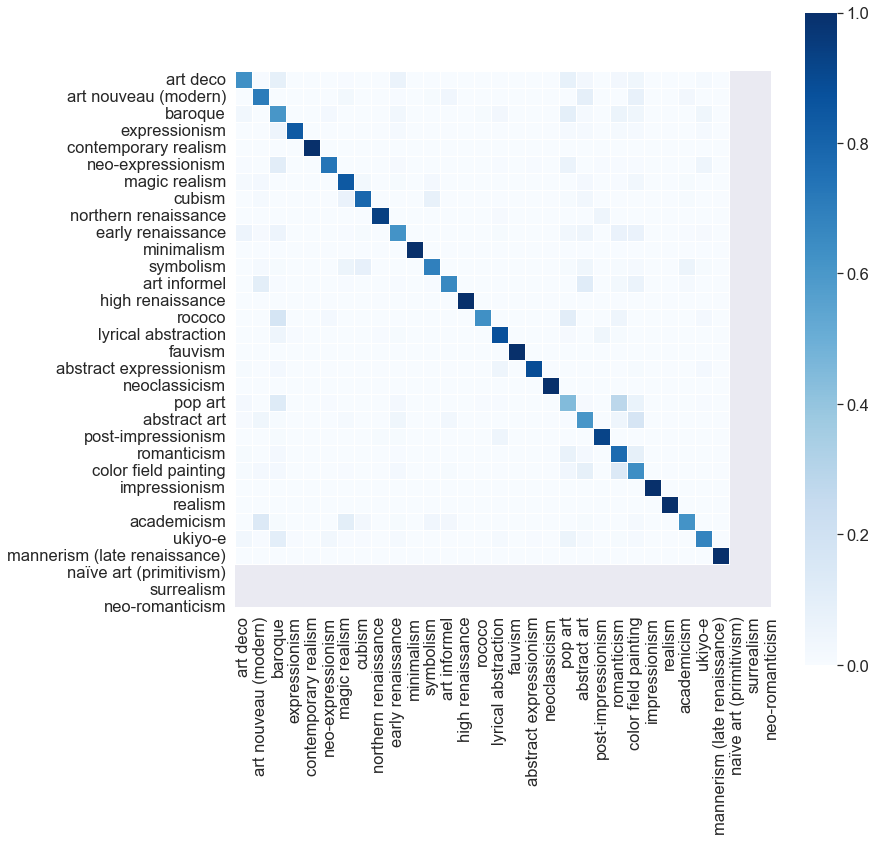

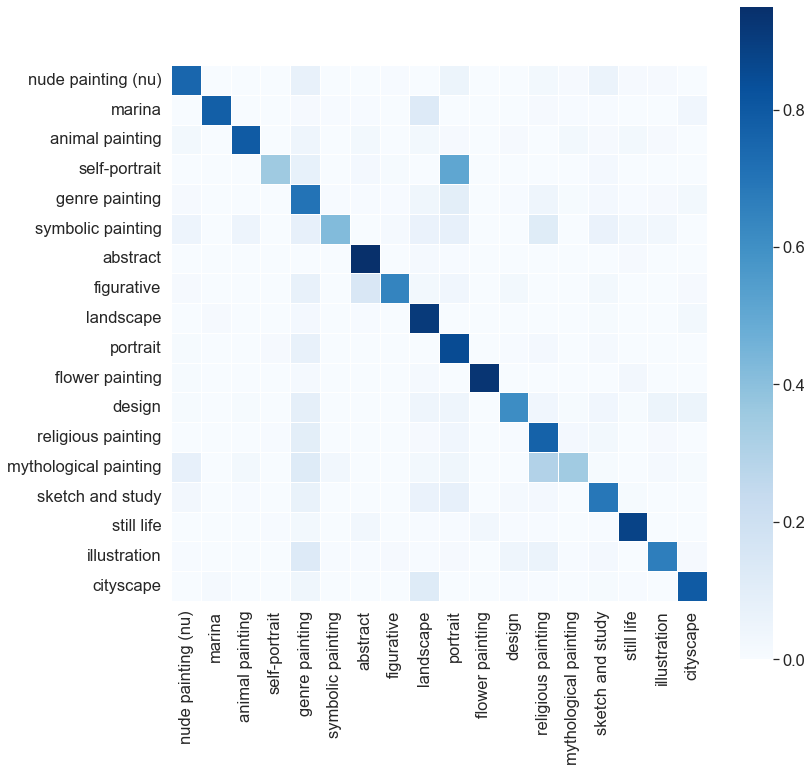

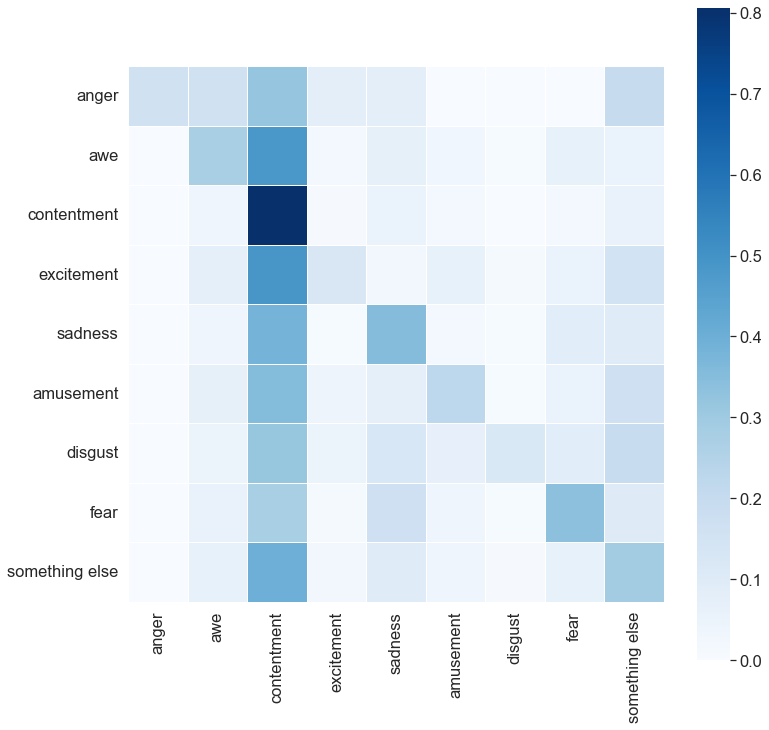

In [53]:
model = torch.load('vit_fine_tune_finetuned.pt').to('cuda:0')
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
with torch.no_grad():
    pred, lab = test(model, test_loader, train)
for task in ('style', 'genre', 'emotion'):
    results_df['Top1'].loc[task] = compute_topk(lab[task], pred[task], k=1)
    results_df['Top2'].loc[task] = compute_topk(lab[task], pred[task], k=2)
    pred_lab = torch.max(torch.Tensor(pred[task]), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(lab[task], pred_lab, average = 'macro')
    labels = pd.read_csv(f'{root}/mapping/{task}_entidx2name.csv', names = ['idx','name'])['name'].tolist()
    plot_confusion_matrix(lab[task], pred_lab, hop = map_hop[task], labels = labels)

In [54]:
results_df

Top1      Top2  Macro-F1
style    0.684444  0.844598  0.805136
genre    0.792797  0.914789  0.727299
emotion  0.468812  0.660383  0.322259